In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    import gradslam as gs
except ImportError:
    print("Installing gradslam...")
    !pip install 'git+https://github.com/gradslam/gradslam.git' -q
    print('Installed')
!pip install opencv-python-headless==4.5.2.52
!pip install open3d
!pip install kornia

Installing gradslam...
     |████████████████████████████████| 565 kB 4.1 MB/s 
     |████████████████████████████████| 4.6 MB 54.2 MB/s 
     |████████████████████████████████| 1.6 MB 51.4 MB/s 
Installed
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import open3d as o3d
import os
import numpy as np
import pandas as pd
import gradslam
import torch
from torch import nn
from gradslam.odometry import GradICPOdometryProvider
from kornia.geometry.linalg import compose_transformations
import matplotlib.pyplot as plt
from gradslam.odometry import ICPOdometryProvider

In [ ]:
import pickle
lasers_Path="/content/drive/MyDrive/Pickle dataset/lasers.pickle"
normals_Path="/content/drive/MyDrive/Pickle dataset/normals.pickle"
dbfile=open(lasers_Path,'rb')
lasers=pickle.load(dbfile)
dbfile.close()

dbfile=open(normals_Path,'rb')
normals=pickle.load(dbfile)
dbfile.close()

In [ ]:
BASE_PATH = "/content/drive/MyDrive/DSLR + GradSLAM/ARD16"
PCD_FOLDER = "_out"
PCD_PATH = os.path.join(BASE_PATH, PCD_FOLDER)
CSV_FOLDER="groundTruth.csv"
CSV_PATH=os.path.join(BASE_PATH,CSV_FOLDER)

def getint(name):
    return int(name.split('.')[0])
lst=sorted(os.listdir(PCD_PATH),key=getint)
csv=pd.read_csv(CSV_PATH)
odoms=[]
for i in lst:

  idx=int(float(i.strip("pcd")))
  if (sum(csv["step"]==idx)):
    # print(type(csv["step"][idx]))
    value = [csv.loc[x] for x in range(len(csv)) if csv["step"][x]== idx]
    frame= value[0].to_numpy()
    # print((value[0].to_numpy()))
    time_stamp = frame[1]
    pos = [frame[2],frame[3],frame[5]]
    rot = [frame[4],frame[6],frame[7]]

    odoms.append([time_stamp , pos, rot])

In [ ]:
class Graph:
    def __init__(self):
      self.loc={}
      self.fromNode=[]
      self.toNode=[]
      self.measurement=[]
      self.information=[]
      self.x=None
      self.lut={}
      self.Type=[]
    def add_vertex(self,id,pose):
        self.loc[id]=pose
    def add_edge(self,Type,fromNode,toNode,measurement,information):
      self.fromNode.append(fromNode)
      self.toNode.append(toNode)
      self.measurement.append(measurement)
      self.information.append(information)
      self.Type.append(Type)
    def get_pose(self,idx):
      return self.loc.get(idx,None)

In [ ]:
import math
def isRotationMatrix(R) :
    Rt = torch.transpose(R)
    shouldBeIdentity = torch.matmul(Rt, R)
    I = torch.eye(3, dtype = R.dtype)
    n = torch.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :

    #assert(isRotationMatrix(R))

    sy = torch.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = sy < 1e-6

    if  not singular :
        x = torch.atan2(R[2,1] , R[2,2])
        y = torch.atan2(-R[2,0], sy)
        z = torch.atan2(R[1,0], R[0,0])
    else :
        x = torch.atan2(-R[1,2], R[1,1])
        y = torch.atan2(-R[2,0], sy)
        z = 0

    return x,y,z


def eul2rot(z) :
    theta=[torch.tensor([1e-3],device="cuda"),torch.tensor([1e-3],device="cuda"),z]
    R = torch.tensor([[torch.cos(theta[1])*torch.cos(theta[2]),       torch.sin(theta[0])*torch.sin(theta[1])*torch.cos(theta[2]) - torch.sin(theta[2])*torch.cos(theta[0]),      torch.sin(theta[1])*torch.cos(theta[0])*torch.cos(theta[2]) + torch.sin(theta[0])*torch.sin(theta[2])],
                  [torch.sin(theta[2])*torch.cos(theta[1]),       torch.sin(theta[0])*torch.sin(theta[1])*torch.sin(theta[2]) + torch.cos(theta[0])*torch.cos(theta[2]),      torch.sin(theta[1])*torch.sin(theta[2])*torch.cos(theta[0]) - torch.sin(theta[0])*torch.cos(theta[2])],
                  [-torch.sin(theta[1]),                        torch.sin(theta[0])*torch.cos(theta[1]),                                                           torch.cos(theta[0])*torch.cos(theta[1])]])

    return R




def Convert_to_pose(trans):
  poseeuler=rotationMatrixToEulerAngles(torch.squeeze(trans)[:3,:3])   # Converting 3x3 orientation of pose of robot to euler angles
  pose=torch.concat((trans.squeeze()[:2,3],poseeuler[2].unsqueeze(0)))
  return pose

In [ ]:
def find_loop_clousure(curr_pose,curr_idx,laser,g):
  odomprov = GradICPOdometryProvider ( 10 , 1e-8, lambda_max=2.0, B=1.0, B2=1.0, nu=200.0 )
  if curr_idx==480:
    for i in range(0,22,2):
        transform=odomprov.provide(laser[169+i],laser[458+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",169+i,458+i,T,torch.eye(3,device="cuda"))
  if curr_idx==510:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[191+i],laser[480+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",191+i,480+i,T,torch.eye(3,device="cuda"))
  if curr_idx==540:
    for i in range(0,17,2):
        transform=odomprov.provide(laser[221+i],laser[510+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",221+i,510+i,T,torch.eye(3,device="cuda"))
  if curr_idx==660:
    for i in range(0,12,2):
        transform=odomprov.provide(laser[648+i],laser[1+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",648+i,1+i,T,torch.eye(3,device="cuda"))
  if curr_idx==690:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[660+i],laser[12+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",660+i,12+i,T,torch.eye(3,device="cuda"))
  if curr_idx==720:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[690+i],laser[42+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",690+i,42+i,T,torch.eye(3,device="cuda"))
  if curr_idx==750:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[720+i],laser[72+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",720+i,72+i,T,torch.eye(3,device="cuda"))
  if curr_idx==780:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[750+i],laser[102+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",750+i,102+i,T,torch.eye(3,device="cuda"))
  if curr_idx==810:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[780+i],laser[132+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",780+i,132+i,T,torch.eye(3,device="cuda"))
  if curr_idx==840:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[810+i],laser[162+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",810+i,162+i,T,torch.eye(3,device="cuda"))
  if curr_idx==870:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[840+i],laser[192+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",840+i,192+i,T,torch.eye(3,device="cuda"))
  if curr_idx==900:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[870+i],laser[222+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",870+i,222+i,T,torch.eye(3,device="cuda"))
  if curr_idx==930:
    for i in range(0,30,2):
        transform=odomprov.provide(laser[900+i],laser[252+i])
        #if torch.linalg.norm(torch.squeeze(transform)[:3,3])<loopThresh:
        transeuler=rotationMatrixToEulerAngles(torch.squeeze(transform)[:3,:3])
        T=torch.concat((transform[-1].squeeze()[:2,3],transeuler[2].unsqueeze(0)))
        g.add_edge("LP",900+i,252+i,T,torch.eye(3,device="cuda"))




In [ ]:




# Helper functions to get started


def v2t(pose):
    """This function converts SE2 pose from a vector to transformation

    Parameters
    ----------
    pose : 3x1 vector
        (x, y, theta) of the robot pose

    Returns
    -------
    T : 3x3 matrix
        Transformation matrix corresponding to the vector
    """
    c = torch.cos(pose[2])
    s = torch.sin(pose[2])
    T = torch.tensor([[c, -s, pose[0]], [s, c, pose[1]], [0, 0, 1]],device="cuda")
    return T
def compute_global_error(g):
    """ This function computes the total error for the graph.
    Parameters
    ----------
    g : Graph class
    Returns
    -------
    Fx: scalar
        Total error for the graph
    """
    Fx = 0
    for edge in g.edges:

        # pose-pose constraint
        if edge.Type == 'P':

            # compute idx for nodes using lookup table
            fromIdx = g.lut[edge.fromNode]
            toIdx = g.lut[edge.toNode]

            # get node state for the current edge
            x1 = g.x[fromIdx:fromIdx + 3]
            x2 = g.x[toIdx:toIdx + 3]

            # get measurement and information matrix for the edge
            z12 = edge.measurement
            info12 = edge.information

            # compute the error due to this edge
            X1_inv = inv(v2t(x1))
            X2 = v2t(x2)
            Z12_inv = inv(v2t(z12))
            Fx += torch.linalg.norm(t2v(np.dot(np.dot(Z12_inv, X1_inv), X2)))

        # pose-pose constraint
        elif edge.Type == 'LP':

            # compute idx for nodes using lookup table
            fromIdx = g.lut[edge.fromNode]
            toIdx = g.lut[edge.toNode]

            # get node states for the current edge
            x = g.x[fromIdx:fromIdx + 3]
            l = g.x[toIdx:toIdx + 2]

            # get measurement and information matrix for the edge
            z = edge.measurement
            info12 = edge.information

            # compute the error due to this edge
            X_inv = inv(v2t(x))[:2, :2]
            l = torch.unsqueeze(l, axis=1)
            z = torch.unsqueeze(z, axis=1)
            Fx += torch.linalg.norm(torch.dot(X_inv, l) - z)

    return Fx


def t2v(T):
    """This function converts SE2 transformation to vector for

    Parameters
    ----------
    T : 3x3 matrix
        Transformation matrix for 2D pose

    Returns
    -------
    pose : 3x1 vector
        (x, y, theta) of the robot pose
    """
    x = T[0, 2]
    y = T[1, 2]
    theta = torch.arctan2(T[1, 0], T[0, 0])
    v = torch.tensor([x, y, theta],device="cuda")
    return v


def plot_graph(g):
    # initialize figure
    plt.figure(1)
    plt.clf()

    # get a list of all poses and landmarks
    poses= get_poses_landmarks(g)

    # plot robot poses
    if len(poses) > 0:
        poses = np.stack(poses, axis=0)
        plt.plot(poses[:, 0], poses[:, 1], 'bo')

    # plot landmarks
    # plot edges/constraints
    poseEdgesP1 = []
    poseEdgesP2 = []
    P3=[]
    P4=[]
    for i in range(len(g.measurement)):
        fromIdx = g.lut[g.fromNode[i]]
        toIdx = g.lut[g.toNode[i]]
        if g.Type[i]=="P":
            poseEdgesP1.append(g.x[fromIdx:fromIdx + 3].cpu().detach().numpy())
            poseEdgesP2.append(g.x[toIdx:toIdx + 3].cpu().detach().numpy())
        if g.Type[i]=="LP":
          a=g.x[fromIdx:fromIdx + 3].cpu().detach().numpy()
          b=g.x[toIdx:toIdx + 3].cpu().detach().numpy()
          plt.plot([a[0],b[0]],[a[1],b[1]])
        plt.plot(np.array(poseEdgesP1)[:,0],np.array(poseEdgesP2)[:,1],"r")

    plt.show()

    return


def get_poses_landmarks(g):
    poses = []


    for nodeId in g.loc.keys():
        dimension = len(torch.squeeze(g.loc[nodeId]))
        offset = g.lut[nodeId]

        if dimension == 3:
            pose = g.x[offset:offset + 3]
            poses.append(pose.cpu().detach().numpy())

    return poses


def run_graph_slam(g, numIterations):
    tolerance = 1e-3
    norm_dX_all = []
    damp=1e-2

    # perform optimization
    for i in range(1000):

        dX = linearize_and_solve(g,damp)                       # this function gives dX which is calculated form H dX=-b from gaussian method
        #dX.sum().backward()
        #dX[dX>200]=100
        #dX[dX<-200]=-100
        # apply the solution to the state vector g.x
        g.x += dX

        # plot graph

        plot_graph(g)

        # compute and print global error
        norm_dX = np.linalg.norm(dX.cpu().detach().numpy())
        print(f"|dX| for step {i} : {norm_dX}\n")
        norm_dX_all.append(norm_dX)

        # terminate procedure if change is less than 10e-4
        if i >= 1 and np.abs(norm_dX_all[i] - norm_dX_all[i - 1]) < tolerance :
            break

    return torch.tensor(norm_dX_all)



def linearize_and_solve(g,damp,lambda_min=20.0,lambda_max=80.0,requires_LM=True):
    """ This function solves the least-squares problem for one iteration
        by linearizing the constraints

    Parameters
    ----------
    g : Graph class

    Returns
    -------
    dx : Nx1 vector
         change in the solution for the unknowns x
    """

    # initialize the sparse H and the vector b
    H = torch.zeros((len(g.x), len(g.x)),requires_grad=True,dtype=torch.float32,device="cuda")
    b = torch.zeros(len(g.x),requires_grad=True,dtype=torch.float32,device="cuda")
    b = torch.reshape(b,(-1,1))
    E_list=None
    # set flag to fix gauge
    needToAddPrior = True
    Fx = 0

    # compute the addend term to H and b for each of our constraints
    print('linearize and build system')

    for i in range(len(g.measurement)):

      fromIdx = g.lut[g.fromNode[i]]

      toIdx = g.lut[g.toNode[i]]



            # get node state for the current edge
      x_i = g.x[fromIdx:fromIdx + 3]
      x_j = g.x[toIdx:toIdx + 3]
      z_ij = torch.squeeze(g.measurement[i])
      omega = torch.squeeze(g.information[i])


            # compute the error and the Jacobians


      e, A, B = linearize_pose_pose_constraint(x_i, x_j, z_ij)
      if g.Type[i]=="P":
          if E_list is None:
            E_list=e.detach().squeeze()
          else:
            E_list=torch.cat((E_list,e.detach().squeeze()))

      # compute the terms
      # contributions of the constraints to the linear system
      b_i = torch.matmul(torch.matmul(A.T, omega), e).reshape(3, 1)
      b_j = torch.matmul(torch.matmul(B.T, omega), e).reshape(3, 1)
      H_ii = torch.matmul(torch.matmul(A.T, omega), A)
      H_ij = torch.matmul(torch.matmul(A.T, omega), B)
      H_ji = H_ij.T
      H_jj = torch.matmul(torch.matmul(B.T, omega), B)


            # add the terms to H matrix and b
            # Update H
      with torch.no_grad():
          H[fromIdx:fromIdx + 3, fromIdx:fromIdx + 3]= H[fromIdx:fromIdx + 3, fromIdx:fromIdx + 3]+ H_ii
          H[fromIdx:fromIdx + 3, toIdx:toIdx + 3] = H[fromIdx:fromIdx + 3, toIdx:toIdx + 3]+ H_ij
          H[toIdx:toIdx + 3, fromIdx:fromIdx + 3] = H[toIdx:toIdx + 3, fromIdx:fromIdx + 3]+ H_ji
          H[toIdx:toIdx + 3, toIdx:toIdx + 3] = H[toIdx:toIdx + 3, toIdx:toIdx + 3]+ H_jj

            # Update b
          b[fromIdx:fromIdx + 3]= b[fromIdx:fromIdx + 3]+ b_i
          b[toIdx:toIdx + 3]= b[toIdx:toIdx + 3] + b_j

            # Add the prior for one pose of this edge
            # This fixes one node to remain at its current location
      #if needToAddPrior:
      #    with torch.no_grad():
      #        H[fromIdx:fromIdx + 3, fromIdx:fromIdx + 3] = H[fromIdx:fromIdx + 3, fromIdx:fromIdx + 3] + 1000 * torch.eye(3,device="cuda")
      #    needToAddPrior = False

        # pose-pose





    # solve system
    # dx = np.linalg.solve(H, -b)
    # Instead of above we transform to a sparse one
    # Transformation to sparse matrix form
    #H_sparse = csr_matrix(H.detach().numpy())
    # Solve sparse system
    #with torch.no_grad():
    dx1 = torch.linalg.solve(H, -b)
    dx1 = dx1.squeeze()


    if requires_LM==True:
    # New edits for LM optimization
        E=g.x+dx1
        with torch.no_grad():
            look_ahead_error=find_error(E,g)
        errdiff=look_ahead_error-E_list
        errdiff = errdiff.clamp(-50.0, 50.0)

        damp_new = lambda_min + (lambda_max - lambda_min) / (
            1 + torch.exp(-1.0 * errdiff)
        )
        damp = damp * damp_new
        damp=torch.cat((damp,torch.zeros((3),device="cuda")))
        damp_matrix = torch.eye(damp.shape[0]).to("cuda")
        dx=torch.linalg.solve((H+damp_matrix*damp),-b)
        return dx.squeeze()



    del H
    del b
    torch.cuda.empty_cache()


    return dx1.squeeze()


def linearize_pose_pose_constraint(x1, x2, z):
    """Compute the error and the Jacobian for pose-pose constraint

    Parameters
    ----------
    x1 : 3x1 vector
         (x,y,theta) of the first robot pose
    x2 : 3x1 vector
         (x,y,theta) of the second robot pose
    z :  3x1 vector
         (x,y,theta) of the measurement

    Returns
    -------
    e  : 3x1
         error of the constraint
    A  : 3x3
         Jacobian wrt x1
    B  : 3x3
         Jacobian wrt x2
    """
    # x,y
    t_i = x1[:2].reshape(2, 1)
    t_j = x2[:2].reshape(2, 1)
    t_ij = z[:2].reshape(2, 1)

    # theta
    theta_i = x1[2]
    theta_j = x2[2]
    theta_ij = z[2]

    # Rotation matrix of i-th node
    R_i = v2t(x1)[:2, :2]

    # Rotation matrix of i-j constraint
    R_ij = v2t(z)[:2, :2]

    # Derivative of R_i with respect to theta_i
    dR_i = torch.tensor([[-torch.sin(theta_i), -torch.cos(theta_i)],
                     [torch.cos(theta_i), -torch.sin(theta_i)]],device="cuda")

    # Error calculated with above elements

    e_11_block = torch.matmul(torch.matmul(R_ij.T, R_i.T), t_j - t_i) - torch.matmul(R_ij.T, t_ij)
    e_21_block = theta_j - theta_i - theta_ij
    e = torch.vstack((e_11_block, e_21_block))

    # Jacobians of the error function
    # A
    A_11_block = torch.matmul(-R_ij.T, R_i.T)
    A_12_block = torch.matmul(torch.matmul(R_ij.T, dR_i.T), t_j - t_i)
    A_21_22_block = torch.tensor([0, 0, -1],device="cuda")

    A = torch.vstack((torch.hstack((A_11_block, A_12_block)), A_21_22_block))

    # B
    B_11_block = torch.matmul(R_ij.T, R_i.T)
    B_12_block = torch.zeros(2, 1, dtype=torch.float32,device="cuda")
    B_21_22_block = torch.tensor([0, 0, 1],device="cuda")


    B = torch.vstack((torch.hstack((B_11_block, B_12_block)), B_21_22_block))
    del dR_i
    del A_21_22_block
    del B_12_block
    del B_21_22_block
    torch.cuda.empty_cache()


    return e, A, B



def find_error(E,g):
  lst=None
  for i in range(len(g.measurement)):
    if g.Type[i]=="LP":
      continue
    fromIdx = g.lut[g.fromNode[i]]
    toIdx = g.lut[g.toNode[i]]
    # get node state for the current edge
    x1 = E[fromIdx:fromIdx + 3]
    x2 = E[toIdx:toIdx + 3]
    z = torch.squeeze(g.measurement[i])
    t_i = x1[:2].reshape(2, 1)
    t_j = x2[:2].reshape(2, 1)
    t_ij = z[:2].reshape(2, 1)

    # theta
    theta_i = x1[2]
    theta_j = x2[2]
    theta_ij = z[2]

    # Rotation matrix of i-th node
    R_i = v2t(x1)[:2, :2]

    # Rotation matrix of i-j constraint
    R_ij = v2t(z)[:2, :2]

    e_11_block = torch.matmul(torch.matmul(R_ij.T, R_i.T), t_j - t_i) - torch.matmul(R_ij.T, t_ij)
    e_21_block = theta_j - theta_i - theta_ij
    e = torch.vstack((e_11_block, e_21_block))
    if lst is None:
      lst=e.squeeze()
    else:
      lst=torch.cat((lst,e.squeeze()))
  return lst






In [ ]:
from scipy.spatial.transform import Rotation as R
def np_to_txt(time_stamp,pos,quat):
    "This function convers group of numpy array into a string as stecified in the format of the ate and rpe evalusation file"

    str = np.str(time_stamp)+np.array_str(pos)+ np.array_str(quat)
    str=str.replace("["," ")
    str =str.replace("]"," ")
    str =str.strip()
    str = " ".join(str.split())
    # print(str)
    return str

class grad_lidar(nn.Module):
    def __init__(self,iterations=10, device = "cuda"):
        super(grad_lidar, self).__init__()
        self.iterations = iterations
        self.device = device
        self.odomprov = GradICPOdometryProvider ( self.iterations , 1e-8, lambda_max=2.0, B=1.0, B2=0.1, nu=200.0 )
        self.all_lasers=[]
        self.g=Graph()
        self.offset=0
        self.prev=0
    def forward(self,pc_grad,odoms,loop_closure=True):
        #odom_data : Consists of odometry data of the robot i.e poses of the robot
        #pc_grad   : Consists of lidar scans for each and every pose in gradslam pointcloud datatype


        poses=[torch.eye(4, dtype=torch.float, device = self.device).view(1,1,4,4)]  # list containing poses of nodes
        vertex_idx=1
        poseeuler=rotationMatrixToEulerAngles(torch.squeeze(poses[-1])[:3,:3])       #Converting init orientation to euler angles
        pose=torch.concat((poses[-1].squeeze()[:2,3],poseeuler[2].unsqueeze(0)))
        self.g.add_vertex(vertex_idx,pose)                                           # adding first vertex

        for od_idx,odom in enumerate(odoms):

            if od_idx==0:
                prev_odom=odom
                prev_idx=0
                self.all_lasers.append(pc_grad[prev_idx])
                continue
            if od_idx%2==0:
                pcd1=pc_grad[prev_idx]
                0
                pcd2=pc_grad[od_idx]
                vertex_idx+=1

                transform=self.odomprov.provide(pcd1,pcd2)                            # finding transform using ICP form gradslam

                pcd_pose = compose_transformations(poses[-1].squeeze(1),transform.squeeze(1)).unsqueeze(1)
                poses.append(pcd_pose)
                pose=Convert_to_pose(poses[-1].squeeze())
                T=Convert_to_pose(transform.squeeze())
                self.g.add_vertex(vertex_idx,pose)                                        #Adding the vertex
                self.g.add_edge("P",vertex_idx-1,vertex_idx,T,torch.eye(3,device="cuda")) # Adding the edge


                prev_odm=odom
                prev_idx=od_idx
                self.all_lasers.append(pcd2)


                if vertex_idx>50 and vertex_idx%30==0:                                 # If the number of nodes> 50 then find loop clousure and optimize pose graph
                  if loop_closure:
                      find_loop_clousure(pose,vertex_idx,self.all_lasers,self.g)
                  for i,j in enumerate(list(self.g.loc.keys())[self.prev:vertex_idx]):    # Here g.x is flattened vector of all poses of the nodes
                    self.g.lut.update({j:self.offset})
                    self.offset=self.offset+len(self.g.loc[j])                            # g.lut is a dictionary which contains starting and ending index of pose for each node
                    if self.g.x==None:
                      self.g.x=self.g.loc[j]
                    else:
                      self.g.x=torch.cat((self.g.x,self.g.loc[j]))
                  #plot_graph(self.g)
                  err_dlr=run_graph_slam(self.g,100)                                      # running pose graph optimization for 100 iterations
                  self.prev=vertex_idx
                  up_poses=[i for i in [self.g.x[j:j+3] for j in range(0,len(self.g.x),3)]]
                  updated_poses=[]
                  for i in up_poses:
                    #print(i)
                    R1=eul2rot(i[2])
                    b=torch.eye(4, dtype=torch.float,device="cuda")
                    b[:3,:3]=R1
                    b[0][3]=i[0]
                    b[1][3]=i[1]
                    updated_poses.append(b.view(1,1,4,4))
                  self.poses=updated_poses


        gt_file = open("gt_2.txt",'w')
        inf_file = open("inf_2.txt",'w')

        bench_poses=[i for i in [self.g.x[j:j+3] for j in range(0,len(self.g.x),3)]]
        for i,p in enumerate(bench_poses):
          r = R.from_euler('z', odoms[2*i][2] , degrees = True).as_quat()
          gt_file.write(np_to_txt(odoms[2*i][0],np.array(odoms[2*i][1]),np.array(r))+"\n")
          #print(p[2].detach().cpu().numpy())
          r_inf = R.from_euler('z', p[2].detach().cpu().numpy() , degrees = True).as_quat()
          inf_file.write(np_to_txt(odoms[2*i][0],np.array([p[0].detach().cpu().numpy(),p[1].detach().cpu().numpy(),0]),np.array(r_inf))+"\n")

        gt_file.close()
        inf_file.close()



linearize and build system


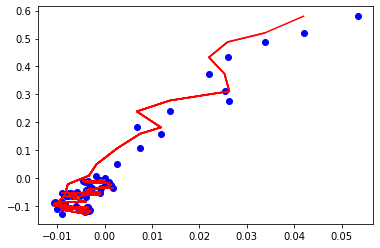

|dX| for step 0 : 9.386112651554868e-05

linearize and build system


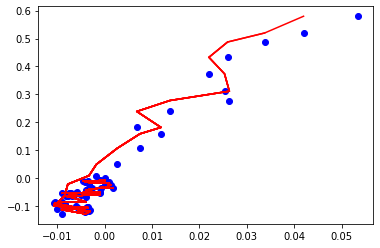

|dX| for step 1 : 3.0135886845528148e-05

linearize and build system


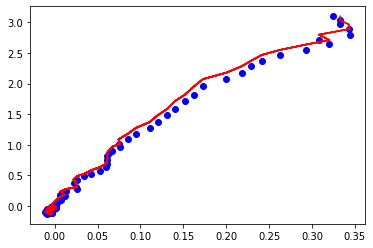

|dX| for step 0 : 0.00012597184104379267

linearize and build system


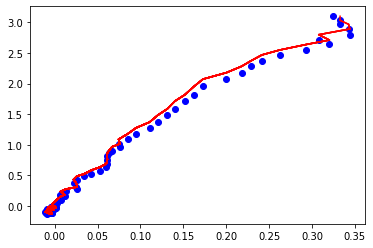

|dX| for step 1 : 4.545434421743266e-05

linearize and build system


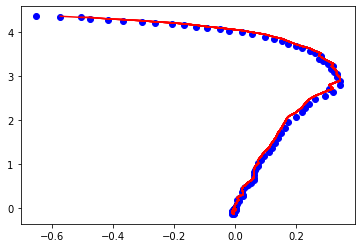

|dX| for step 0 : 0.00017240006127394736

linearize and build system


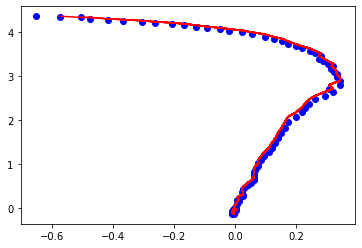

|dX| for step 1 : 5.044326826464385e-05

linearize and build system


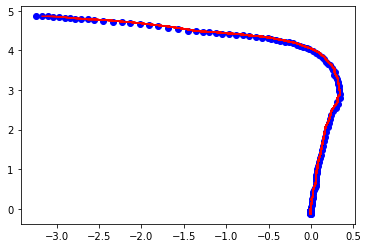

|dX| for step 0 : 0.00037626398261636496

linearize and build system


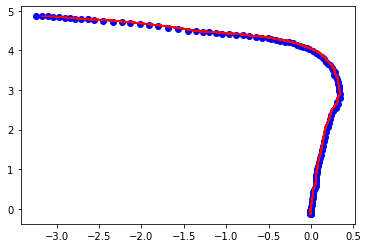

|dX| for step 1 : 0.00014074723003432155

linearize and build system


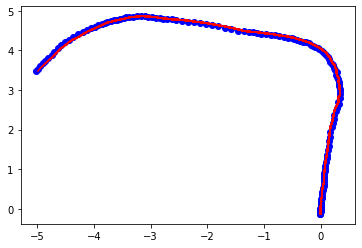

|dX| for step 0 : 0.0005660293973051012

linearize and build system


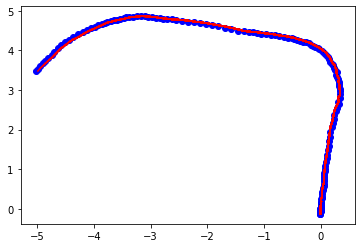

|dX| for step 1 : 0.00035650140489451587

linearize and build system


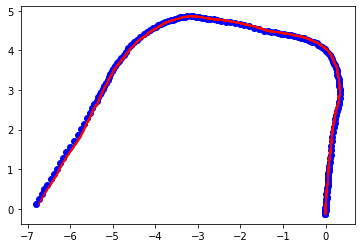

|dX| for step 0 : 0.0012950602686032653

linearize and build system


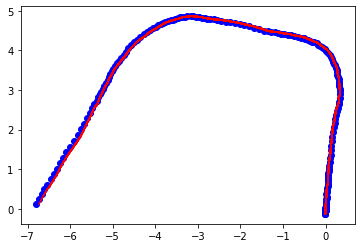

|dX| for step 1 : 0.0007340648444369435

linearize and build system


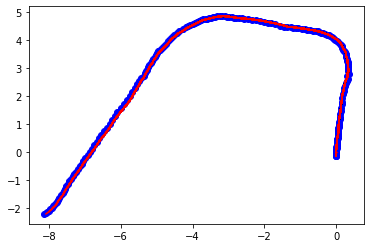

|dX| for step 0 : 0.0013548466376960278

linearize and build system


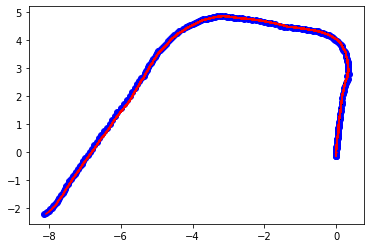

|dX| for step 1 : 0.000773903273511678

linearize and build system


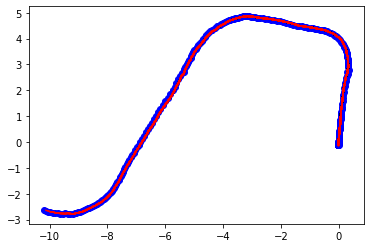

|dX| for step 0 : 0.0012531812535598874

linearize and build system


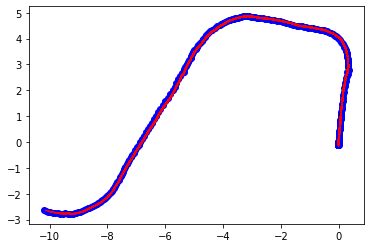

|dX| for step 1 : 0.0007602402474731207

linearize and build system


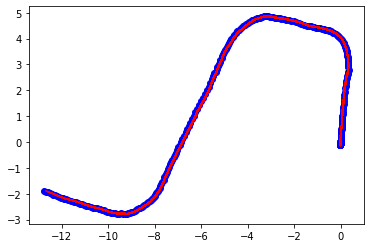

|dX| for step 0 : 0.0024983857292681932

linearize and build system


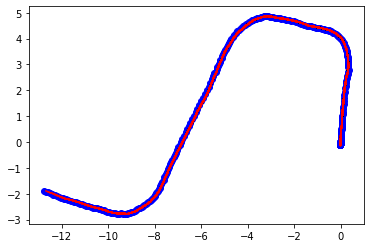

|dX| for step 1 : 0.0012465913314372301

linearize and build system


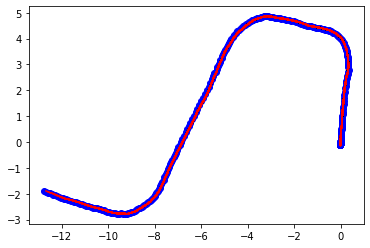

|dX| for step 2 : 0.001024473924189806

linearize and build system


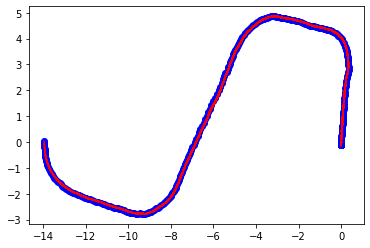

|dX| for step 0 : 0.002121158642694354

linearize and build system


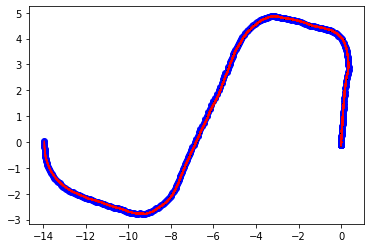

|dX| for step 1 : 0.0011479116510599852

linearize and build system


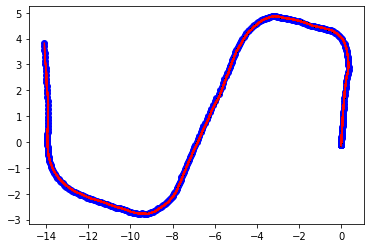

|dX| for step 0 : 0.0016733843367546797

linearize and build system


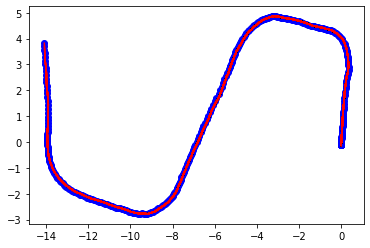

|dX| for step 1 : 0.0012758744414895773

linearize and build system


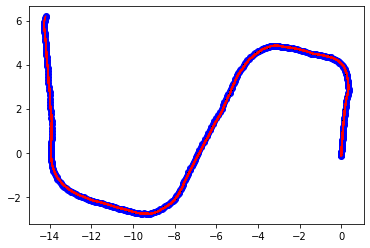

|dX| for step 0 : 0.0017953497590497136

linearize and build system


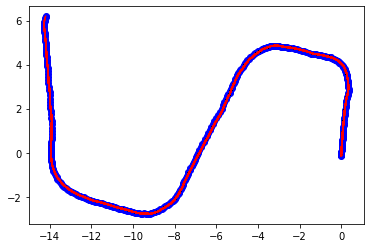

|dX| for step 1 : 0.0012581190094351768

linearize and build system


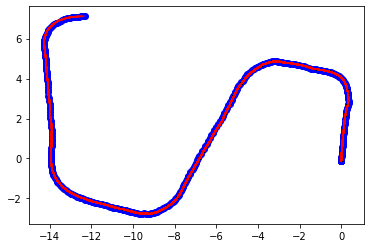

|dX| for step 0 : 0.0017860046355053782

linearize and build system


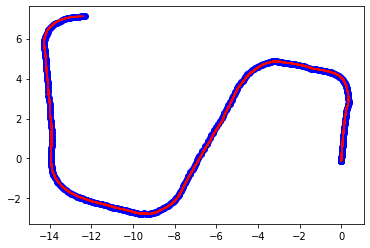

|dX| for step 1 : 0.0012622143840417266

linearize and build system


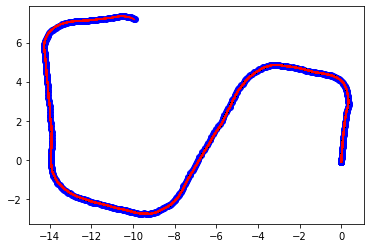

|dX| for step 0 : 0.0017330750124529004

linearize and build system


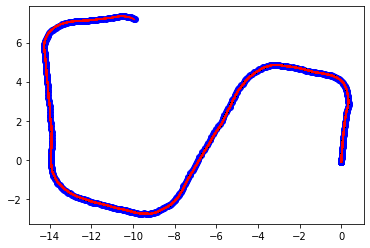

|dX| for step 1 : 0.0012521639000624418

linearize and build system


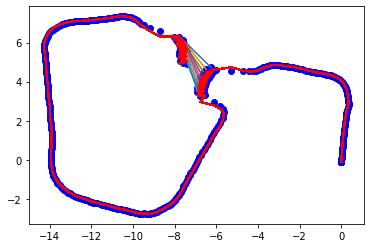

|dX| for step 0 : 16.013031005859375

linearize and build system


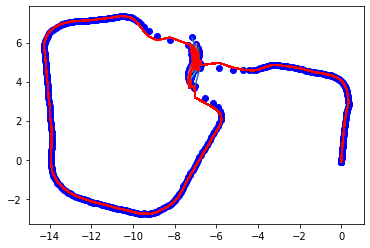

|dX| for step 1 : 7.399434566497803

linearize and build system


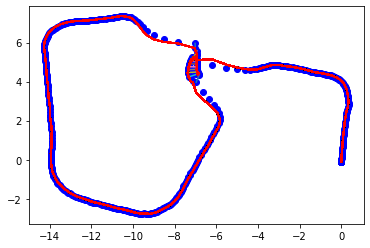

|dX| for step 2 : 3.580317974090576

linearize and build system


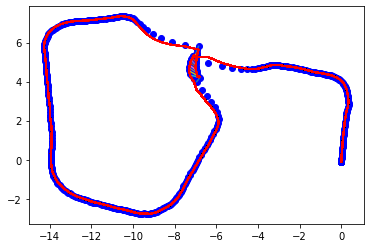

|dX| for step 3 : 1.9801571369171143

linearize and build system


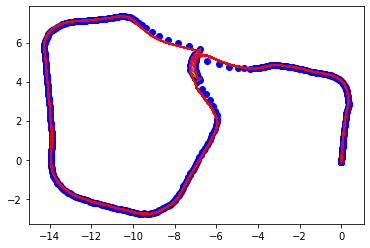

|dX| for step 4 : 1.247632622718811

linearize and build system


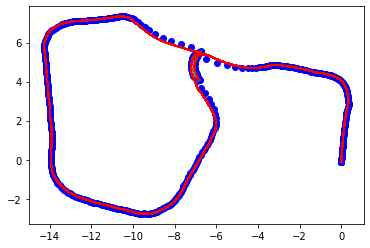

|dX| for step 5 : 0.8937392234802246

linearize and build system


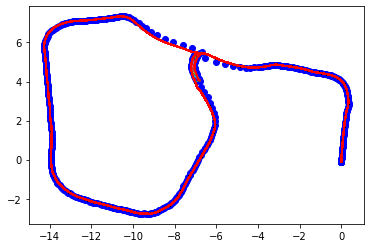

|dX| for step 6 : 0.65544193983078

linearize and build system


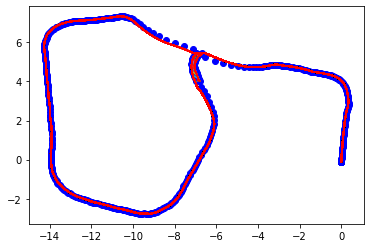

|dX| for step 7 : 0.5705268979072571

linearize and build system


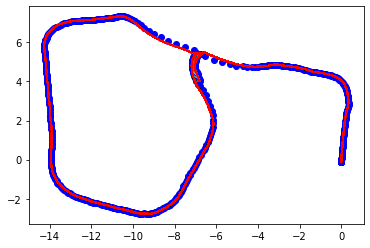

|dX| for step 8 : 0.5249553918838501

linearize and build system


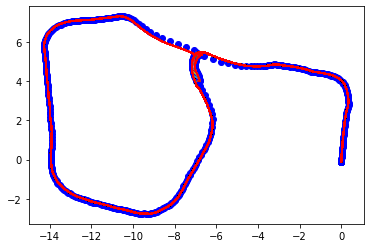

|dX| for step 9 : 0.49036750197410583

linearize and build system


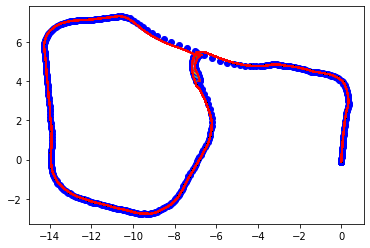

|dX| for step 10 : 0.45056021213531494

linearize and build system


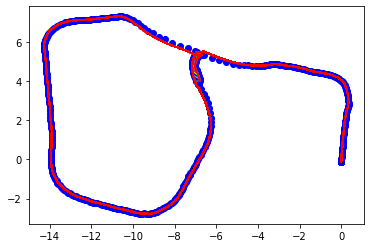

|dX| for step 11 : 0.40649881958961487

linearize and build system


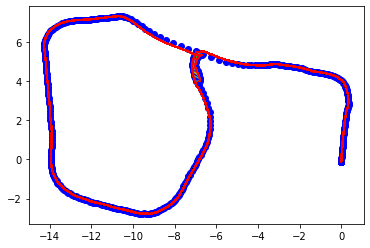

|dX| for step 12 : 0.3749239444732666

linearize and build system


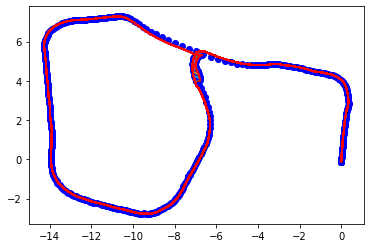

|dX| for step 13 : 0.3817268908023834

linearize and build system


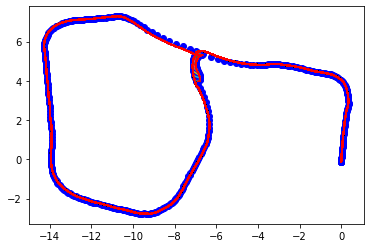

|dX| for step 14 : 0.33215731382369995

linearize and build system


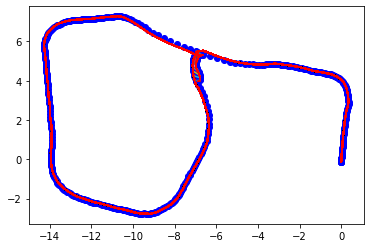

|dX| for step 15 : 0.3198697865009308

linearize and build system


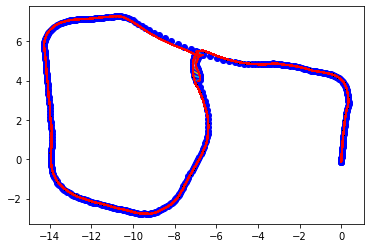

|dX| for step 16 : 0.3007163107395172

linearize and build system


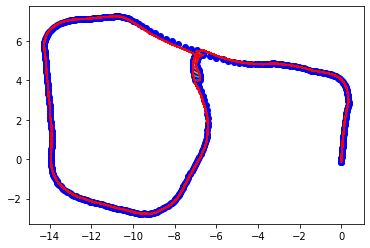

|dX| for step 17 : 0.2868211269378662

linearize and build system


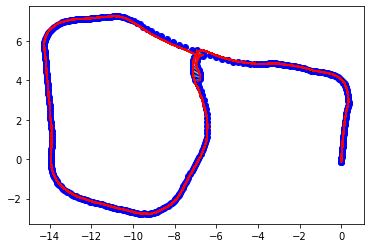

|dX| for step 18 : 0.27900463342666626

linearize and build system


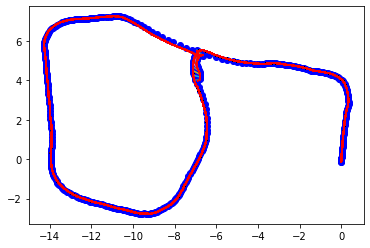

|dX| for step 19 : 0.29038161039352417

linearize and build system


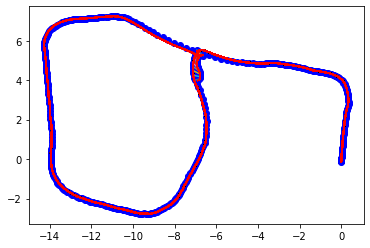

|dX| for step 20 : 0.2573603391647339

linearize and build system


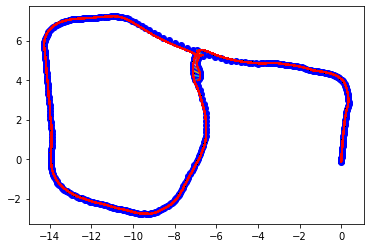

|dX| for step 21 : 0.24191462993621826

linearize and build system


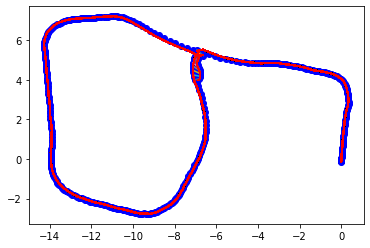

|dX| for step 22 : 0.23525673151016235

linearize and build system


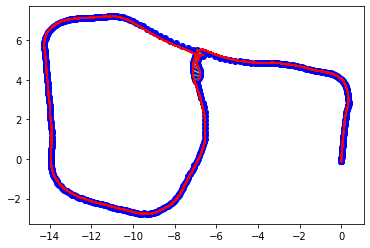

|dX| for step 23 : 0.24169214069843292

linearize and build system


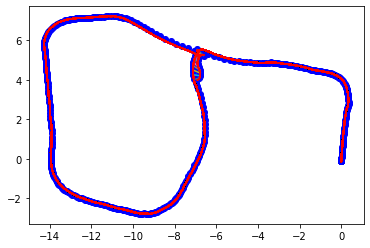

|dX| for step 24 : 0.29997479915618896

linearize and build system


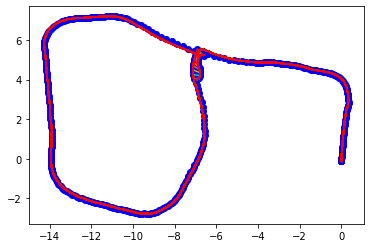

|dX| for step 25 : 0.20918145775794983

linearize and build system


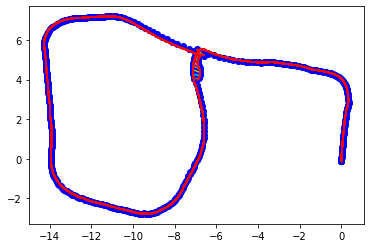

|dX| for step 26 : 0.20294496417045593

linearize and build system


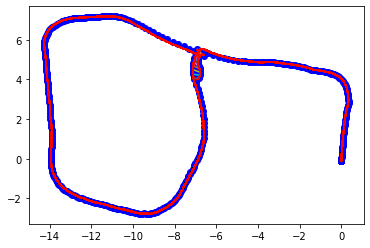

|dX| for step 27 : 0.19739320874214172

linearize and build system


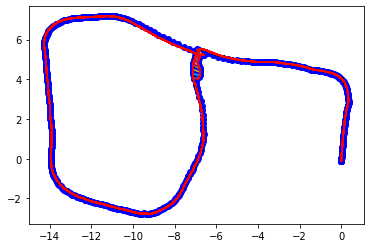

|dX| for step 28 : 0.20582133531570435

linearize and build system


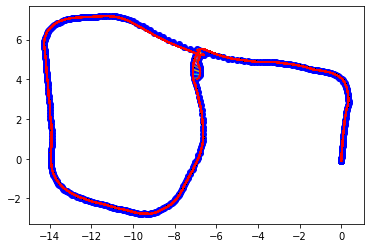

|dX| for step 29 : 0.18700599670410156

linearize and build system


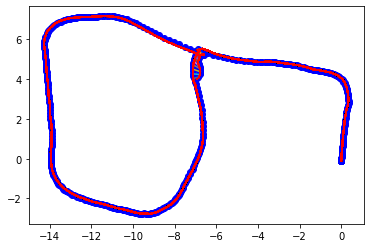

|dX| for step 30 : 0.18186959624290466

linearize and build system


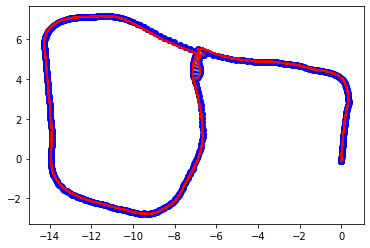

|dX| for step 31 : 0.1765717715024948

linearize and build system


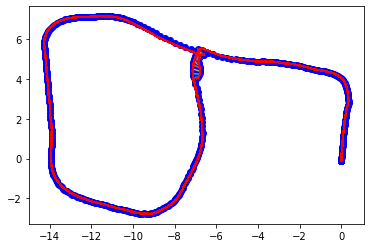

|dX| for step 32 : 0.1797107756137848

linearize and build system


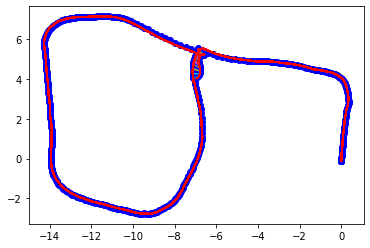

|dX| for step 33 : 0.16902968287467957

linearize and build system


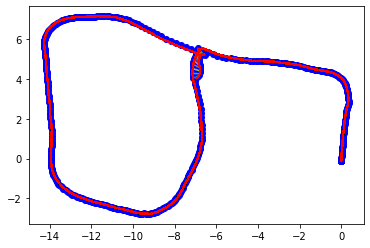

|dX| for step 34 : 0.16674500703811646

linearize and build system


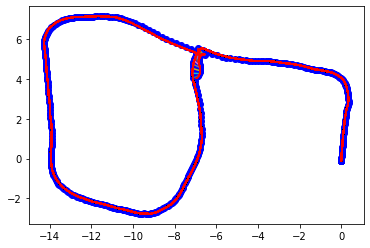

|dX| for step 35 : 0.16411378979682922

linearize and build system


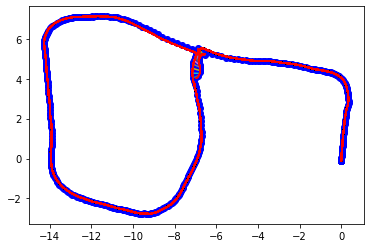

|dX| for step 36 : 0.15721069276332855

linearize and build system


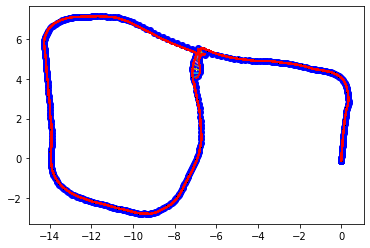

|dX| for step 37 : 0.15441928803920746

linearize and build system


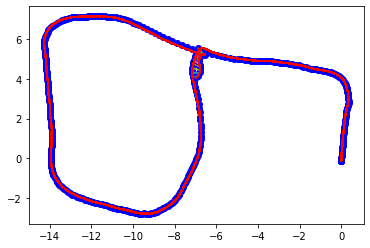

|dX| for step 38 : 0.15108591318130493

linearize and build system


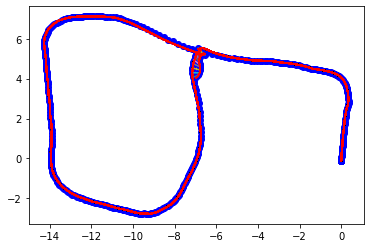

|dX| for step 39 : 0.15601147711277008

linearize and build system


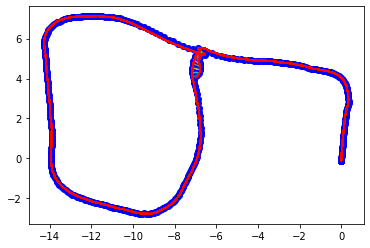

|dX| for step 40 : 0.14730001986026764

linearize and build system


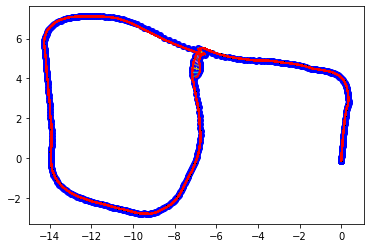

|dX| for step 41 : 0.14312468469142914

linearize and build system


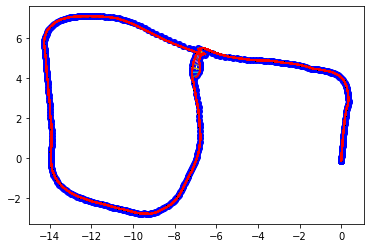

|dX| for step 42 : 0.1411832571029663

linearize and build system


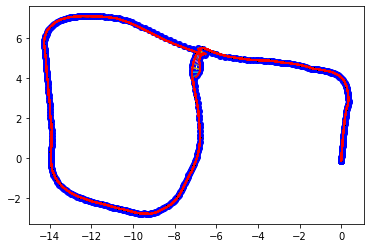

|dX| for step 43 : 0.14228811860084534

linearize and build system


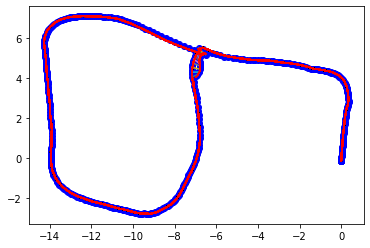

|dX| for step 44 : 0.14053501188755035

linearize and build system


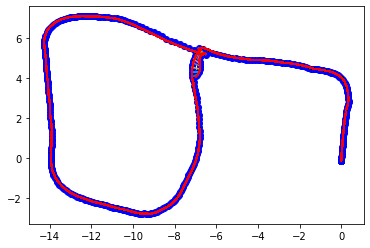

|dX| for step 45 : 0.14735041558742523

linearize and build system


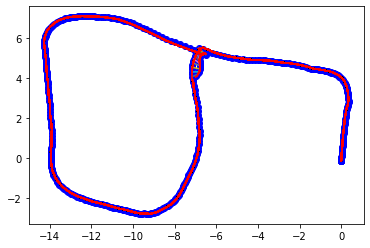

|dX| for step 46 : 0.13057370483875275

linearize and build system


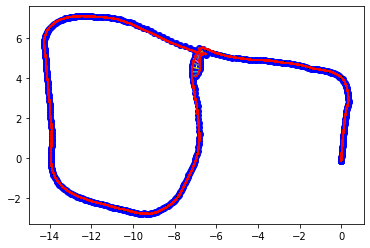

|dX| for step 47 : 0.13313932716846466

linearize and build system


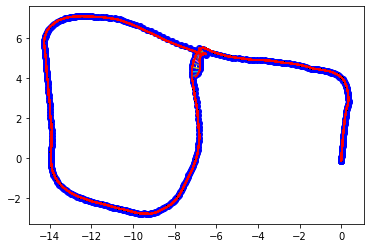

|dX| for step 48 : 0.1274290829896927

linearize and build system


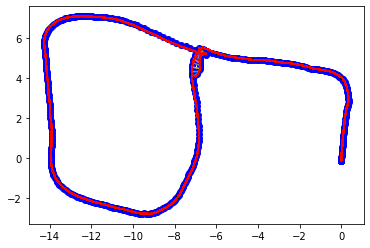

|dX| for step 49 : 0.12468874454498291

linearize and build system


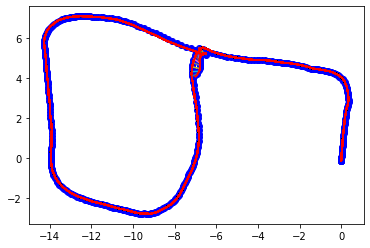

|dX| for step 50 : 0.12334529310464859

linearize and build system


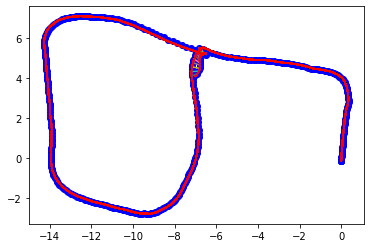

|dX| for step 51 : 0.12120483070611954

linearize and build system


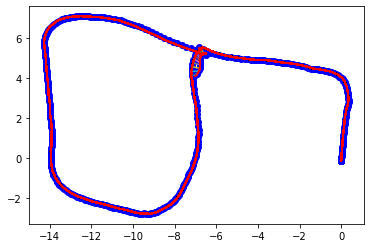

|dX| for step 52 : 0.12055923044681549

linearize and build system


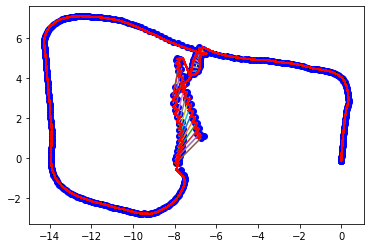

|dX| for step 0 : 15.270869255065918

linearize and build system


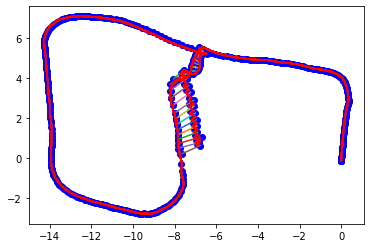

|dX| for step 1 : 7.220437049865723

linearize and build system


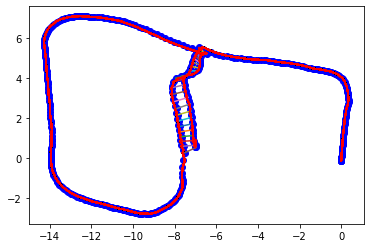

|dX| for step 2 : 3.419347047805786

linearize and build system


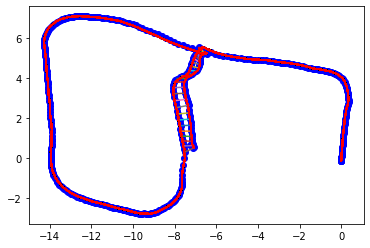

|dX| for step 3 : 1.6383088827133179

linearize and build system


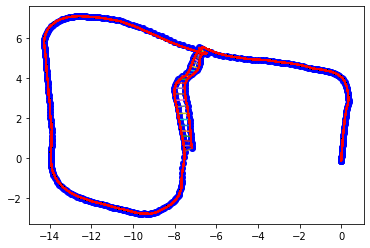

|dX| for step 4 : 0.8757414817810059

linearize and build system


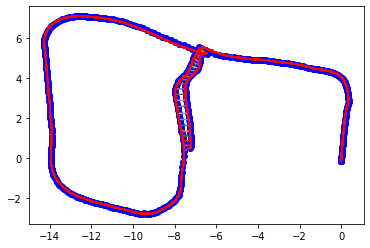

|dX| for step 5 : 0.6010935306549072

linearize and build system


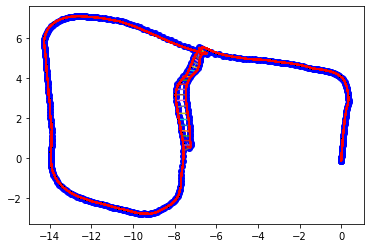

|dX| for step 6 : 0.4949919283390045

linearize and build system


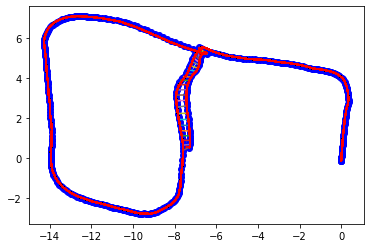

|dX| for step 7 : 0.4462953507900238

linearize and build system


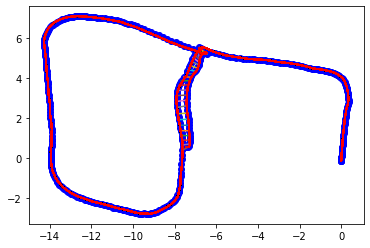

|dX| for step 8 : 0.41729310154914856

linearize and build system


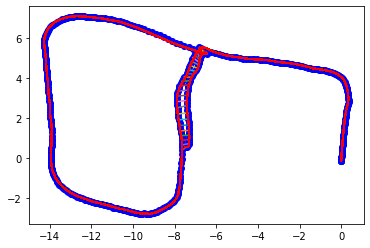

|dX| for step 9 : 0.3966054618358612

linearize and build system


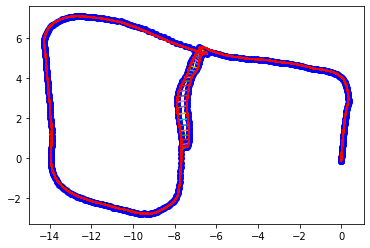

|dX| for step 10 : 0.3793192207813263

linearize and build system


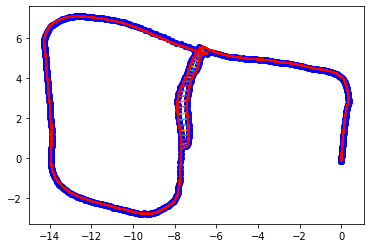

|dX| for step 11 : 0.3664570748806

linearize and build system


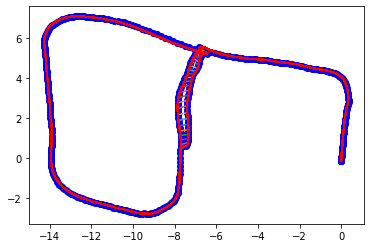

|dX| for step 12 : 0.35403889417648315

linearize and build system


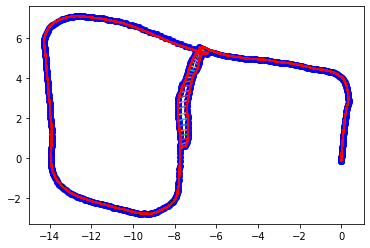

|dX| for step 13 : 0.34250572323799133

linearize and build system


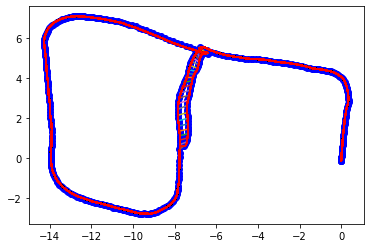

|dX| for step 14 : 0.3318394422531128

linearize and build system


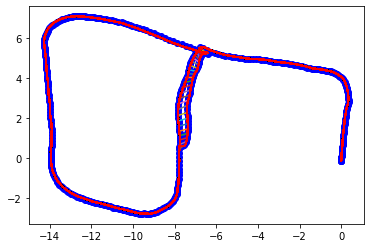

|dX| for step 15 : 0.3219700753688812

linearize and build system


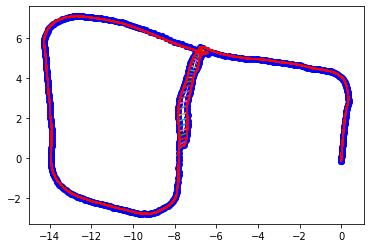

|dX| for step 16 : 0.312109112739563

linearize and build system


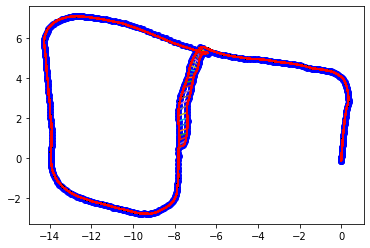

|dX| for step 17 : 0.3028221130371094

linearize and build system


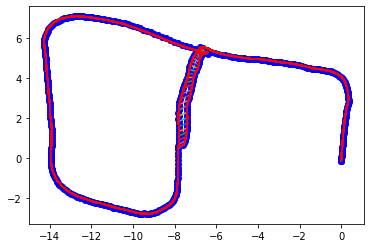

|dX| for step 18 : 0.2940334677696228

linearize and build system


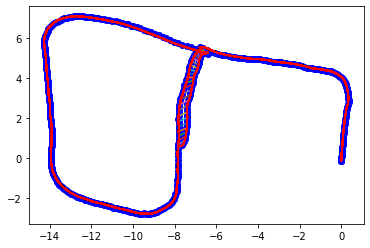

|dX| for step 19 : 0.28576087951660156

linearize and build system


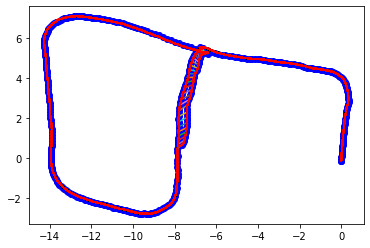

|dX| for step 20 : 0.2766492962837219

linearize and build system


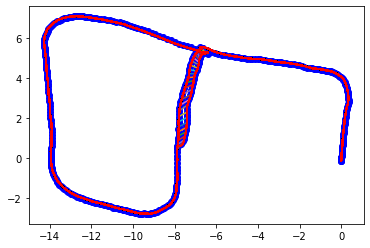

|dX| for step 21 : 0.2687740921974182

linearize and build system


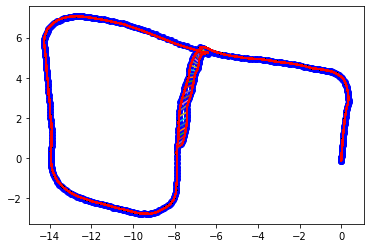

|dX| for step 22 : 0.26063036918640137

linearize and build system


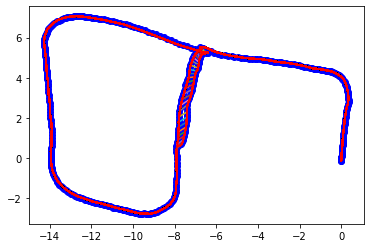

|dX| for step 23 : 0.2530134916305542

linearize and build system


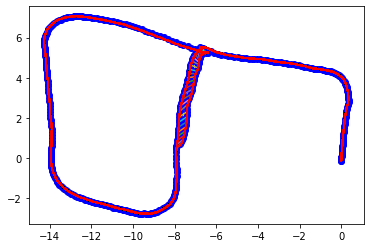

|dX| for step 24 : 0.2452637106180191

linearize and build system


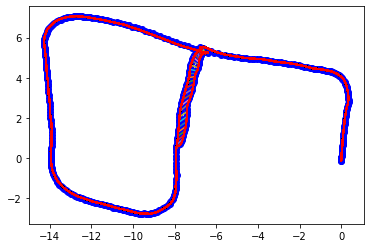

|dX| for step 25 : 0.23804789781570435

linearize and build system


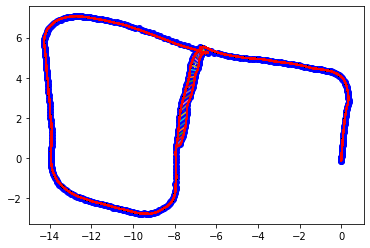

|dX| for step 26 : 0.23103748261928558

linearize and build system


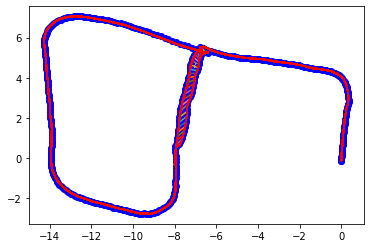

|dX| for step 27 : 0.22413623332977295

linearize and build system


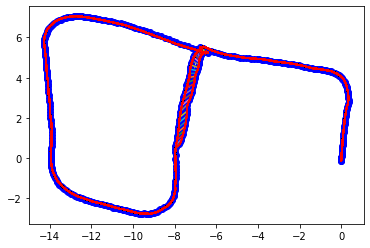

|dX| for step 28 : 0.21759764850139618

linearize and build system


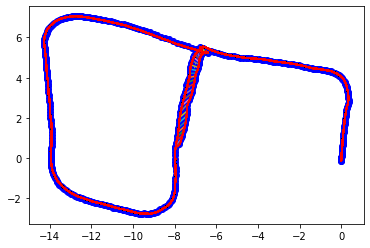

|dX| for step 29 : 0.21109922230243683

linearize and build system


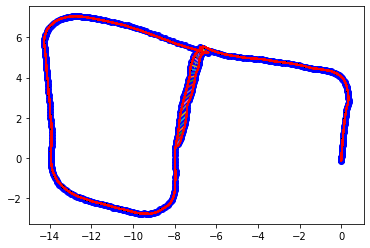

|dX| for step 30 : 0.20501935482025146

linearize and build system


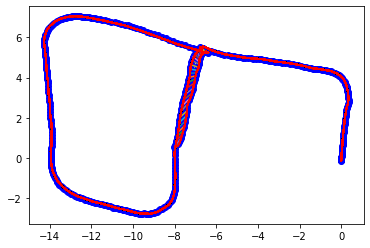

|dX| for step 31 : 0.19890166819095612

linearize and build system


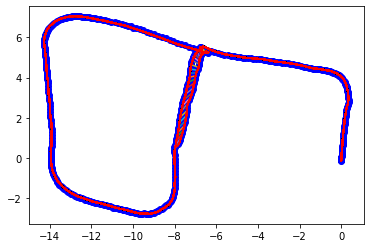

|dX| for step 32 : 0.19282382726669312

linearize and build system


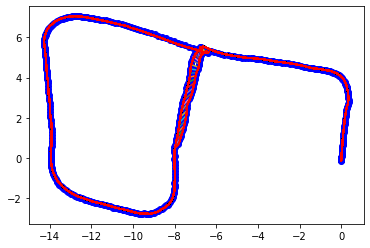

|dX| for step 33 : 0.18759451806545258

linearize and build system


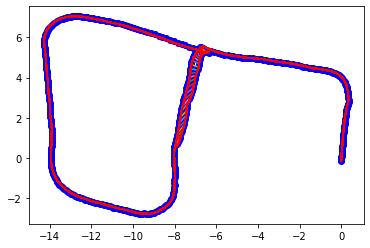

|dX| for step 34 : 0.18244795501232147

linearize and build system


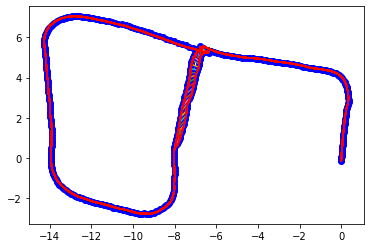

|dX| for step 35 : 0.1769561469554901

linearize and build system


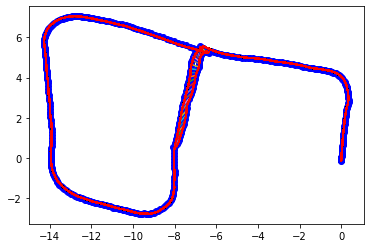

|dX| for step 36 : 0.17220093309879303

linearize and build system


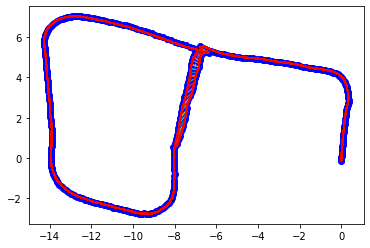

|dX| for step 37 : 0.16742533445358276

linearize and build system


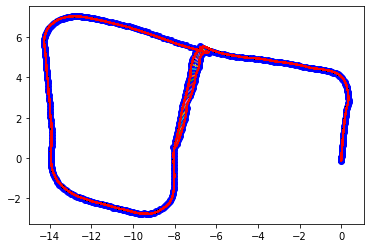

|dX| for step 38 : 0.16299524903297424

linearize and build system


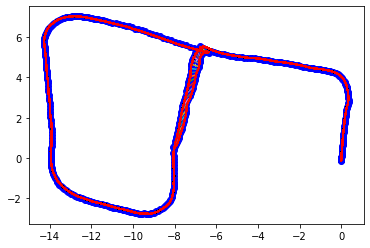

|dX| for step 39 : 0.15841124951839447

linearize and build system


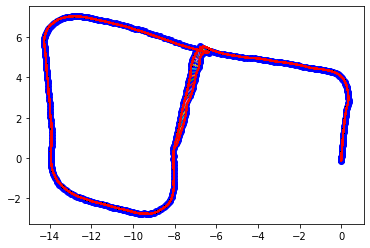

|dX| for step 40 : 0.15421366691589355

linearize and build system


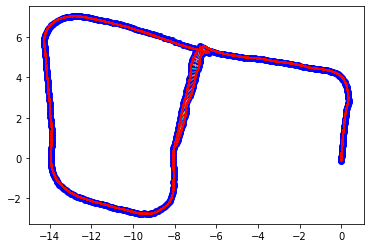

|dX| for step 41 : 0.15026238560676575

linearize and build system


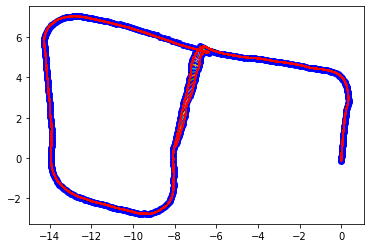

|dX| for step 42 : 0.15177899599075317

linearize and build system


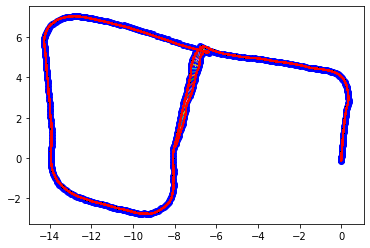

|dX| for step 43 : 0.14283724129199982

linearize and build system


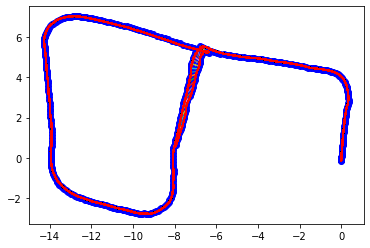

|dX| for step 44 : 0.13928933441638947

linearize and build system


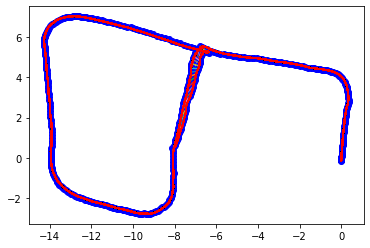

|dX| for step 45 : 0.135696679353714

linearize and build system


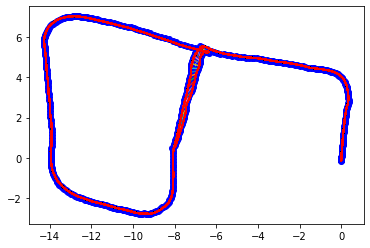

|dX| for step 46 : 0.1325715333223343

linearize and build system


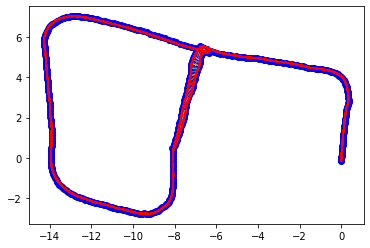

|dX| for step 47 : 0.1293964385986328

linearize and build system


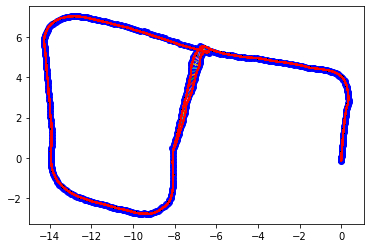

|dX| for step 48 : 0.1273195594549179

linearize and build system


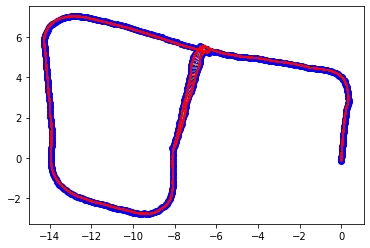

|dX| for step 49 : 0.12361631542444229

linearize and build system


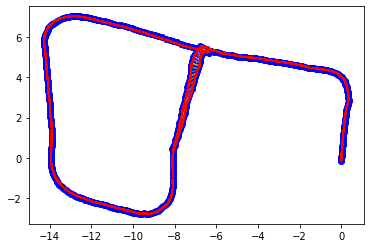

|dX| for step 50 : 0.12080547958612442

linearize and build system


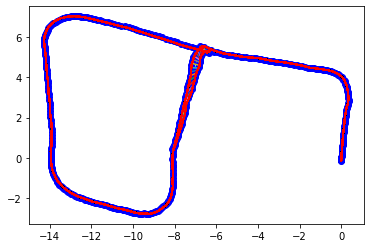

|dX| for step 51 : 0.11805588006973267

linearize and build system


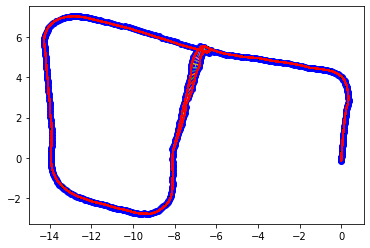

|dX| for step 52 : 0.11564592272043228

linearize and build system


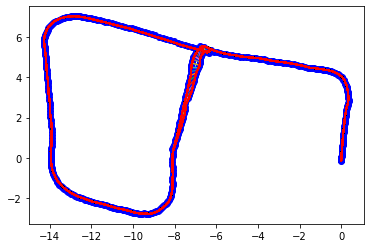

|dX| for step 53 : 0.11330528557300568

linearize and build system


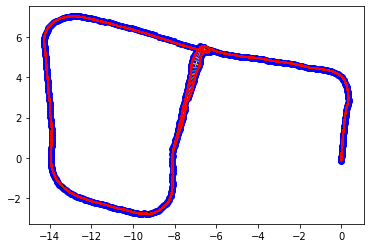

|dX| for step 54 : 0.1111714243888855

linearize and build system


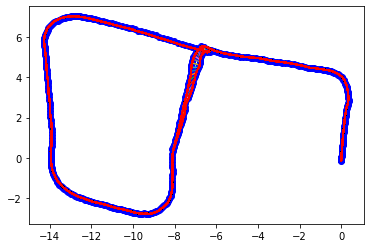

|dX| for step 55 : 0.10896535962820053

linearize and build system


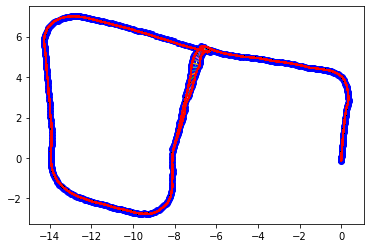

|dX| for step 56 : 0.1067911684513092

linearize and build system


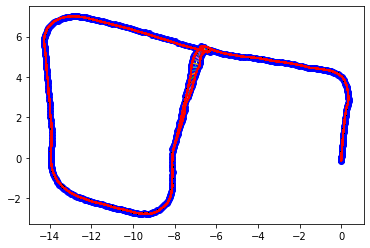

|dX| for step 57 : 0.10486456006765366

linearize and build system


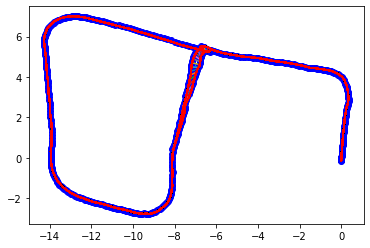

|dX| for step 58 : 0.1028503030538559

linearize and build system


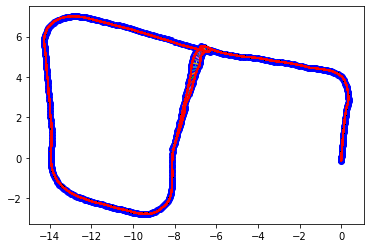

|dX| for step 59 : 0.10100147128105164

linearize and build system


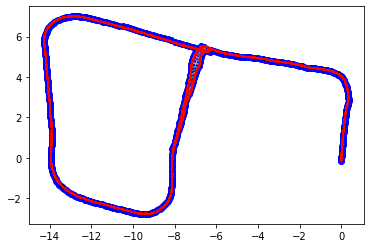

|dX| for step 60 : 0.09928231686353683

linearize and build system


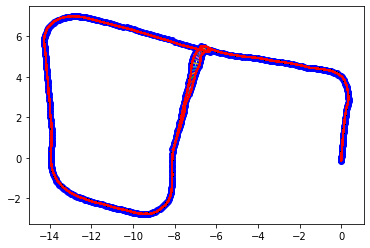

|dX| for step 61 : 0.09781457483768463

linearize and build system


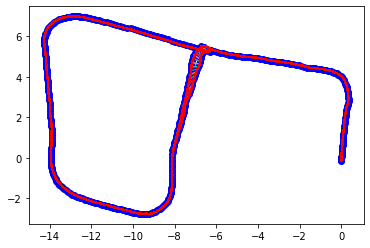

|dX| for step 62 : 0.09675810486078262

linearize and build system


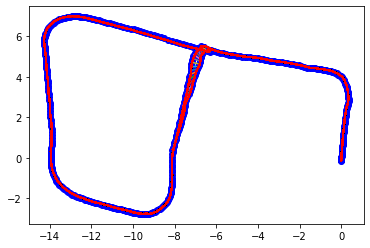

|dX| for step 63 : 0.09433674067258835

linearize and build system


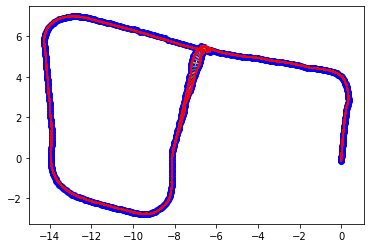

|dX| for step 64 : 0.09247200936079025

linearize and build system


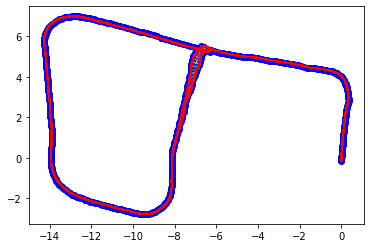

|dX| for step 65 : 0.09158740192651749

linearize and build system


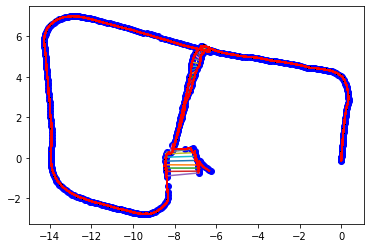

|dX| for step 0 : 10.80550479888916

linearize and build system


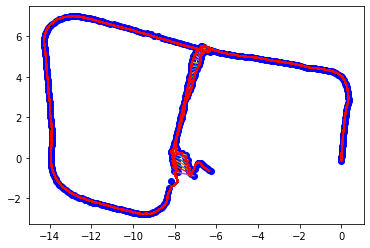

|dX| for step 1 : 4.8456244468688965

linearize and build system


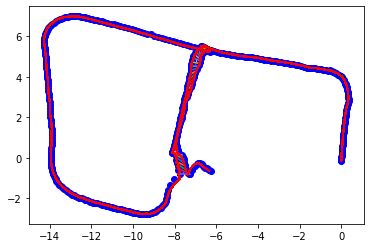

|dX| for step 2 : 2.2079529762268066

linearize and build system


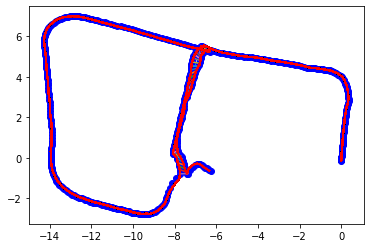

|dX| for step 3 : 1.1333950757980347

linearize and build system


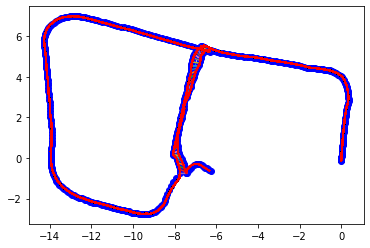

|dX| for step 4 : 0.7300114631652832

linearize and build system


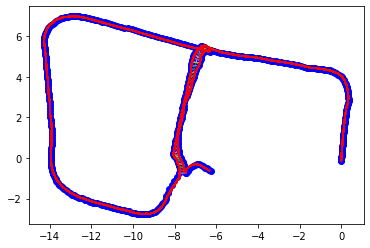

|dX| for step 5 : 0.5714659094810486

linearize and build system


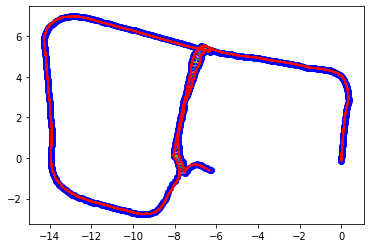

|dX| for step 6 : 0.489055335521698

linearize and build system


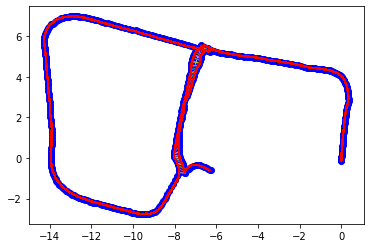

|dX| for step 7 : 0.4353426396846771

linearize and build system


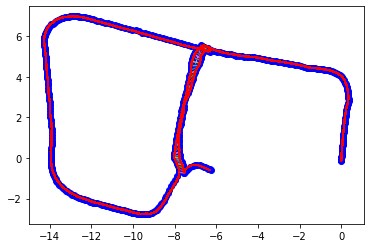

|dX| for step 8 : 0.3962274491786957

linearize and build system


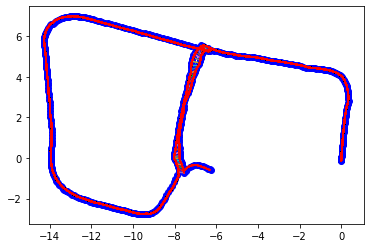

|dX| for step 9 : 0.36646443605422974

linearize and build system


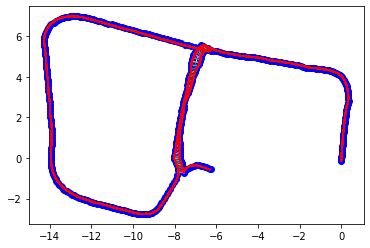

|dX| for step 10 : 0.34302374720573425

linearize and build system


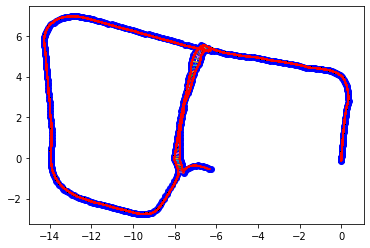

|dX| for step 11 : 0.32417032122612

linearize and build system


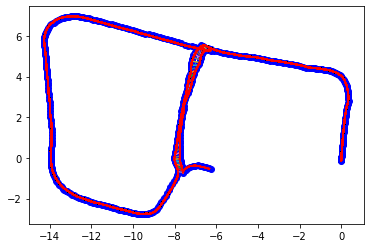

|dX| for step 12 : 0.30855605006217957

linearize and build system


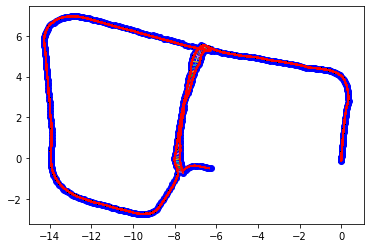

|dX| for step 13 : 0.2956833243370056

linearize and build system


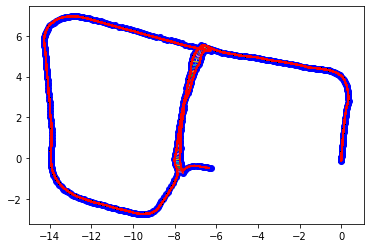

|dX| for step 14 : 0.2845962643623352

linearize and build system


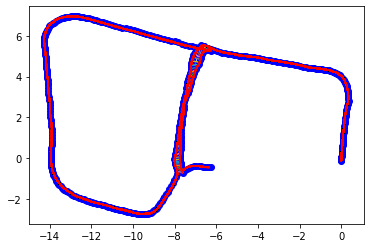

|dX| for step 15 : 0.2752138078212738

linearize and build system


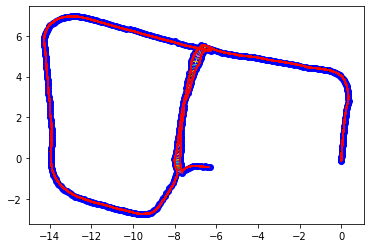

|dX| for step 16 : 0.2667122483253479

linearize and build system


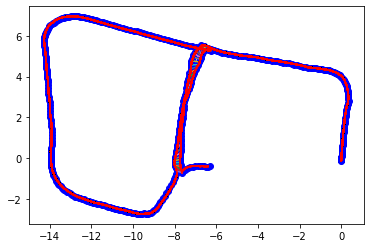

|dX| for step 17 : 0.259071946144104

linearize and build system


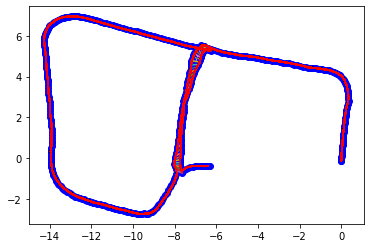

|dX| for step 18 : 0.25263476371765137

linearize and build system


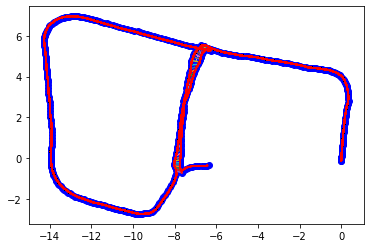

|dX| for step 19 : 0.24647732079029083

linearize and build system


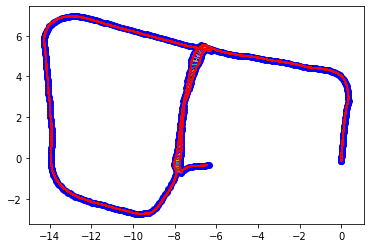

|dX| for step 20 : 0.2408367246389389

linearize and build system


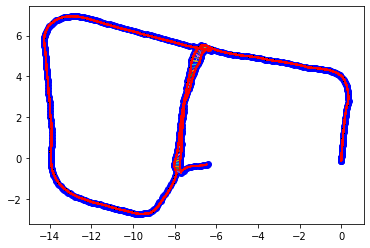

|dX| for step 21 : 0.23512639105319977

linearize and build system


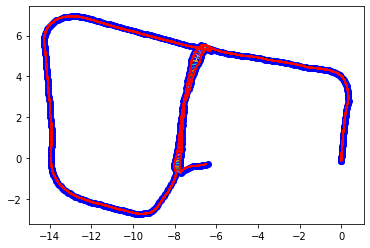

|dX| for step 22 : 0.2309117168188095

linearize and build system


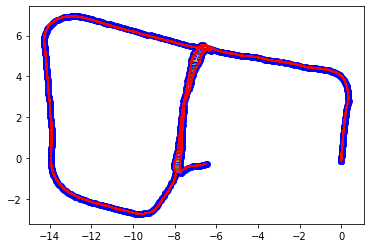

|dX| for step 23 : 0.22642512619495392

linearize and build system


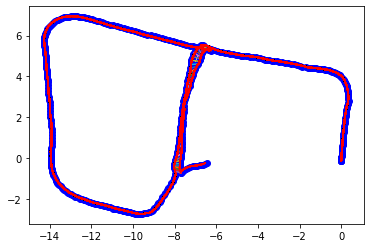

|dX| for step 24 : 0.22225914895534515

linearize and build system


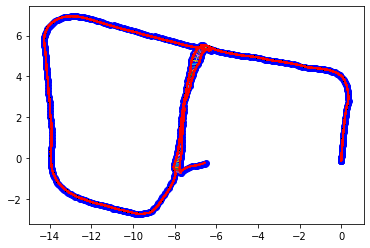

|dX| for step 25 : 0.21831874549388885

linearize and build system


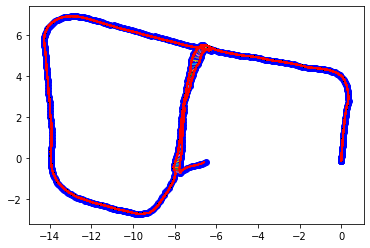

|dX| for step 26 : 0.2145800143480301

linearize and build system


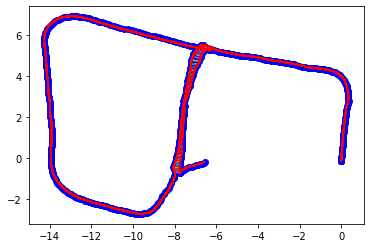

|dX| for step 27 : 0.21088197827339172

linearize and build system


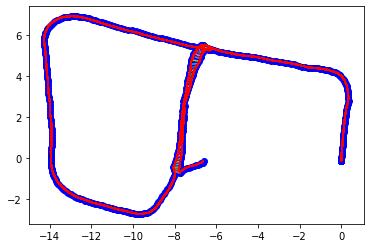

|dX| for step 28 : 0.20760460197925568

linearize and build system


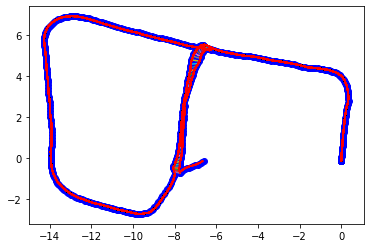

|dX| for step 29 : 0.20458313822746277

linearize and build system


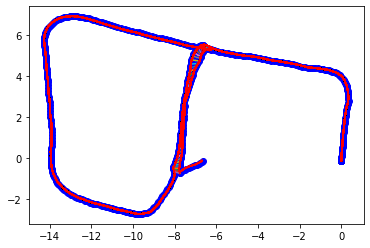

|dX| for step 30 : 0.20114733278751373

linearize and build system


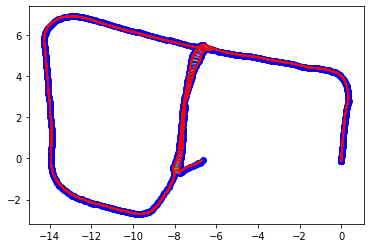

|dX| for step 31 : 0.19810347259044647

linearize and build system


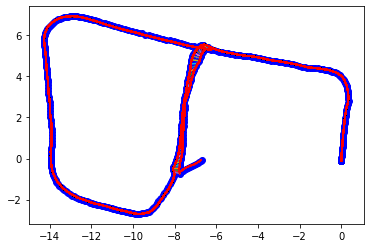

|dX| for step 32 : 0.19526638090610504

linearize and build system


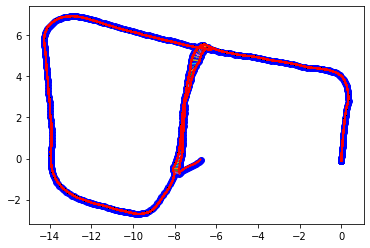

|dX| for step 33 : 0.19254831969738007

linearize and build system


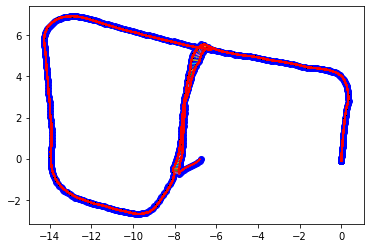

|dX| for step 34 : 0.19035618007183075

linearize and build system


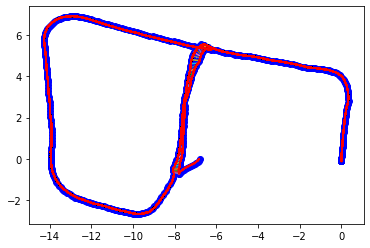

|dX| for step 35 : 0.1875080019235611

linearize and build system


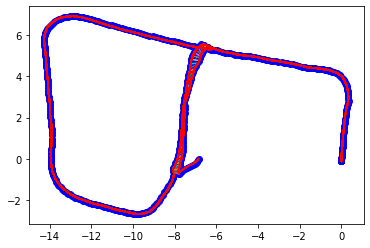

|dX| for step 36 : 0.1852114200592041

linearize and build system


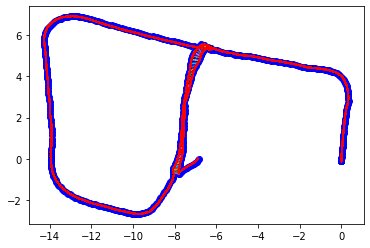

|dX| for step 37 : 0.18289834260940552

linearize and build system


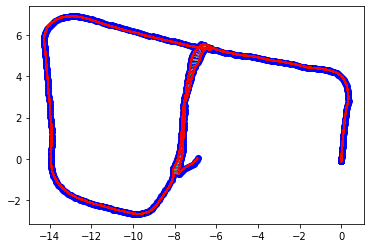

|dX| for step 38 : 0.18073324859142303

linearize and build system


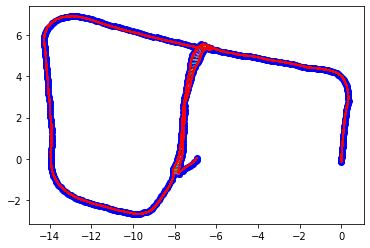

|dX| for step 39 : 0.17820851504802704

linearize and build system


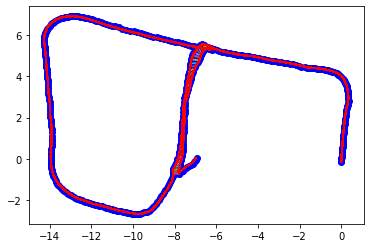

|dX| for step 40 : 0.1763482242822647

linearize and build system


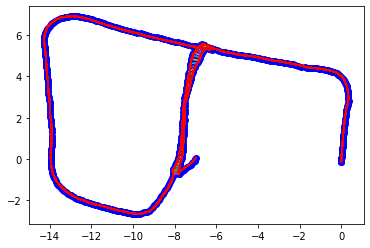

|dX| for step 41 : 0.17401842772960663

linearize and build system


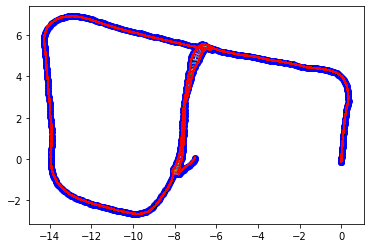

|dX| for step 42 : 0.17221997678279877

linearize and build system


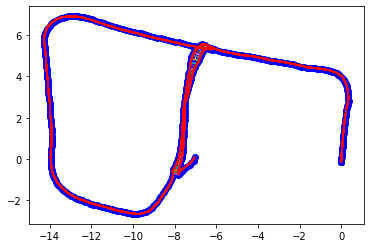

|dX| for step 43 : 0.17053715884685516

linearize and build system


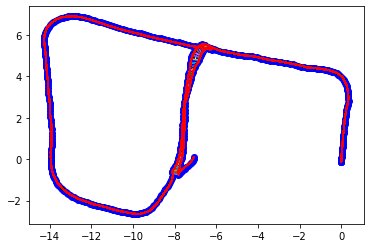

|dX| for step 44 : 0.16827379167079926

linearize and build system


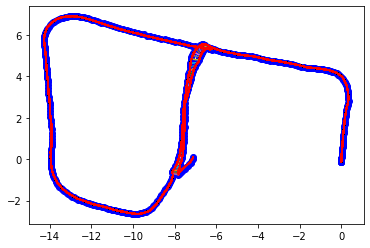

|dX| for step 45 : 0.16681724786758423

linearize and build system


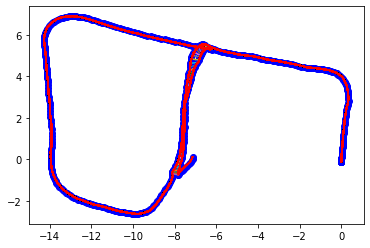

|dX| for step 46 : 0.16506683826446533

linearize and build system


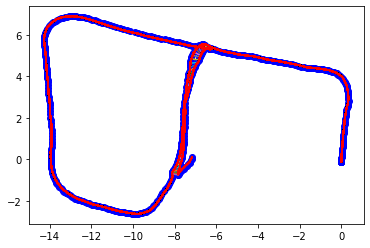

|dX| for step 47 : 0.16339008510112762

linearize and build system


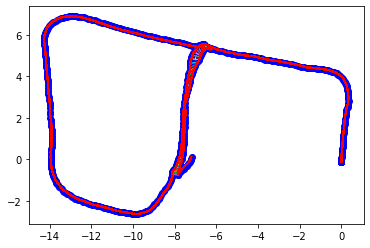

|dX| for step 48 : 0.16153793036937714

linearize and build system


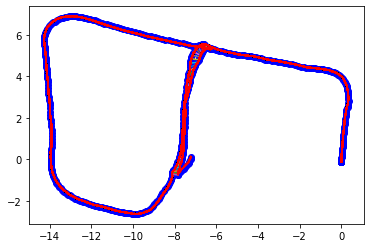

|dX| for step 49 : 0.15994012355804443

linearize and build system


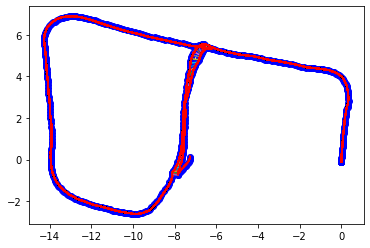

|dX| for step 50 : 0.1574525088071823

linearize and build system


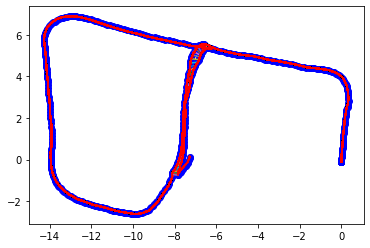

|dX| for step 51 : 0.1565539836883545

linearize and build system


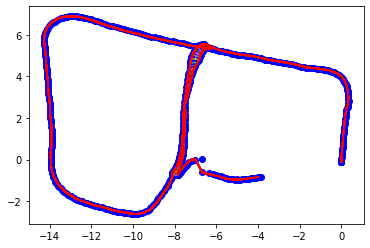

|dX| for step 0 : 1.3949965238571167

linearize and build system


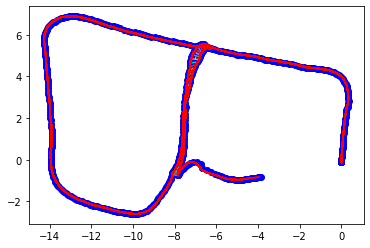

|dX| for step 1 : 0.6024656295776367

linearize and build system


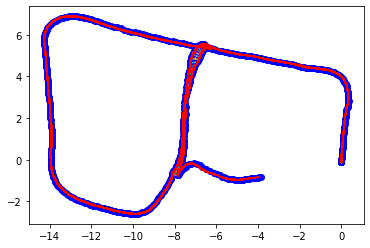

|dX| for step 2 : 0.360731840133667

linearize and build system


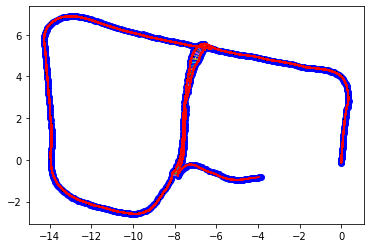

|dX| for step 3 : 0.26797837018966675

linearize and build system


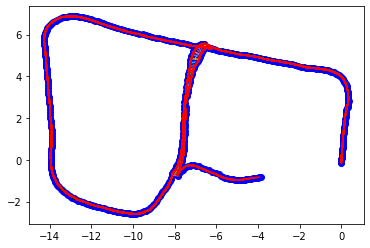

|dX| for step 4 : 0.21118439733982086

linearize and build system


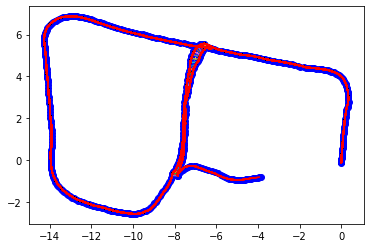

|dX| for step 5 : 0.18517284095287323

linearize and build system


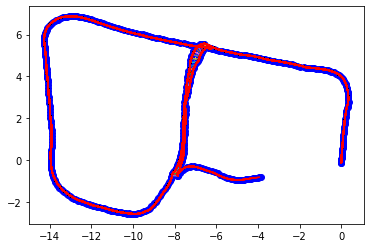

|dX| for step 6 : 0.16693095862865448

linearize and build system


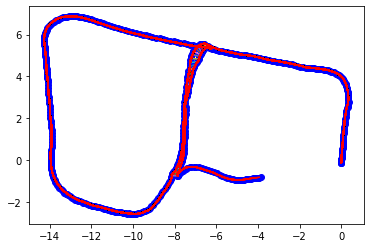

|dX| for step 7 : 0.1528870165348053

linearize and build system


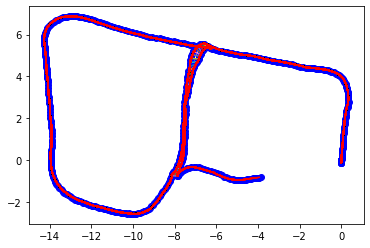

|dX| for step 8 : 0.14100849628448486

linearize and build system


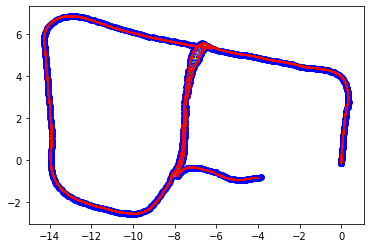

|dX| for step 9 : 0.13327361643314362

linearize and build system


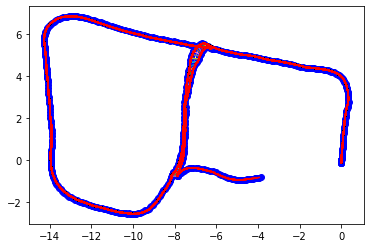

|dX| for step 10 : 0.1274806410074234

linearize and build system


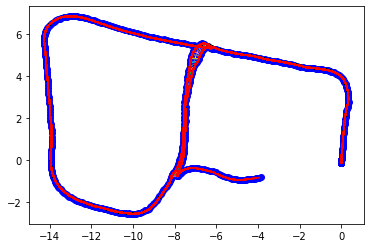

|dX| for step 11 : 0.12284767627716064

linearize and build system


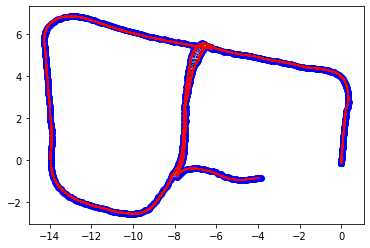

|dX| for step 12 : 0.1177811250090599

linearize and build system


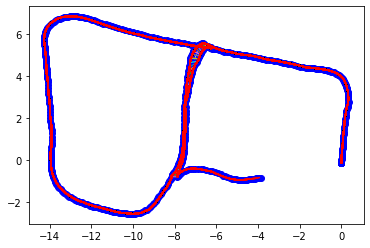

|dX| for step 13 : 0.11454280465841293

linearize and build system


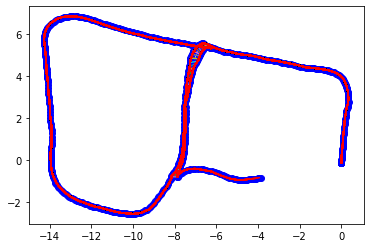

|dX| for step 14 : 0.11094989627599716

linearize and build system


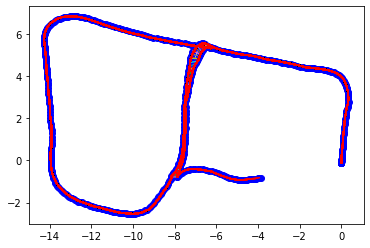

|dX| for step 15 : 0.1093197613954544

linearize and build system


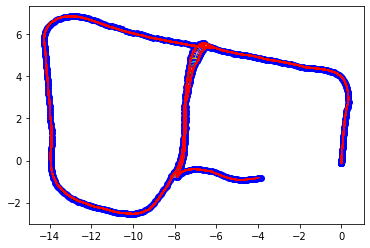

|dX| for step 16 : 0.10585658252239227

linearize and build system


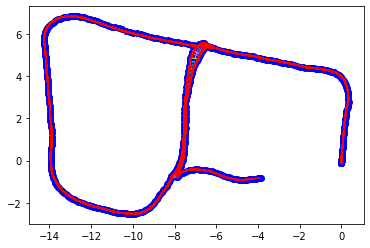

|dX| for step 17 : 0.1035076379776001

linearize and build system


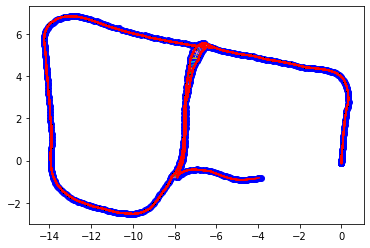

|dX| for step 18 : 0.10092606395483017

linearize and build system


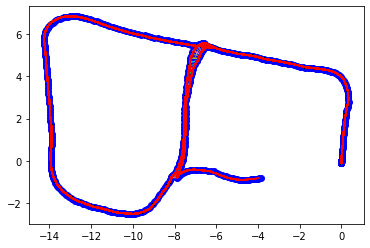

|dX| for step 19 : 0.09958821535110474

linearize and build system


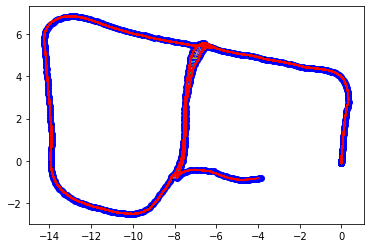

|dX| for step 20 : 0.09872297942638397

linearize and build system


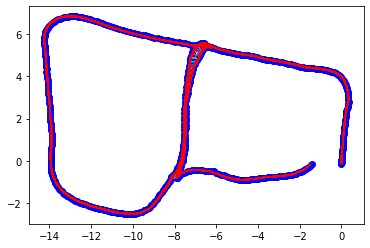

|dX| for step 0 : 0.0976749137043953

linearize and build system


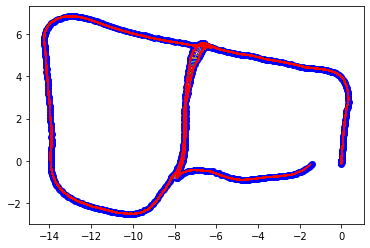

|dX| for step 1 : 0.09419872611761093

linearize and build system


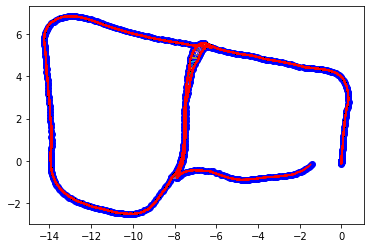

|dX| for step 2 : 0.09505525231361389

linearize and build system


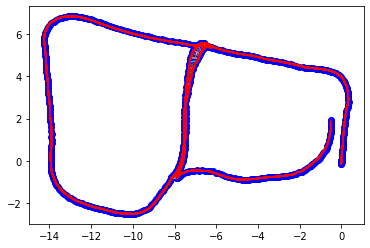

|dX| for step 0 : 0.09407372027635574

linearize and build system


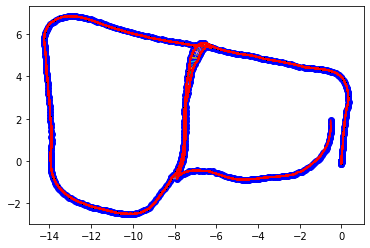

|dX| for step 1 : 0.09226658195257187

linearize and build system


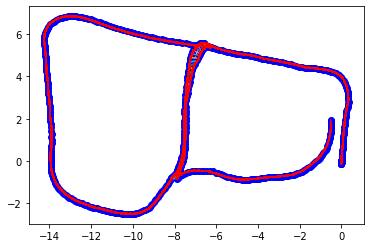

|dX| for step 2 : 0.09190712869167328

linearize and build system


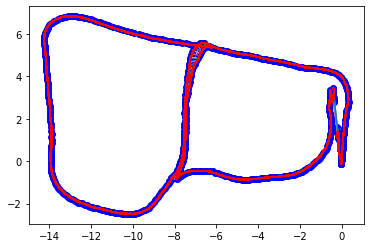

|dX| for step 0 : 5.979381561279297

linearize and build system


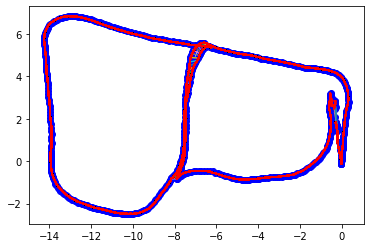

|dX| for step 1 : 2.365105152130127

linearize and build system


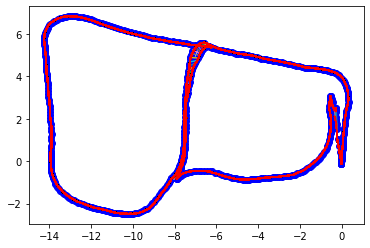

|dX| for step 2 : 1.0844100713729858

linearize and build system


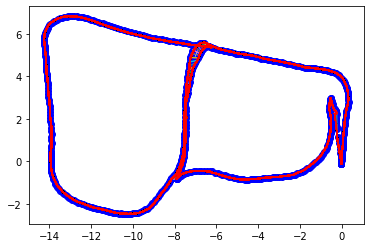

|dX| for step 3 : 0.5832990407943726

linearize and build system


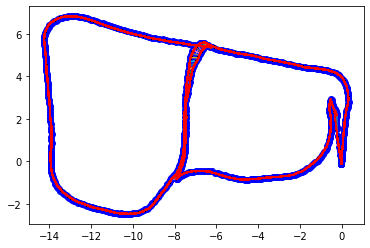

|dX| for step 4 : 0.3801480531692505

linearize and build system


KeyboardInterrupt: ignored

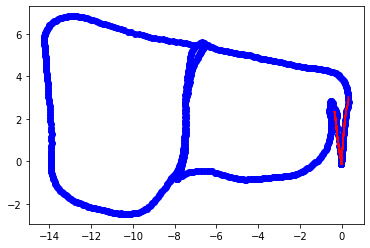

In [ ]:
pc_grad=gradslam.Pointclouds(lasers[:1700],normals[:1700])
slam=grad_lidar(iterations=2)
slam.forward(pc_grad,lasers,odoms)

/content


In [ ]:
!python drive/MyDrive/GradLidar1/utils/evaluate_ate.py gt_2.txt inf_2.txt --plot file.jpg

0.571719


In [ ]:
ls

'184091 (1).pdf'
 184091.ECD-311.pdf
 184091_ECD322_Assignment.pdf
'184091 NMOS.tanner'
 184091.pdf
 184091_Undertaking_TPO.pdf
 Chandu-merged-pages-deleted.pdf
 Classroom/
'CMOS transfer characteristics.tanner'
'Colab Notebooks'/
'Copy of Copy of LAB REPORT.docx'
'DSLR + GradSLAM'@
'Electronics & Communication Engineering-pages-deleted-merged.pdf'
 EXP-4.pdf
 EXP-6.pdf
'EXP-7(1).pdf'
 EXP-8.pdf
 EXP-9.pdf
'final resume'/
 groundTruth.csv
 images.zip
'NAND using CMOS.tanner'
'NOR using CMOS (1).tanner'
'NOR using CMOS.tanner'
'Pickle dataset'@
'$R4JEOQB.pdf'
 Resume_Layout_TPO.docx
'$RT33ZNP.pdf'
 Tambola_Get_Your_Ticket.xlsx
'Untitled Jam.gjam'
'WhatsApp Image 2021-08-28 at 9.14.29 PM.jpeg'
'XOR using CMOS.tanner'


Traceback (most recent call last):
  File "GradLidar1/utils/evaluate_ate.py", line 129, in <module>
    first_list = associate.read_file_list(args.first_file)
  File "/content/drive/.shortcut-targets-by-id/1VmfQGwfZqr7a9Bmtj-HCxnpyE4zZJvLZ/GradLidar1/utils/associate.py", line 64, in read_file_list
    file = open(filename)
FileNotFoundError: [Errno 2] No such file or directory: 'gt_2.txt'


GN solver Gradient explosion Case

Values of gradient to be noted

linearize and build system


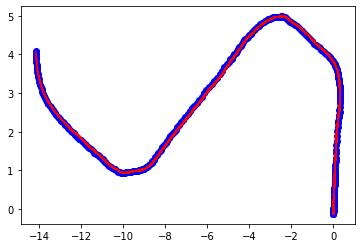

|dX| for step 0 : 0.30317187309265137

linearize and build system


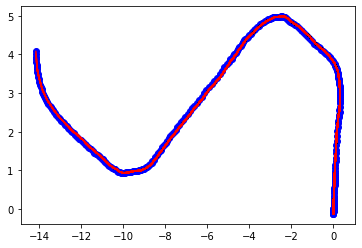

|dX| for step 1 : 0.0005347743281163275

linearize and build system


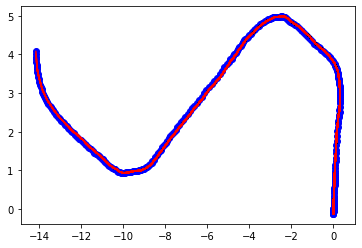

|dX| for step 2 : 8.766900464252103e-06

linearize and build system


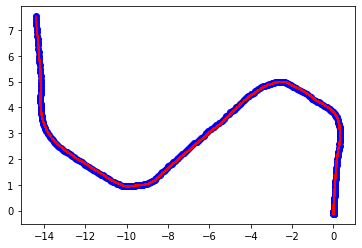

|dX| for step 0 : 0.0008037694497033954

linearize and build system


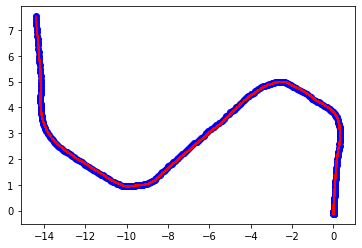

|dX| for step 1 : 4.7260696192097384e-06

linearize and build system


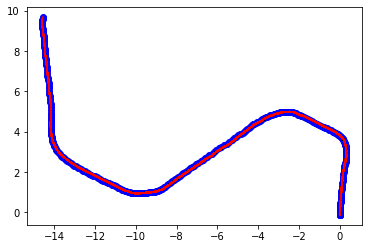

|dX| for step 0 : 0.0006324359565041959

linearize and build system


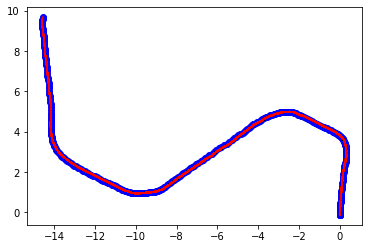

|dX| for step 1 : 4.720201104646549e-06

linearize and build system


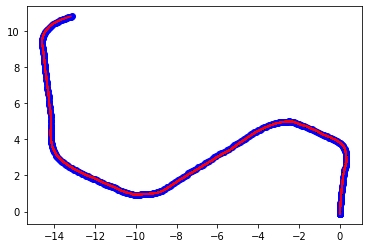

|dX| for step 0 : 0.0007928849663585424

linearize and build system


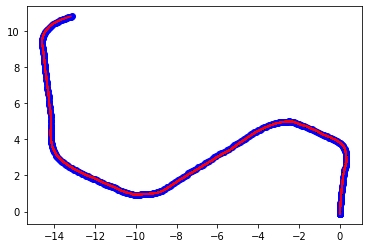

|dX| for step 1 : 7.836646545911208e-06

linearize and build system


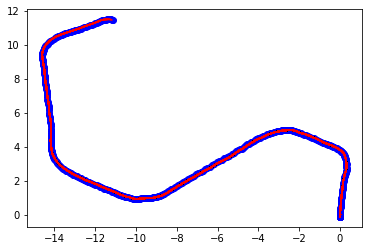

|dX| for step 0 : 0.0007103284006007016

linearize and build system


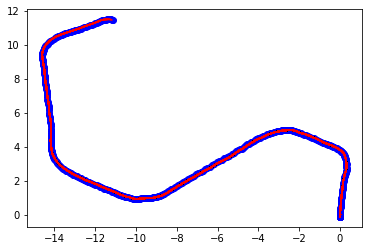

|dX| for step 1 : 5.9848730415978935e-06

linearize and build system


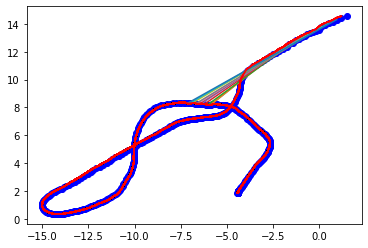

|dX| for step 0 : 117.81035614013672

linearize and build system


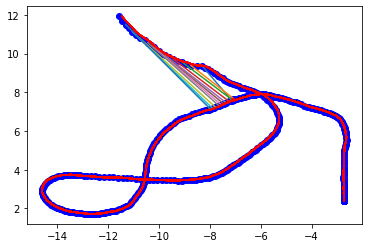

|dX| for step 1 : 62.3941650390625

linearize and build system


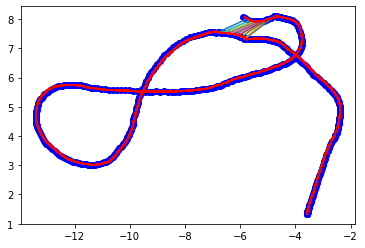

|dX| for step 2 : 45.89058303833008

linearize and build system


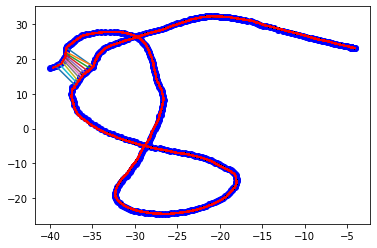

|dX| for step 3 : 624.9618530273438

linearize and build system


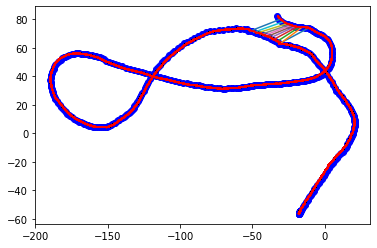

|dX| for step 4 : 1980.360107421875

linearize and build system


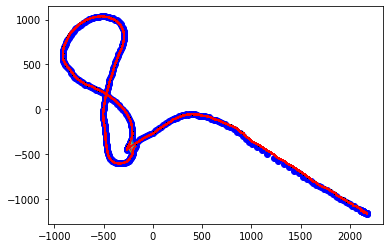

|dX| for step 5 : 23729.5078125

linearize and build system


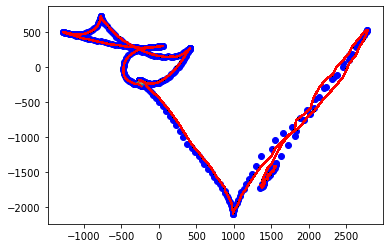

|dX| for step 6 : 19484.0546875

linearize and build system


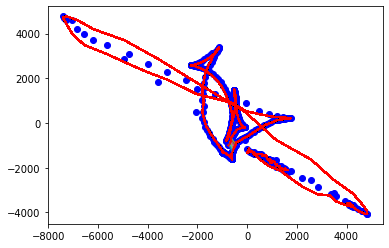

|dX| for step 7 : 49211.7421875

linearize and build system


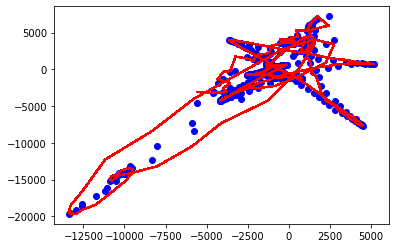

|dX| for step 8 : 122221.8359375

linearize and build system


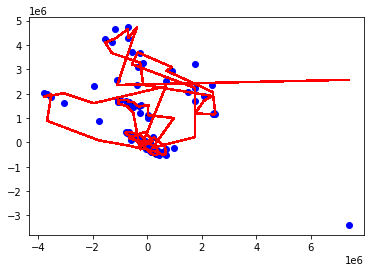

|dX| for step 9 : 21344922.0

linearize and build system


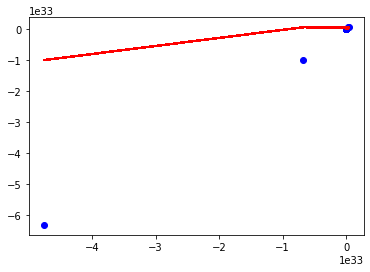

|dX| for step 10 : nan

linearize and build system


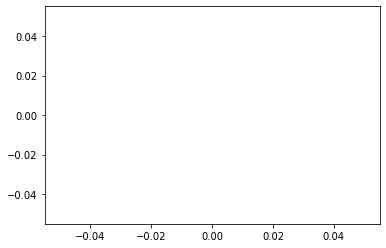

|dX| for step 11 : nan

linearize and build system


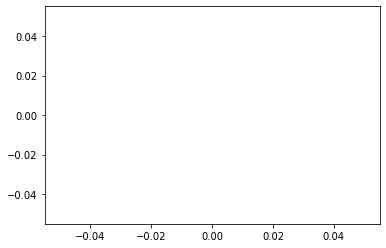

|dX| for step 12 : nan

linearize and build system


KeyboardInterrupt: ignored

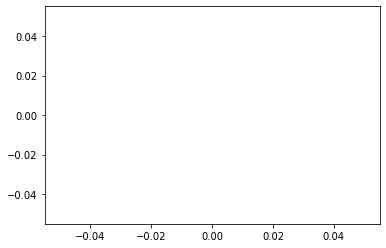

In [ ]:
pc_grad=gradslam.Pointclouds(lasers,normals)
slam=grad_lidar(iterations=2)
slam.forward(pc_grad,lasers)

LM Solver Gradient Values

Values to be noted

linearize and build system


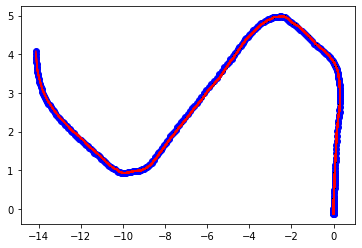

|dX| for step 0 : 0.005016445182263851

linearize and build system


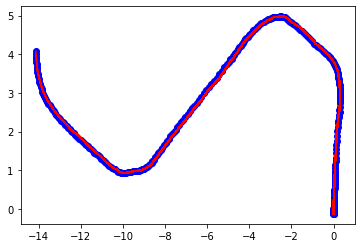

|dX| for step 1 : 0.0035219858400523663

linearize and build system


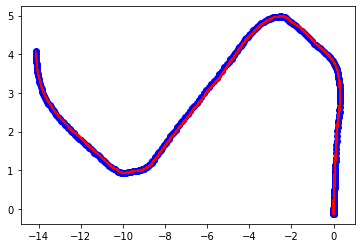

|dX| for step 2 : 0.0031137270852923393

linearize and build system


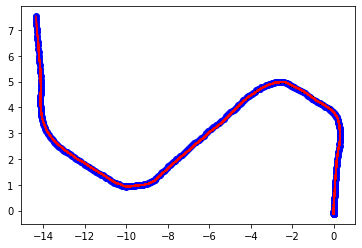

|dX| for step 0 : 0.0028717471286654472

linearize and build system


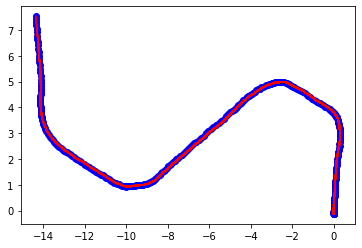

|dX| for step 1 : 0.0026049590669572353

linearize and build system


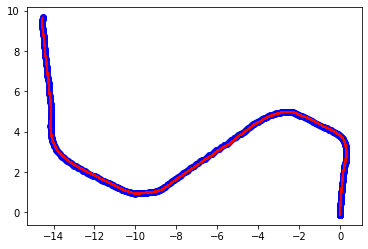

|dX| for step 0 : 0.002411670284345746

linearize and build system


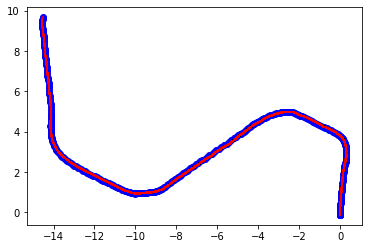

|dX| for step 1 : 0.0022379655856639147

linearize and build system


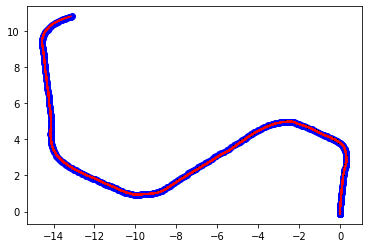

|dX| for step 0 : 0.002085670130327344

linearize and build system


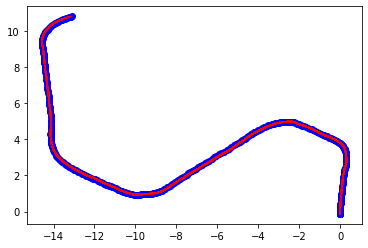

|dX| for step 1 : 0.0019446945516392589

linearize and build system


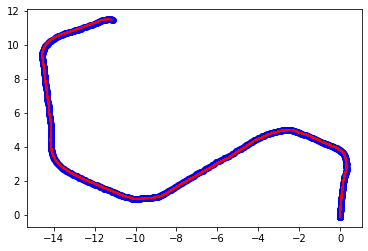

|dX| for step 0 : 0.0018291064770892262

linearize and build system


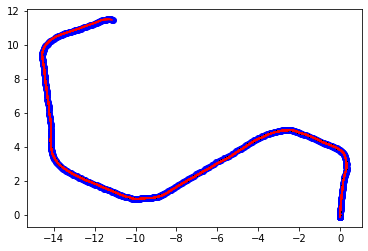

|dX| for step 1 : 0.001704953145235777

linearize and build system


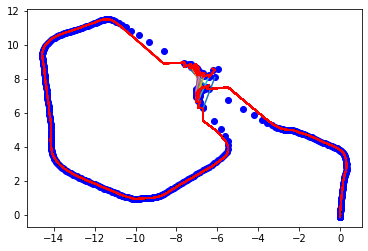

|dX| for step 0 : 31.329099655151367

linearize and build system


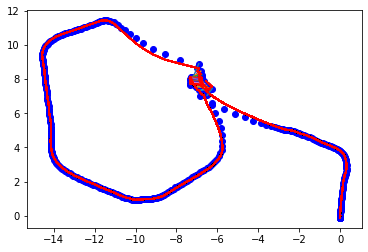

|dX| for step 1 : 7.662418842315674

linearize and build system


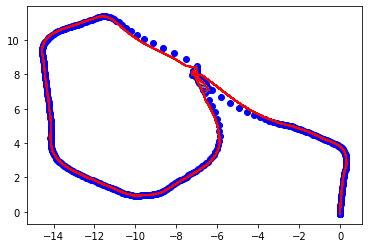

|dX| for step 2 : 2.895995616912842

linearize and build system


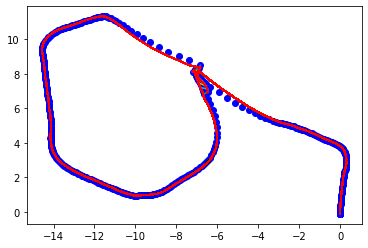

|dX| for step 3 : 1.945675253868103

linearize and build system


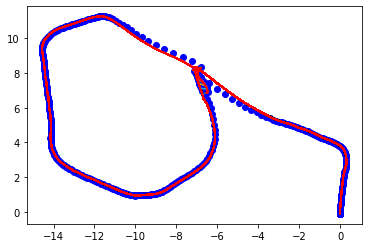

|dX| for step 4 : 1.5808414220809937

linearize and build system


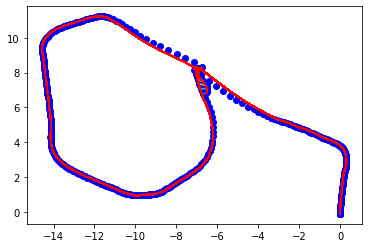

|dX| for step 5 : 1.3595867156982422

linearize and build system


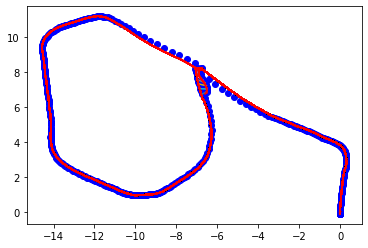

|dX| for step 6 : 1.1935497522354126

linearize and build system


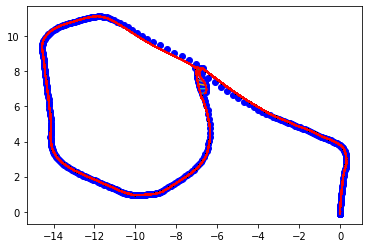

|dX| for step 7 : 1.066684603691101

linearize and build system


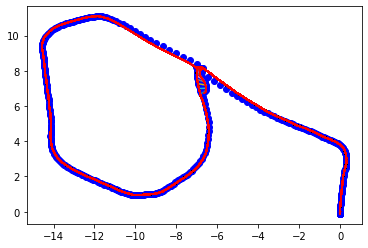

|dX| for step 8 : 0.9667741656303406

linearize and build system


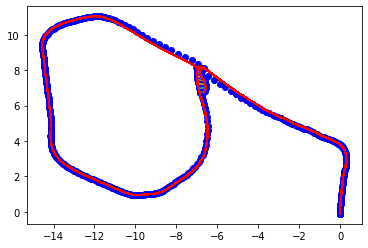

|dX| for step 9 : 0.8847641348838806

linearize and build system


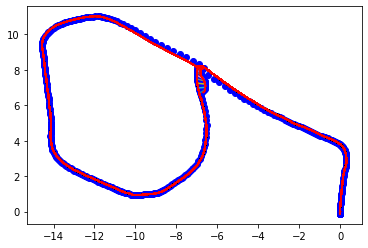

|dX| for step 10 : 0.8182490468025208

linearize and build system


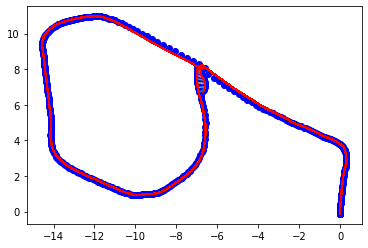

|dX| for step 11 : 0.7590518593788147

linearize and build system


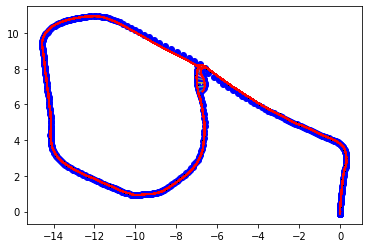

|dX| for step 12 : 0.7115235328674316

linearize and build system


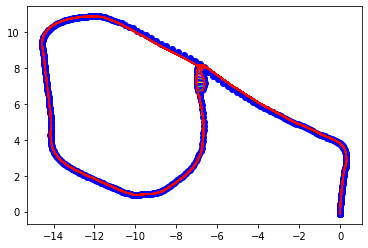

|dX| for step 13 : 0.6702950596809387

linearize and build system


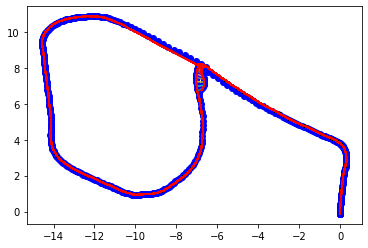

|dX| for step 14 : 0.6347927451133728

linearize and build system


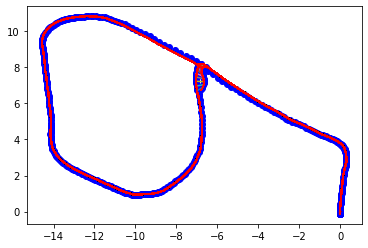

|dX| for step 15 : 0.6041543483734131

linearize and build system


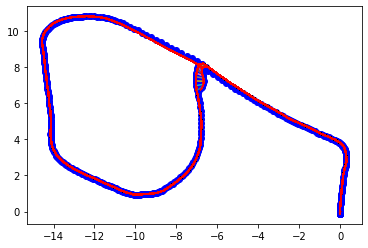

|dX| for step 16 : 0.5758598446846008

linearize and build system


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
pc_grad=gradslam.Pointclouds(lasers,normals)
slam=grad_lidar(iterations=2)
slam.forward(pc_grad,lasers)

In [ ]:
def np_to_txt(time_stamp,pos,quat):
    "This function convers group of numpy array into a string as stecified in the format of the ate and rpe evalusation file"

    str = np.str(time_stamp)+np.array_str(pos)+ np.array_str(quat)
    str=str.replace("["," ")
    str =str.replace("]"," ")
    str =str.strip()
    str = " ".join(str.split())
    # print(str)
    return str

class grad_lidar(nn.Module):
    def __init__(self,iterations=10, device = "cuda"):
        super(grad_lidar, self).__init__()
        self.iterations = iterations
        self.device = device
        self.odomprov = GradICPOdometryProvider ( self.iterations , 1e-8, lambda_max=2.0, B=1.0, B2=1.0, nu=200.0 )
        self.all_lasers=[]
        self.g=Graph()
        self.offset=0
        self.prev=0
    def forward(self,pc_grad,odoms,loop_closure=True):
        #odom_data : Consists of odometry data of the robot i.e poses of the robot
        #pc_grad   : Consists of lidar scans for each and every pose in gradslam pointcloud datatype


        poses=[torch.eye(4, dtype=torch.float, device = self.device).view(1,1,4,4)]  # list containing poses of nodes
        vertex_idx=1
        poseeuler=rotationMatrixToEulerAngles(torch.squeeze(poses[-1])[:3,:3])       #Converting init orientation to euler angles
        pose=torch.concat((poses[-1].squeeze()[:2,3],poseeuler[2].unsqueeze(0)))
        self.g.add_vertex(vertex_idx,pose)                                           # adding first vertex

        for od_idx,odom in enumerate(odoms):

            if od_idx==0:
                prev_odom=odom
                prev_idx=0
                self.all_lasers.append(pc_grad[prev_idx])
                continue
            if od_idx%2==0:
                pcd1=pc_grad[prev_idx]

                pcd2=pc_grad[od_idx]
                vertex_idx+=1

                transform=self.odomprov.provide(pcd1,pcd2)                            # finding transform using ICP form gradslam

                pcd_pose = compose_transformations(poses[-1].squeeze(1),transform.squeeze(1)).unsqueeze(1)
                poses.append(pcd_pose)
                pose=Convert_to_pose(poses[-1].squeeze())
                T=Convert_to_pose(transform.squeeze())
                self.g.add_vertex(vertex_idx,pose)                                        #Adding the vertex
                self.g.add_edge("P",vertex_idx-1,vertex_idx,T,torch.eye(3,device="cuda")) # Adding the edge


                prev_odm=odom
                prev_idx=od_idx
                self.all_lasers.append(pcd2)


                if vertex_idx>50 and vertex_idx%30==0:                                 # If the number of nodes> 50 then find loop clousure and optimize pose graph
                  if loop_closure:
                      find_loop_clousure(pose,vertex_idx,self.all_lasers,self.g)
                  for i,j in enumerate(list(self.g.loc.keys())[self.prev:vertex_idx]):    # Here g.x is flattened vector of all poses of the nodes
                    self.g.lut.update({j:self.offset})
                    self.offset=self.offset+len(self.g.loc[j])                            # g.lut is a dictionary which contains starting and ending index of pose for each node
                    if self.g.x==None:
                      self.g.x=self.g.loc[j]
                    else:
                      self.g.x=torch.cat((self.g.x,self.g.loc[j]))
                  #plot_graph(self.g)
                  err_dlr=run_graph_slam(self.g,100)                                      # running pose graph optimization for 100 iterations
                  self.prev=vertex_idx

        gt_file = open("gt_2.txt",'w')
        inf_file = open("inf_2.txt",'w')

        up_poses=[i for i in [self.g.x[j:j+3] for j in range(0,len(self.g.x),3)]]
        updated_poses=[]
        for i,p in enumerate(up_poses):
          r = R.from_euler('zyx', odoms[i][2] , degrees = True).as_quat()
          gt_file.write(np_to_txt(odoms[i][0],np.array(odoms[i][1]),np.array(r))+"\n")
          # print(p[2].cpu().numpy())
          r_inf = R.from_euler('zyx', p[2].detach().cpu().numpy() , degrees = True).as_quat()
          inf_file.write(np_to_txt(odoms[i][0],np.array([p[0],p[1],0])),np.array(r_inf)+"\n")
          R=eul2rot(p[2])
          m=torch.eye(4, dtype=torch.float,device="cuda")
          m[:3,:3]=R
          m[0][3]=p[0]
          m[1][3]=p[1]
          updated_poses.append(m.view(1,1,4,4))
        poses=updated_poses

        gt_file.close()
        inf_file.close()

linearize and build system


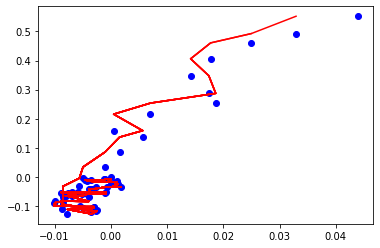

|dX| for step 0 : 9.403888543602079e-05

linearize and build system


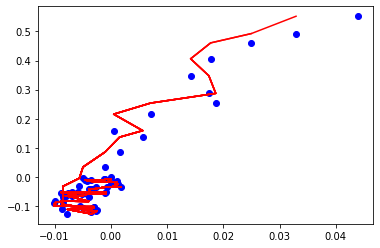

|dX| for step 1 : 3.062890755245462e-05

linearize and build system


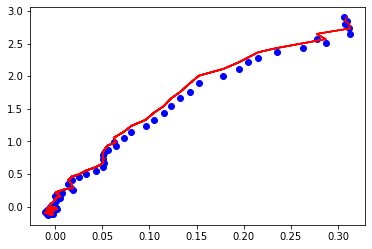

|dX| for step 0 : 0.00011672099935822189

linearize and build system


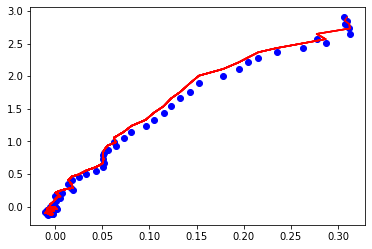

|dX| for step 1 : 4.451632412383333e-05

linearize and build system


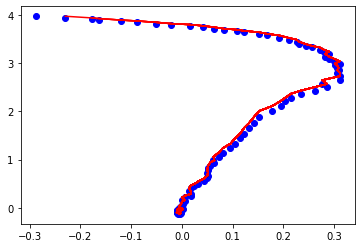

|dX| for step 0 : 0.00019681730191223323

linearize and build system


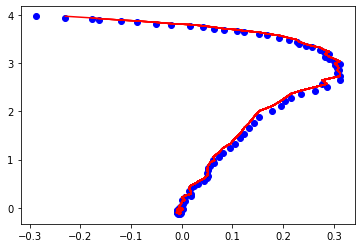

|dX| for step 1 : 6.354917422868311e-05

linearize and build system


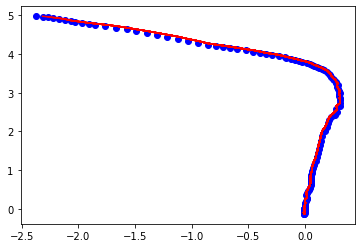

|dX| for step 0 : 0.00039409910095855594

linearize and build system


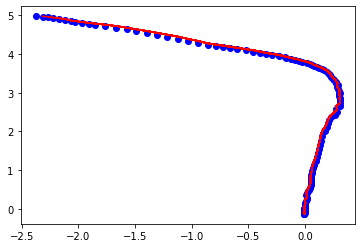

|dX| for step 1 : 0.00015233155863825232

linearize and build system


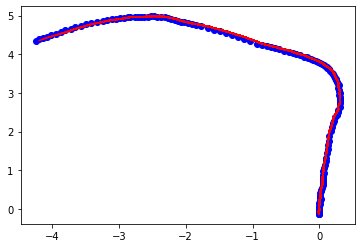

|dX| for step 0 : 0.0006689512520097196

linearize and build system


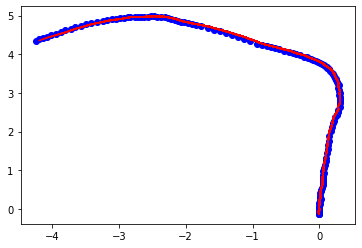

|dX| for step 1 : 0.0004137210198678076

linearize and build system


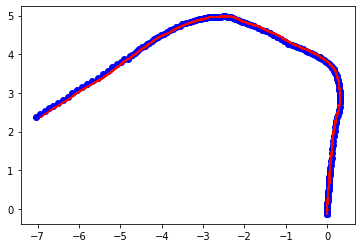

|dX| for step 0 : 0.0014892308972775936

linearize and build system


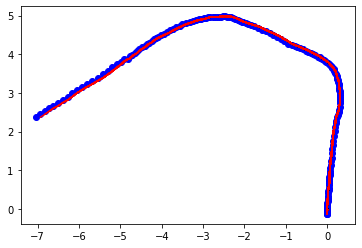

|dX| for step 1 : 0.0008012594189494848

linearize and build system


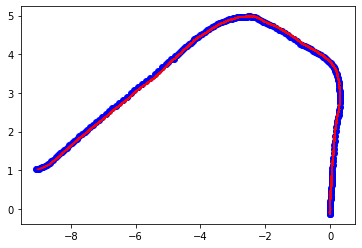

|dX| for step 0 : 0.0014406967675313354

linearize and build system


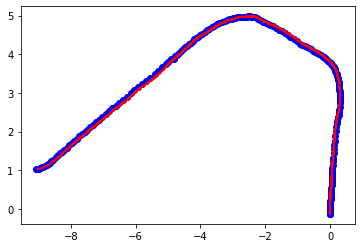

|dX| for step 1 : 0.0007111596642062068

linearize and build system


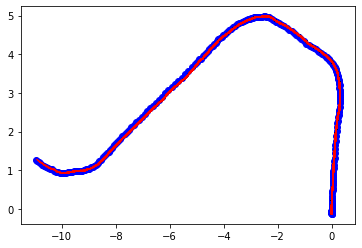

|dX| for step 0 : 0.0013182066613808274

linearize and build system


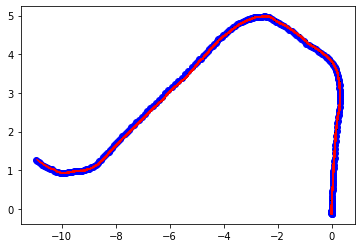

|dX| for step 1 : 0.0008087276946753263

linearize and build system


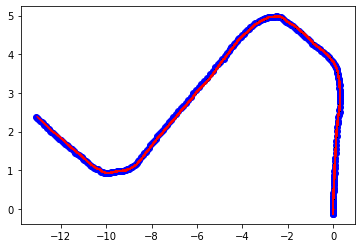

|dX| for step 0 : 0.0024842391721904278

linearize and build system


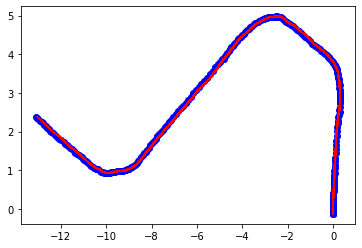

|dX| for step 1 : 0.0012745041167363524

linearize and build system


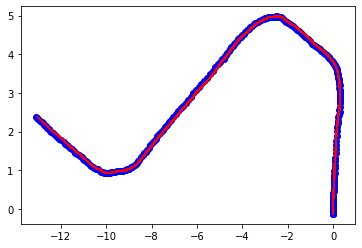

|dX| for step 2 : 0.0010735337855294347

linearize and build system


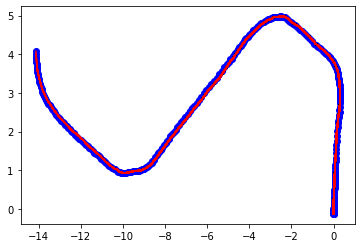

|dX| for step 0 : 0.0020274692215025425

linearize and build system


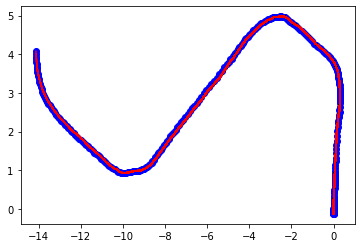

|dX| for step 1 : 0.001099511981010437

linearize and build system


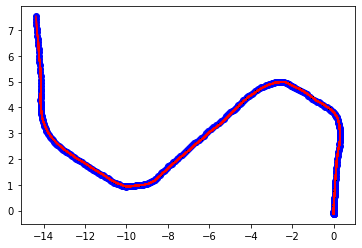

|dX| for step 0 : 0.0016999307554215193

linearize and build system


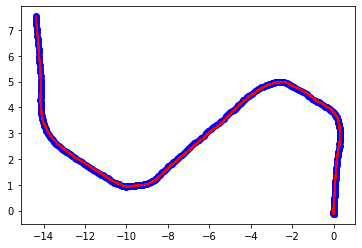

|dX| for step 1 : 0.0011325898813083768

linearize and build system


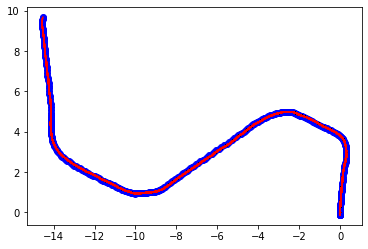

|dX| for step 0 : 0.0018765132408589125

linearize and build system


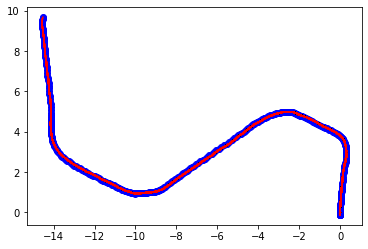

|dX| for step 1 : 0.0011866026325151324

linearize and build system


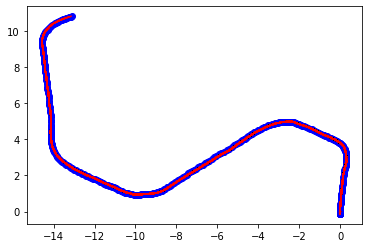

|dX| for step 0 : 0.002066149143502116

linearize and build system


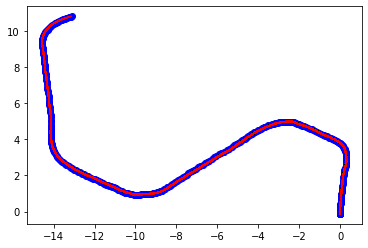

|dX| for step 1 : 0.0012988169910386205

linearize and build system


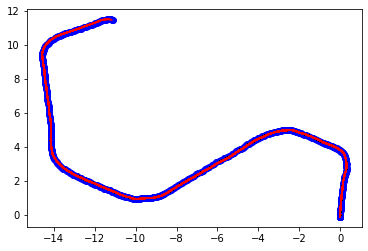

|dX| for step 0 : 0.002050549490377307

linearize and build system


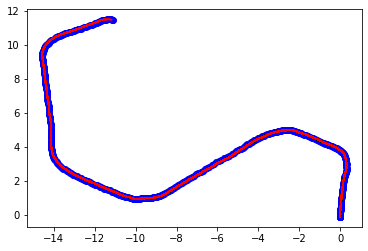

|dX| for step 1 : 0.0013599323574453592

linearize and build system


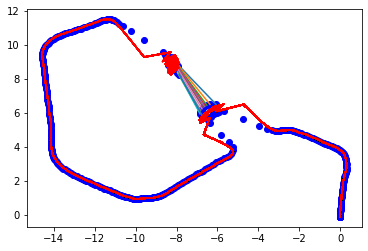

|dX| for step 0 : 21.23422622680664

linearize and build system


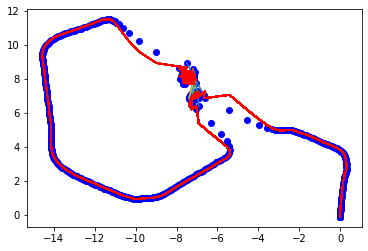

|dX| for step 1 : 8.717257499694824

linearize and build system


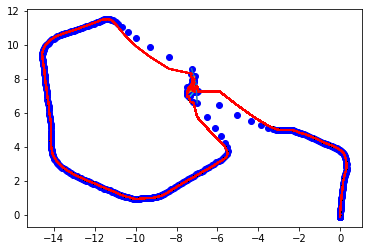

|dX| for step 2 : 4.42930269241333

linearize and build system


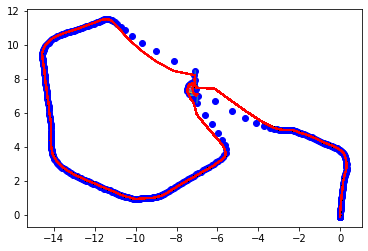

|dX| for step 3 : 2.2937533855438232

linearize and build system


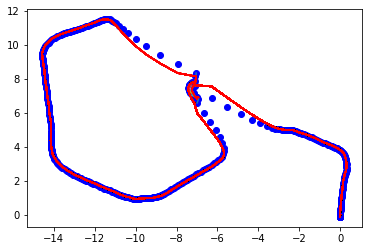

|dX| for step 4 : 1.4269099235534668

linearize and build system


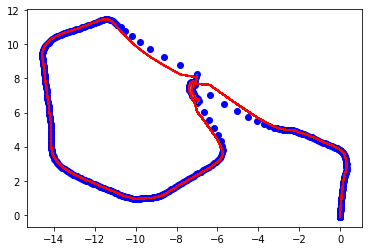

|dX| for step 5 : 1.0780744552612305

linearize and build system


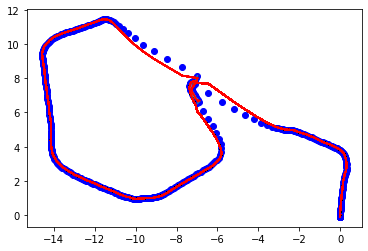

|dX| for step 6 : 0.9033796191215515

linearize and build system


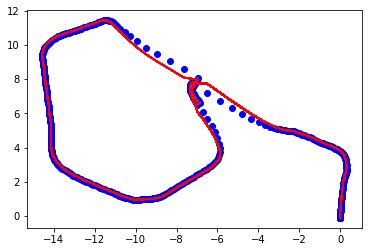

|dX| for step 7 : 0.799551248550415

linearize and build system


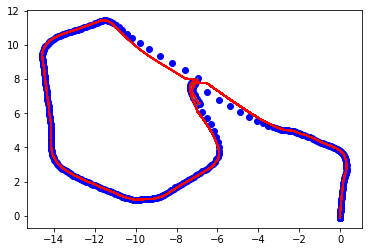

|dX| for step 8 : 0.7220804691314697

linearize and build system


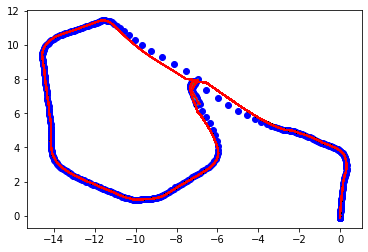

|dX| for step 9 : 0.6595603823661804

linearize and build system


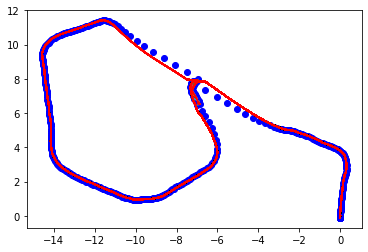

|dX| for step 10 : 0.6106173992156982

linearize and build system


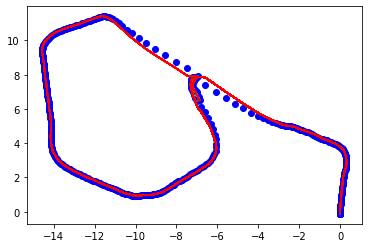

|dX| for step 11 : 0.5695551037788391

linearize and build system


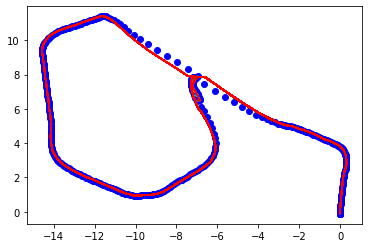

|dX| for step 12 : 0.5342402458190918

linearize and build system


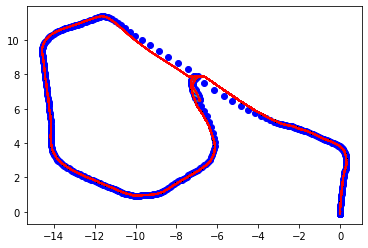

|dX| for step 13 : 0.5021109580993652

linearize and build system


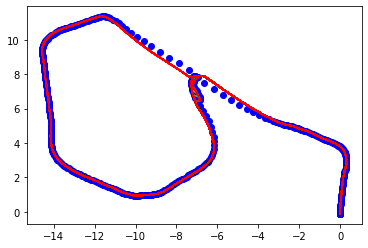

|dX| for step 14 : 0.47437822818756104

linearize and build system


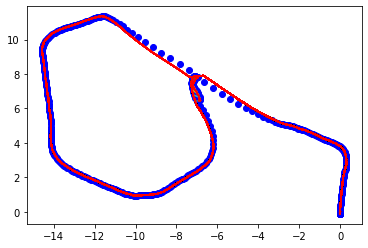

|dX| for step 15 : 0.45016008615493774

linearize and build system


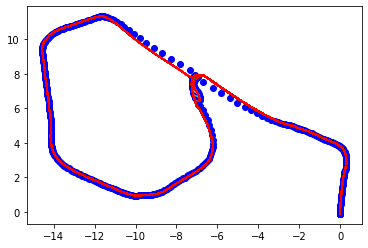

|dX| for step 16 : 0.428577721118927

linearize and build system


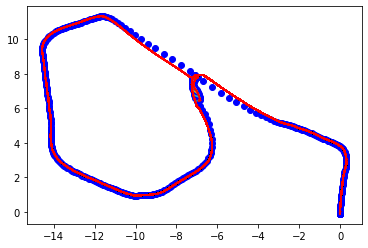

|dX| for step 17 : 0.40887123346328735

linearize and build system


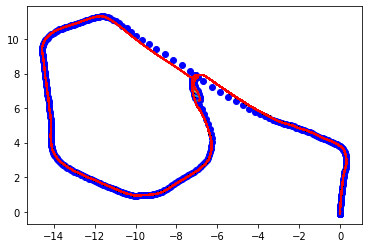

|dX| for step 18 : 0.3946603238582611

linearize and build system


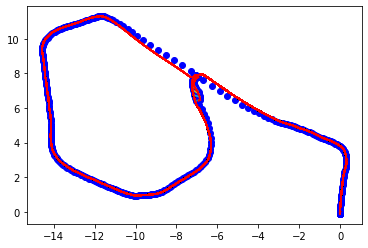

|dX| for step 19 : 0.3747996687889099

linearize and build system


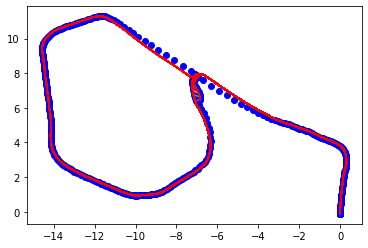

|dX| for step 20 : 0.35999903082847595

linearize and build system


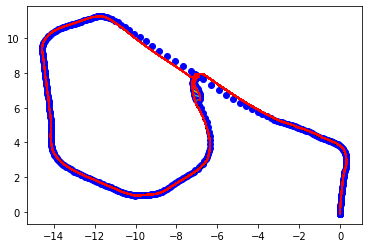

|dX| for step 21 : 0.3464246988296509

linearize and build system


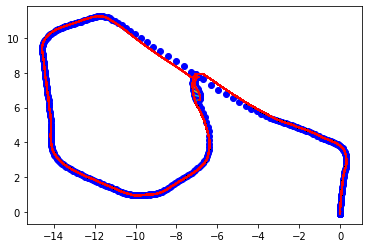

|dX| for step 22 : 0.33439353108406067

linearize and build system


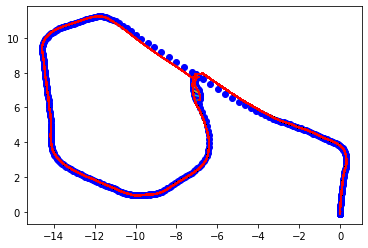

|dX| for step 23 : 0.32225701212882996

linearize and build system


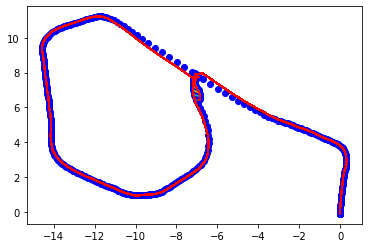

|dX| for step 24 : 0.31156277656555176

linearize and build system


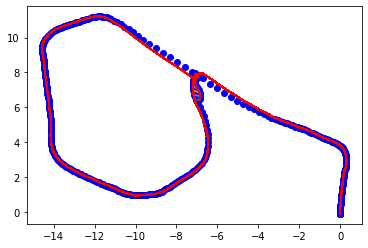

|dX| for step 25 : 0.30165860056877136

linearize and build system


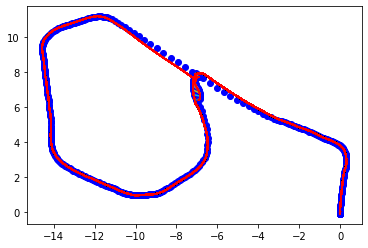

|dX| for step 26 : 0.29225975275039673

linearize and build system


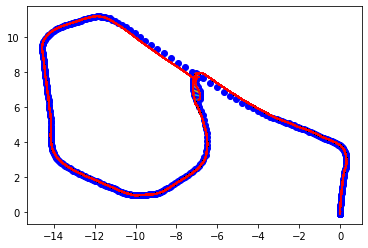

|dX| for step 27 : 0.2835858464241028

linearize and build system


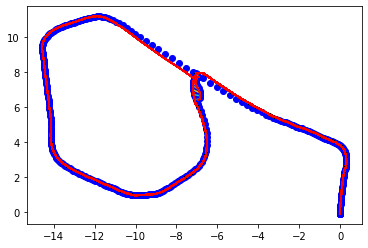

|dX| for step 28 : 0.27543720602989197

linearize and build system


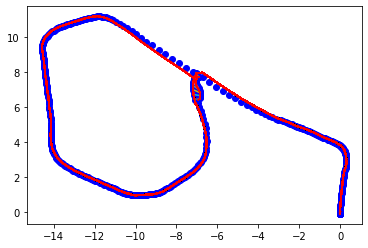

|dX| for step 29 : 0.26794499158859253

linearize and build system


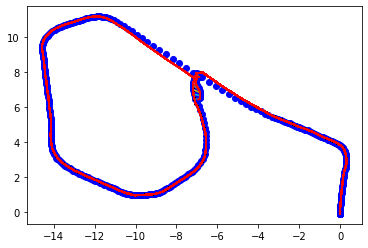

|dX| for step 30 : 0.26072418689727783

linearize and build system


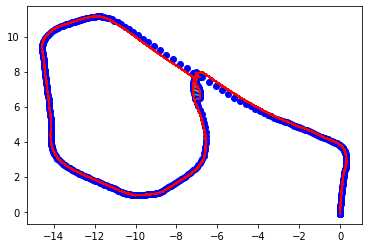

|dX| for step 31 : 0.25423240661621094

linearize and build system


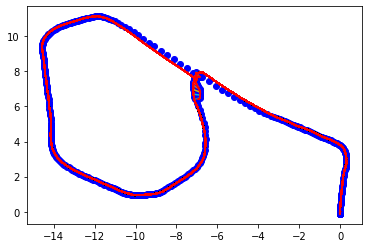

|dX| for step 32 : 0.24770775437355042

linearize and build system


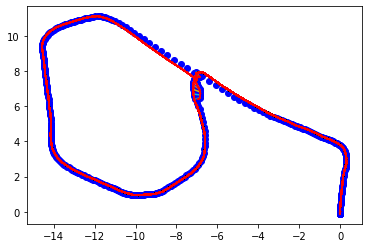

|dX| for step 33 : 0.24184797704219818

linearize and build system


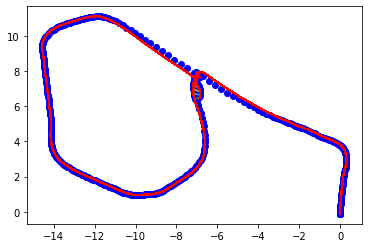

|dX| for step 34 : 0.23611903190612793

linearize and build system


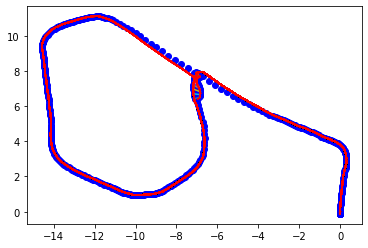

|dX| for step 35 : 0.23050040006637573

linearize and build system


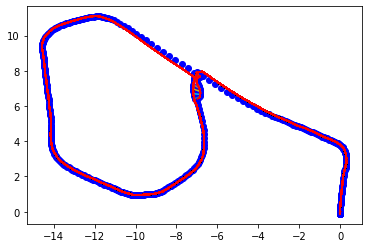

|dX| for step 36 : 0.22543521225452423

linearize and build system


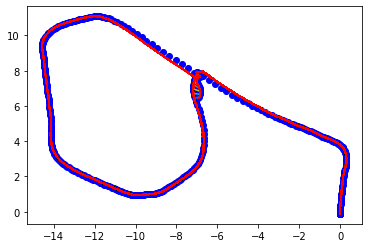

|dX| for step 37 : 0.22074657678604126

linearize and build system


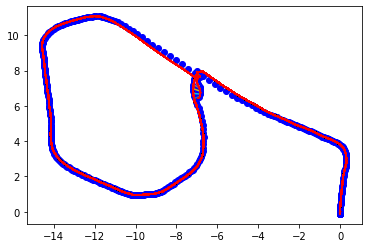

|dX| for step 38 : 0.21630460023880005

linearize and build system


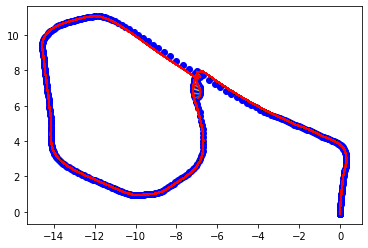

|dX| for step 39 : 0.2118600308895111

linearize and build system


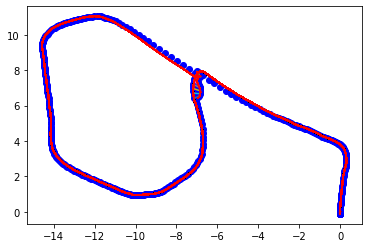

|dX| for step 40 : 0.20748655498027802

linearize and build system


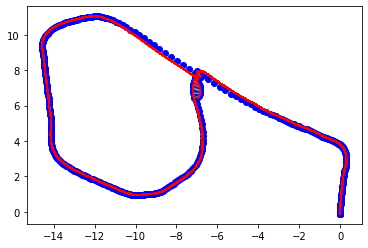

|dX| for step 41 : 0.2036876529455185

linearize and build system


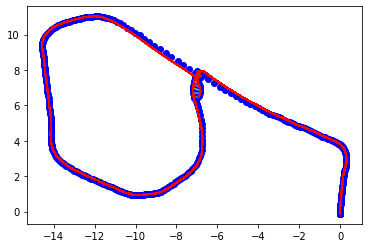

|dX| for step 42 : 0.19973072409629822

linearize and build system


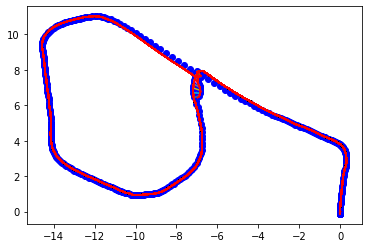

|dX| for step 43 : 0.1963575780391693

linearize and build system


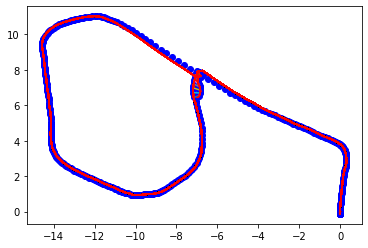

|dX| for step 44 : 0.19299675524234772

linearize and build system


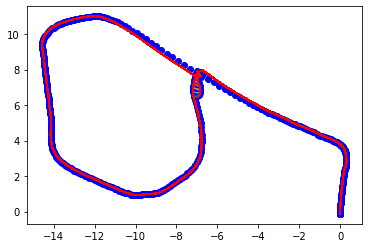

|dX| for step 45 : 0.1900055706501007

linearize and build system


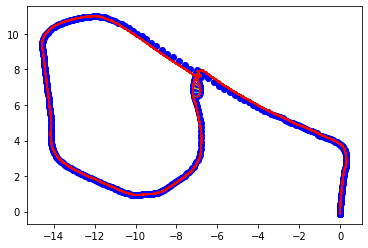

|dX| for step 46 : 0.18666361272335052

linearize and build system


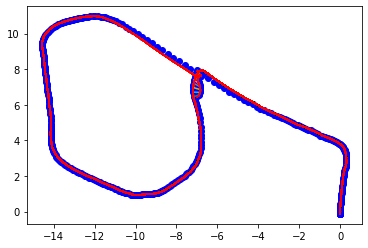

|dX| for step 47 : 0.1843463033437729

linearize and build system


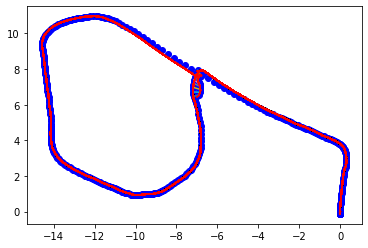

|dX| for step 48 : 0.18041156232357025

linearize and build system


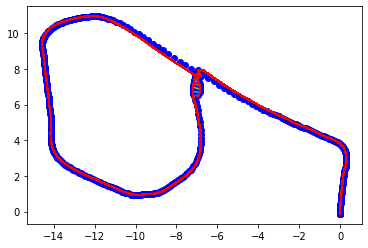

|dX| for step 49 : 0.17767883837223053

linearize and build system


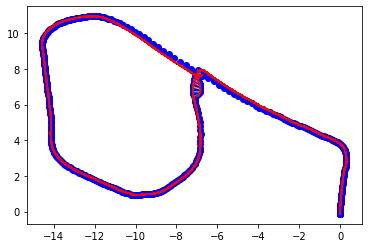

|dX| for step 50 : 0.17489777505397797

linearize and build system


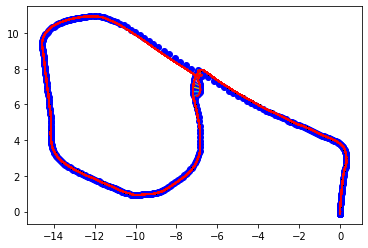

|dX| for step 51 : 0.1732831597328186

linearize and build system


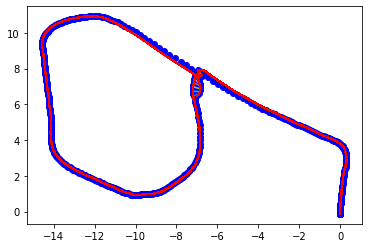

|dX| for step 52 : 0.16973906755447388

linearize and build system


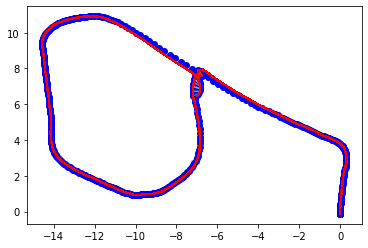

|dX| for step 53 : 0.16743813455104828

linearize and build system


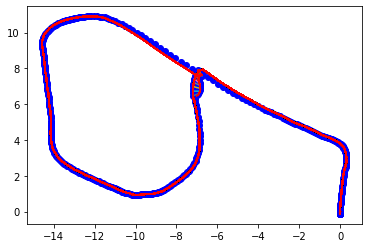

|dX| for step 54 : 0.16505756974220276

linearize and build system


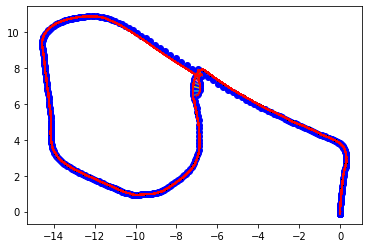

|dX| for step 55 : 0.16275116801261902

linearize and build system


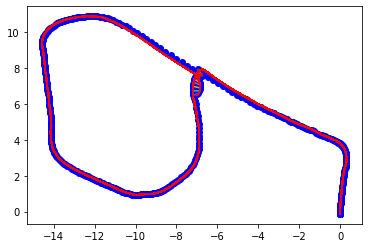

|dX| for step 56 : 0.16080616414546967

linearize and build system


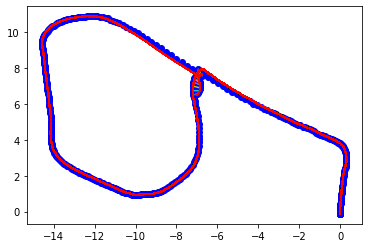

|dX| for step 57 : 0.1588209867477417

linearize and build system


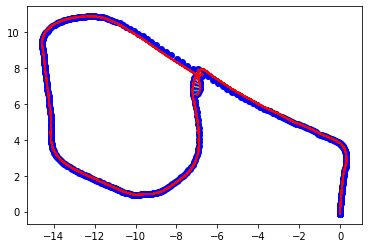

|dX| for step 58 : 0.15674401819705963

linearize and build system


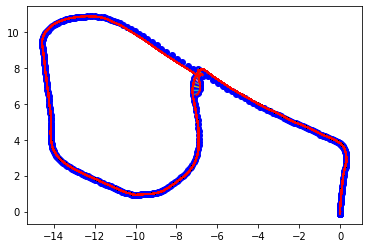

|dX| for step 59 : 0.15830448269844055

linearize and build system


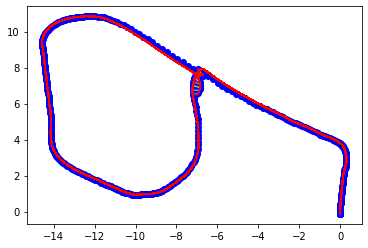

|dX| for step 60 : 0.1527462899684906

linearize and build system


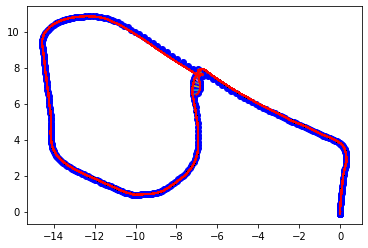

|dX| for step 61 : 0.15081733465194702

linearize and build system


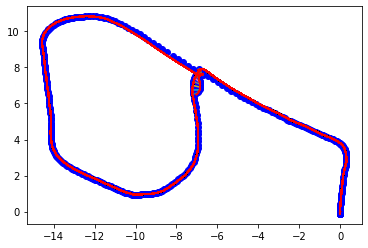

|dX| for step 62 : 0.14904703199863434

linearize and build system


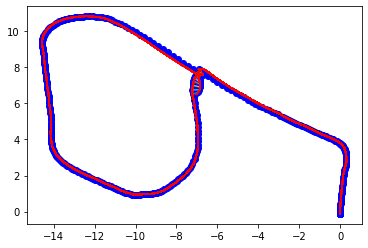

|dX| for step 63 : 0.14759843051433563

linearize and build system


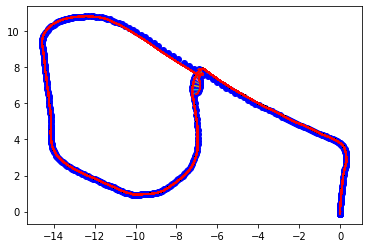

|dX| for step 64 : 0.14578069746494293

linearize and build system


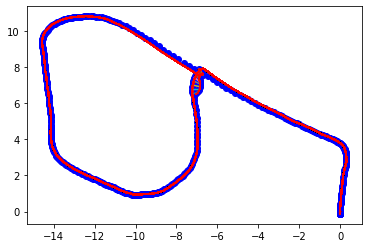

|dX| for step 65 : 0.14444096386432648

linearize and build system


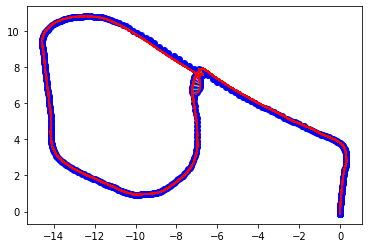

|dX| for step 66 : 0.14269520342350006

linearize and build system


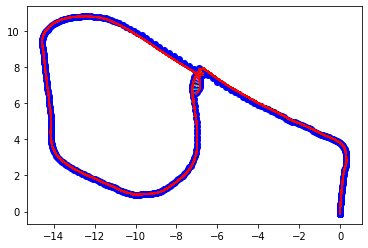

|dX| for step 67 : 0.14113540947437286

linearize and build system


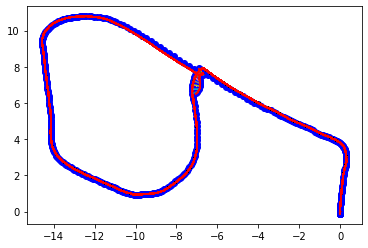

|dX| for step 68 : 0.14005689322948456

linearize and build system


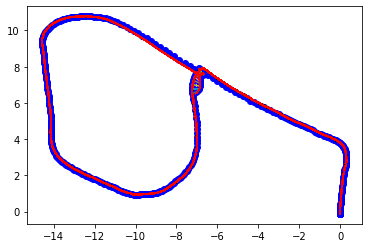

|dX| for step 69 : 0.13822291791439056

linearize and build system


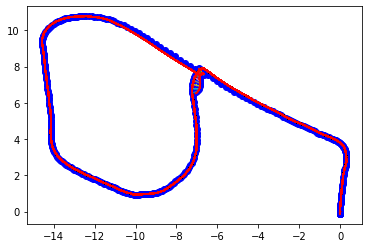

|dX| for step 70 : 0.13713371753692627

linearize and build system


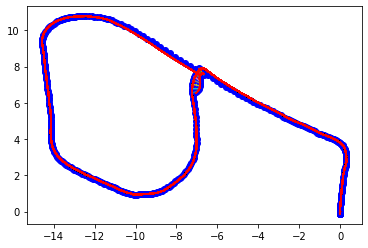

|dX| for step 71 : 0.13534872233867645

linearize and build system


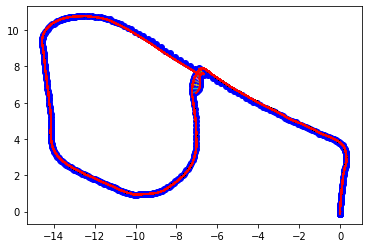

|dX| for step 72 : 0.13406749069690704

linearize and build system


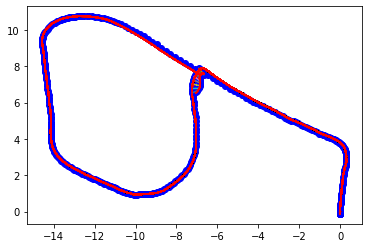

|dX| for step 73 : 0.13265889883041382

linearize and build system


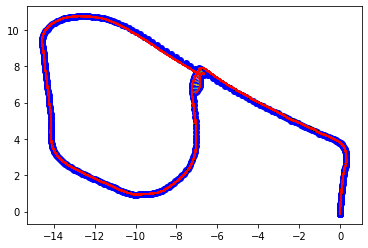

|dX| for step 74 : 0.13134987652301788

linearize and build system


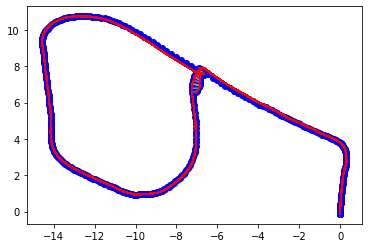

|dX| for step 75 : 0.13057121634483337

linearize and build system


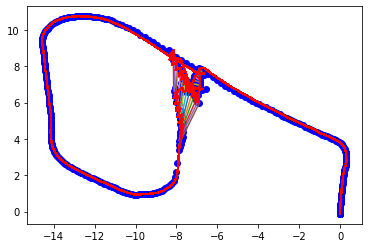

|dX| for step 0 : 17.893808364868164

linearize and build system


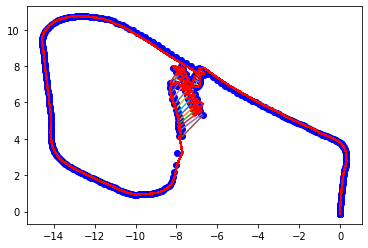

|dX| for step 1 : 7.9915690422058105

linearize and build system


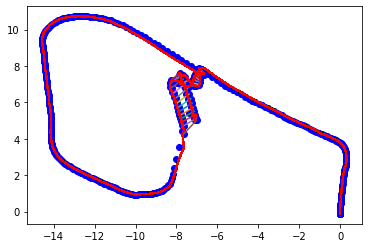

|dX| for step 2 : 3.9337503910064697

linearize and build system


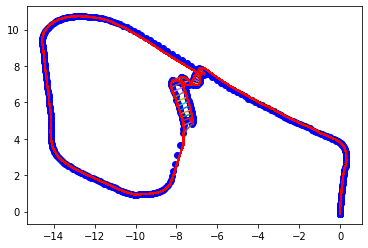

|dX| for step 3 : 1.9155247211456299

linearize and build system


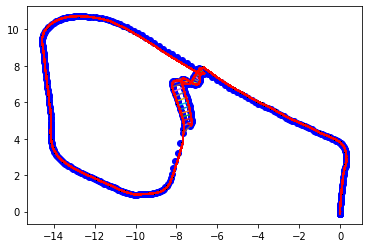

|dX| for step 4 : 1.0172632932662964

linearize and build system


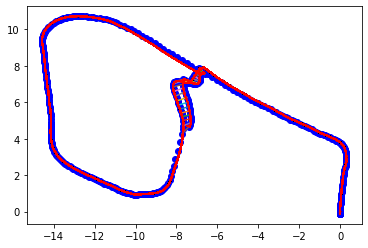

|dX| for step 5 : 0.6693440675735474

linearize and build system


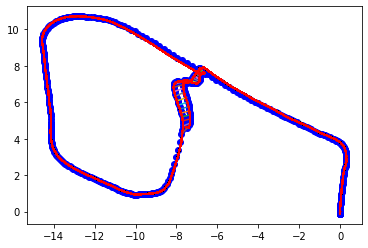

|dX| for step 6 : 0.5250585675239563

linearize and build system


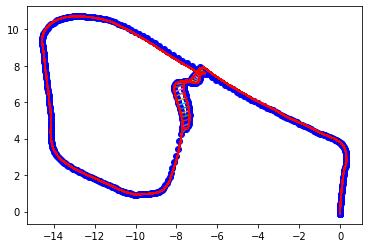

|dX| for step 7 : 0.44969919323921204

linearize and build system


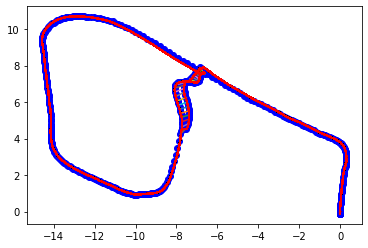

|dX| for step 8 : 0.4080375134944916

linearize and build system


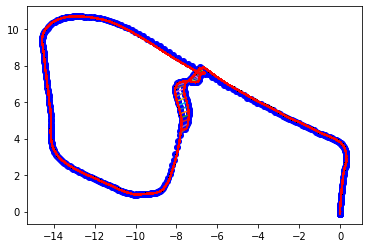

|dX| for step 9 : 0.3785587549209595

linearize and build system


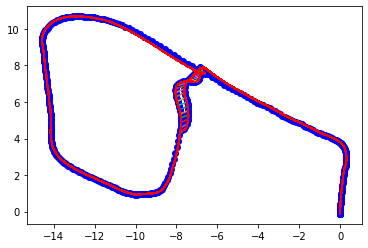

|dX| for step 10 : 0.3560972511768341

linearize and build system


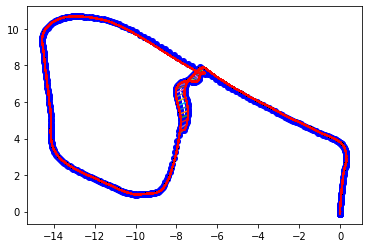

|dX| for step 11 : 0.33679473400115967

linearize and build system


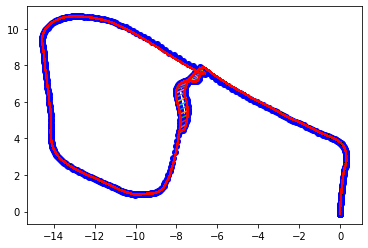

|dX| for step 12 : 0.32013198733329773

linearize and build system


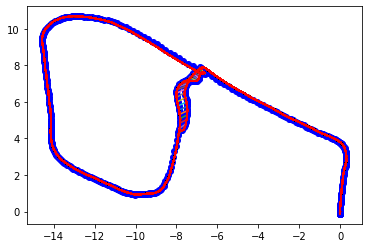

|dX| for step 13 : 0.3066701292991638

linearize and build system


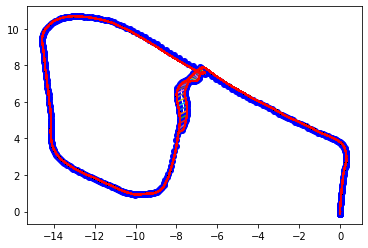

|dX| for step 14 : 0.29389432072639465

linearize and build system


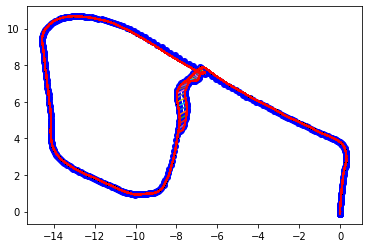

|dX| for step 15 : 0.28221750259399414

linearize and build system


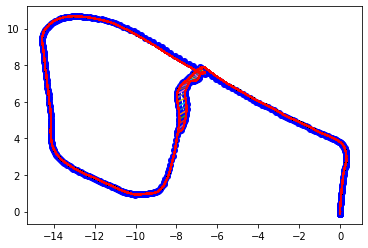

|dX| for step 16 : 0.27183496952056885

linearize and build system


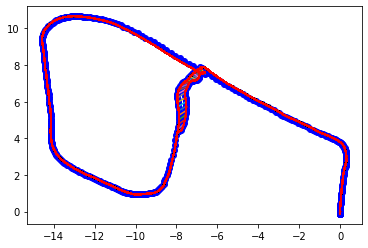

|dX| for step 17 : 0.26358914375305176

linearize and build system


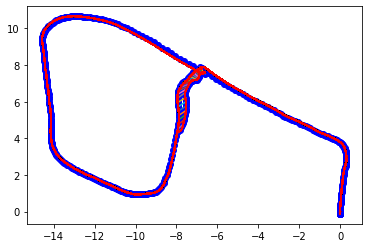

|dX| for step 18 : 0.25323954224586487

linearize and build system


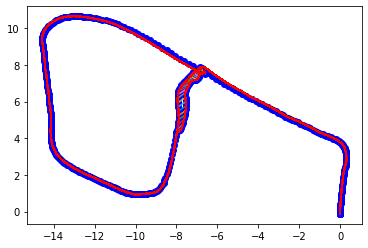

|dX| for step 19 : 0.24483701586723328

linearize and build system


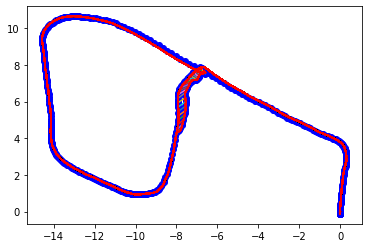

|dX| for step 20 : 0.23660238087177277

linearize and build system


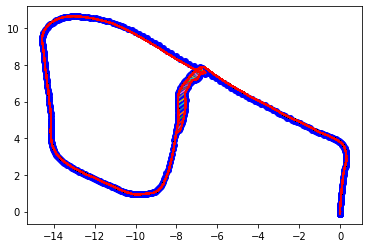

|dX| for step 21 : 0.22915372252464294

linearize and build system


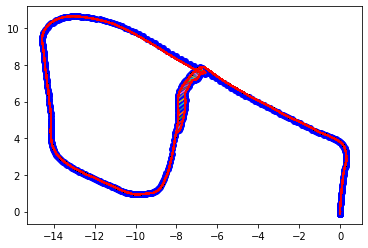

|dX| for step 22 : 0.22189825773239136

linearize and build system


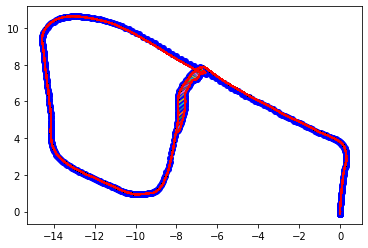

|dX| for step 23 : 0.2146236002445221

linearize and build system


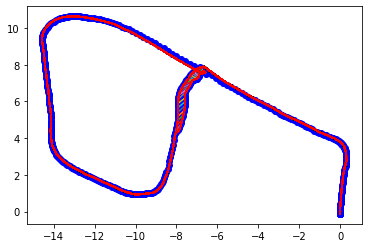

|dX| for step 24 : 0.2092272937297821

linearize and build system


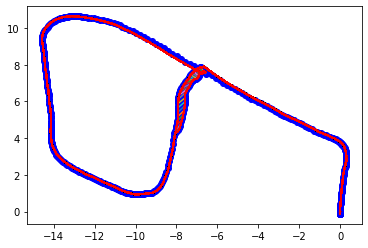

|dX| for step 25 : 0.2030823528766632

linearize and build system


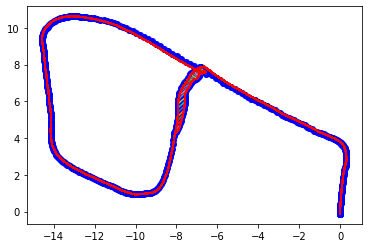

|dX| for step 26 : 0.1973588615655899

linearize and build system


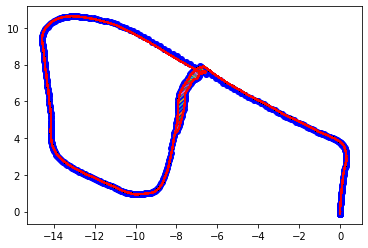

|dX| for step 27 : 0.1919623166322708

linearize and build system


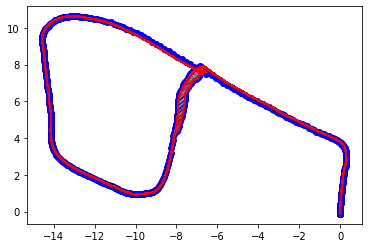

|dX| for step 28 : 0.1868472397327423

linearize and build system


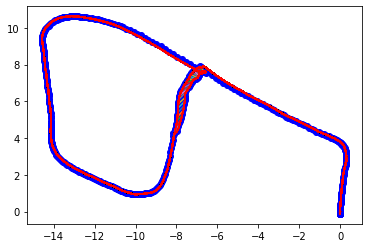

|dX| for step 29 : 0.18222492933273315

linearize and build system


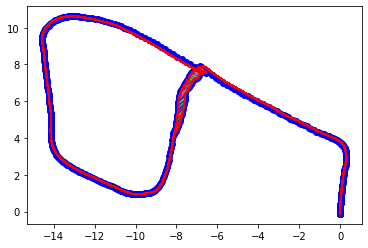

|dX| for step 30 : 0.17737345397472382

linearize and build system


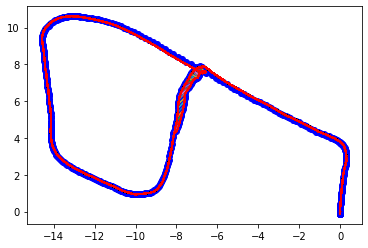

|dX| for step 31 : 0.17296436429023743

linearize and build system


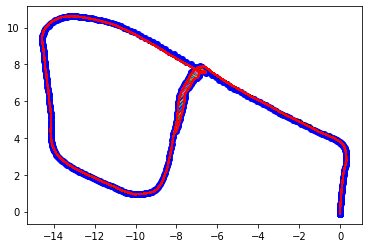

|dX| for step 32 : 0.16924788057804108

linearize and build system


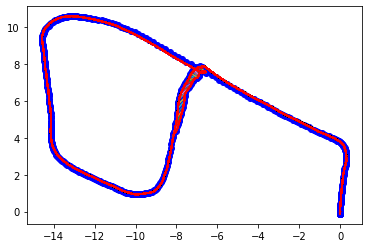

|dX| for step 33 : 0.16499435901641846

linearize and build system


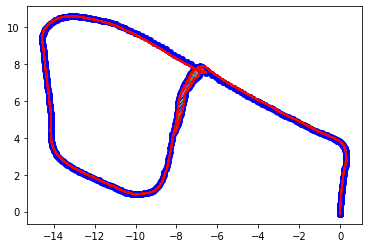

|dX| for step 34 : 0.1610250473022461

linearize and build system


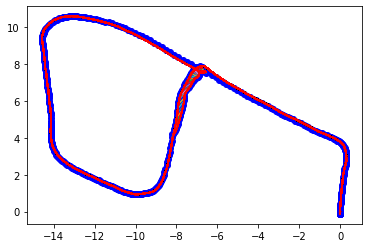

|dX| for step 35 : 0.15771929919719696

linearize and build system


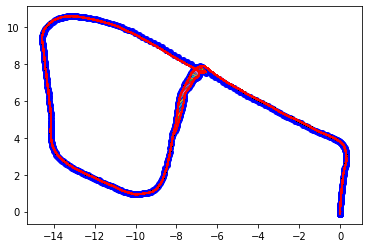

|dX| for step 36 : 0.1539679765701294

linearize and build system


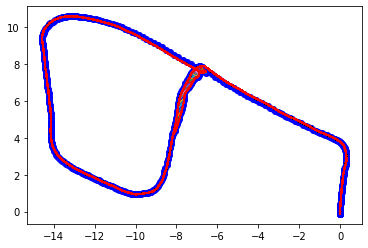

|dX| for step 37 : 0.15076853334903717

linearize and build system


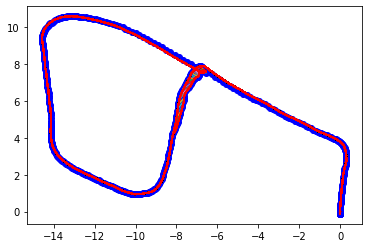

|dX| for step 38 : 0.14760708808898926

linearize and build system


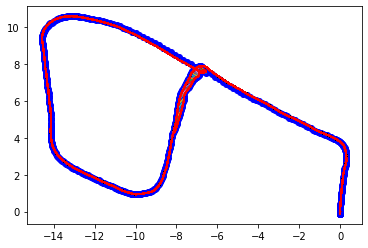

|dX| for step 39 : 0.14503546059131622

linearize and build system


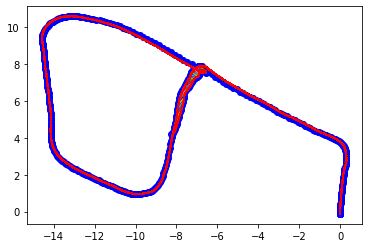

|dX| for step 40 : 0.1420828104019165

linearize and build system


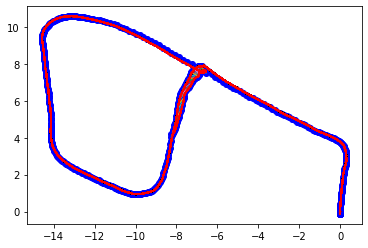

|dX| for step 41 : 0.1390157788991928

linearize and build system


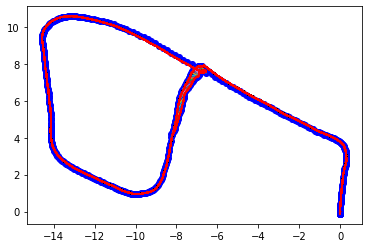

|dX| for step 42 : 0.13705062866210938

linearize and build system


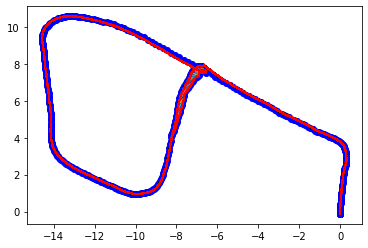

|dX| for step 43 : 0.13427256047725677

linearize and build system


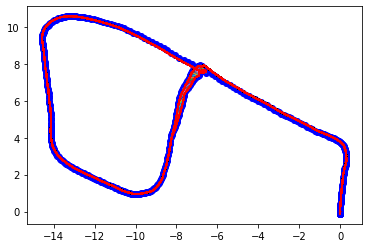

|dX| for step 44 : 0.13201121985912323

linearize and build system


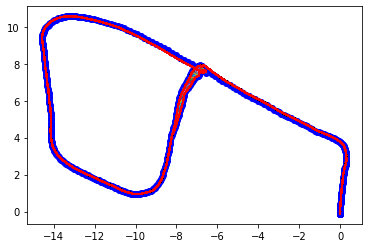

|dX| for step 45 : 0.12961505353450775

linearize and build system


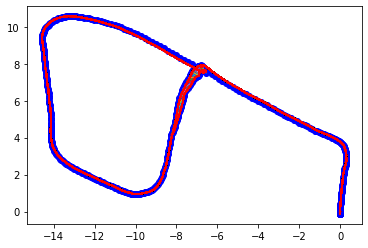

|dX| for step 46 : 0.12731029093265533

linearize and build system


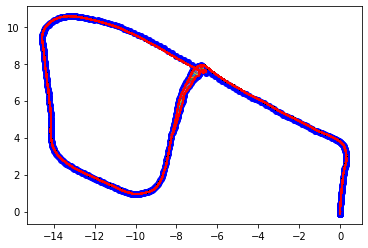

|dX| for step 47 : 0.12525136768817902

linearize and build system


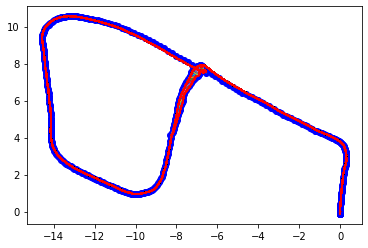

|dX| for step 48 : 0.12326361984014511

linearize and build system


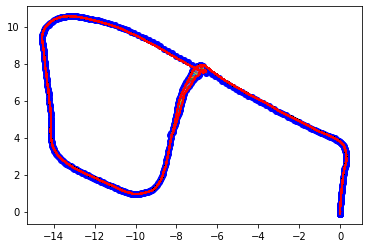

|dX| for step 49 : 0.12186188250780106

linearize and build system


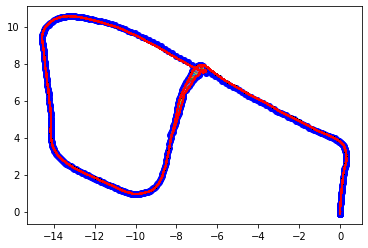

|dX| for step 50 : 0.11968110501766205

linearize and build system


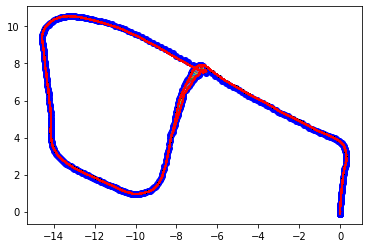

|dX| for step 51 : 0.11771070212125778

linearize and build system


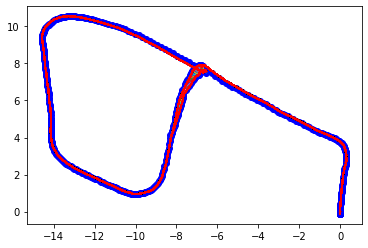

|dX| for step 52 : 0.11603152751922607

linearize and build system


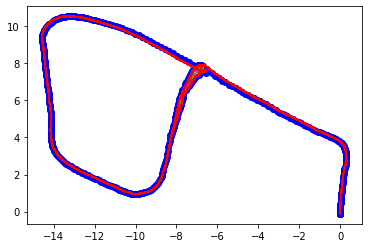

|dX| for step 53 : 0.11465782672166824

linearize and build system


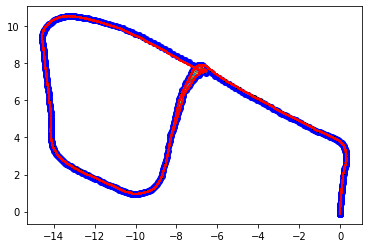

|dX| for step 54 : 0.11301220208406448

linearize and build system


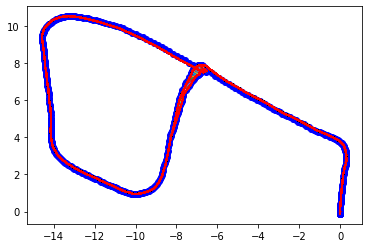

|dX| for step 55 : 0.11129050701856613

linearize and build system


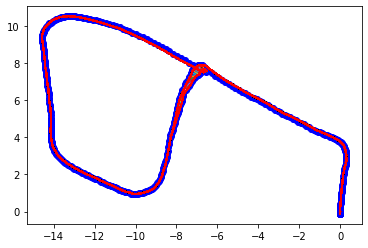

|dX| for step 56 : 0.11013969033956528

linearize and build system


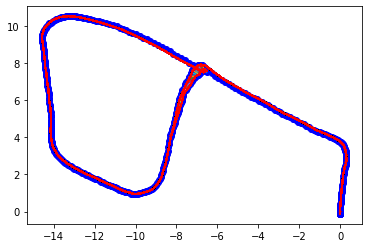

|dX| for step 57 : 0.10827869921922684

linearize and build system


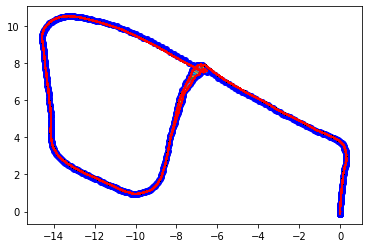

|dX| for step 58 : 0.1069977656006813

linearize and build system


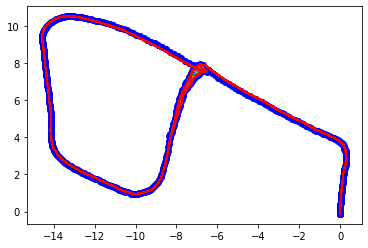

|dX| for step 59 : 0.10583005845546722

linearize and build system


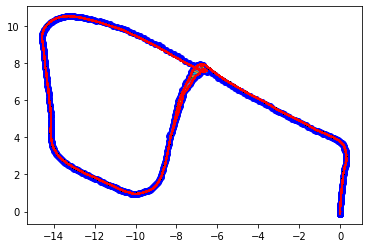

|dX| for step 60 : 0.1043529286980629

linearize and build system


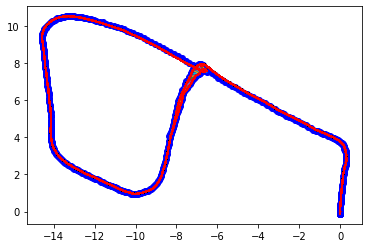

|dX| for step 61 : 0.10302680730819702

linearize and build system


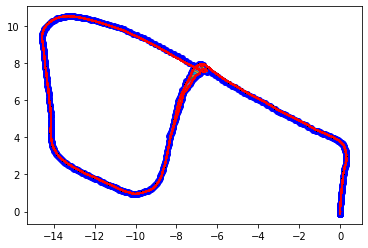

|dX| for step 62 : 0.10198353230953217

linearize and build system


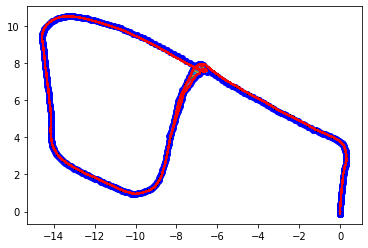

|dX| for step 63 : 0.10094144195318222

linearize and build system


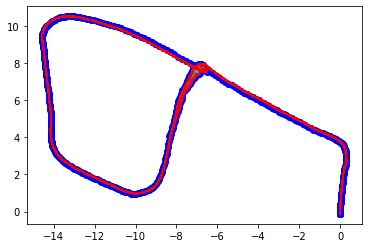

|dX| for step 64 : 0.10006346553564072

linearize and build system


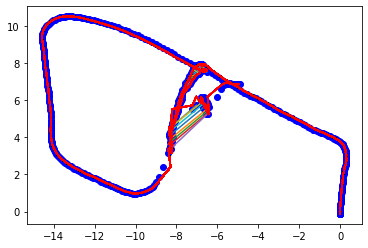

|dX| for step 0 : 13.363765716552734

linearize and build system


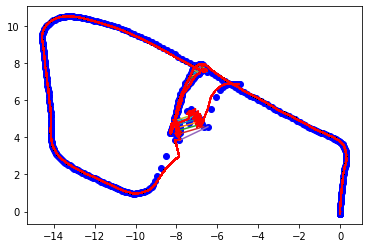

|dX| for step 1 : 5.883359909057617

linearize and build system


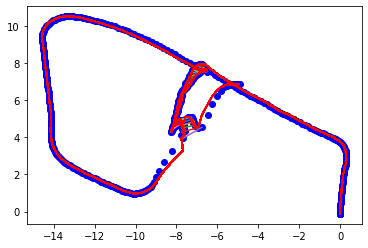

|dX| for step 2 : 2.7631571292877197

linearize and build system


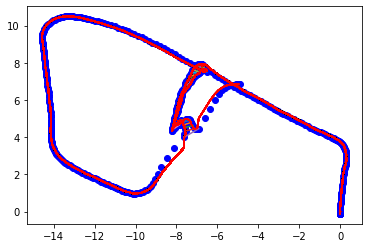

|dX| for step 3 : 1.4275774955749512

linearize and build system


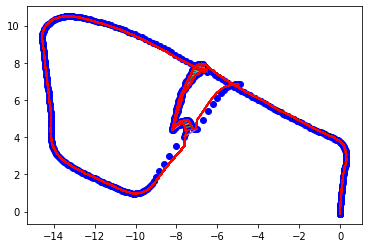

|dX| for step 4 : 0.9273205995559692

linearize and build system


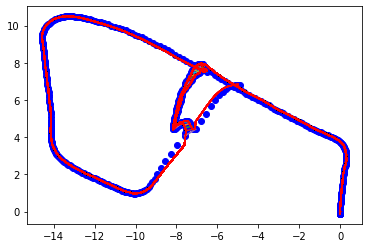

|dX| for step 5 : 0.7281604409217834

linearize and build system


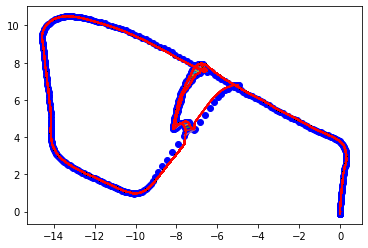

|dX| for step 6 : 0.6236070990562439

linearize and build system


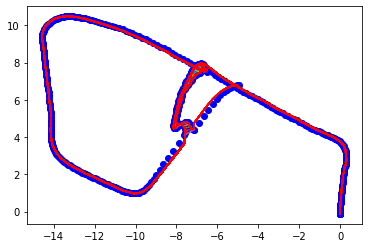

|dX| for step 7 : 0.5550218224525452

linearize and build system


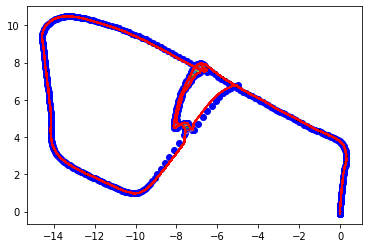

|dX| for step 8 : 0.5057146549224854

linearize and build system


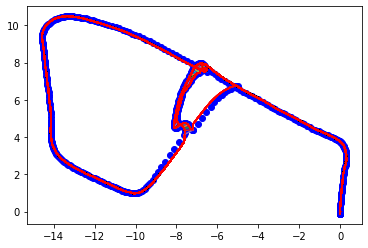

|dX| for step 9 : 0.4689132273197174

linearize and build system


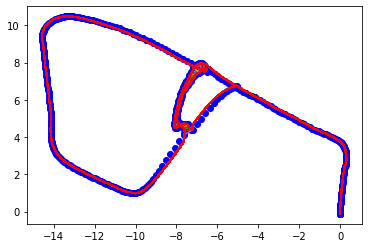

|dX| for step 10 : 0.43714216351509094

linearize and build system


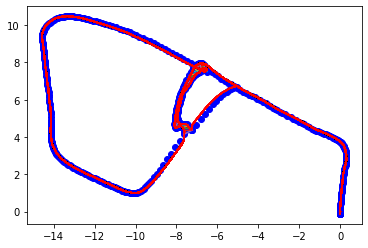

|dX| for step 11 : 0.4133602976799011

linearize and build system


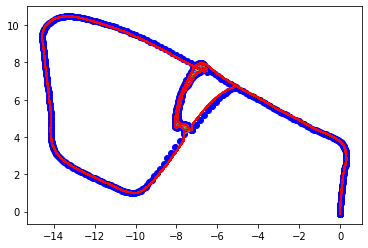

|dX| for step 12 : 0.3923187851905823

linearize and build system


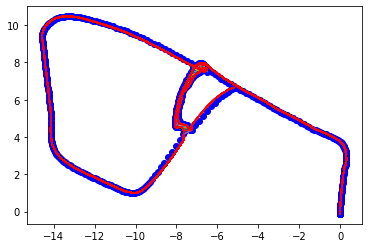

|dX| for step 13 : 0.3741980493068695

linearize and build system


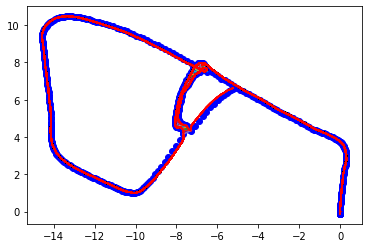

|dX| for step 14 : 0.35732969641685486

linearize and build system


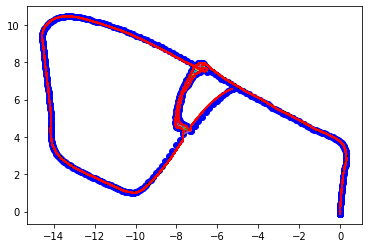

|dX| for step 15 : 0.34364235401153564

linearize and build system


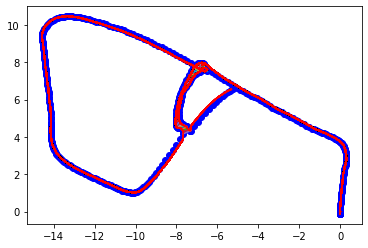

|dX| for step 16 : 0.3320056200027466

linearize and build system


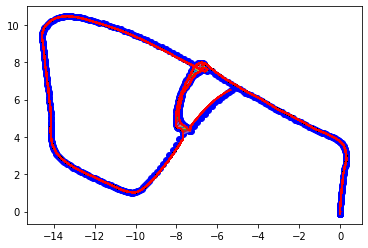

|dX| for step 17 : 0.32129088044166565

linearize and build system


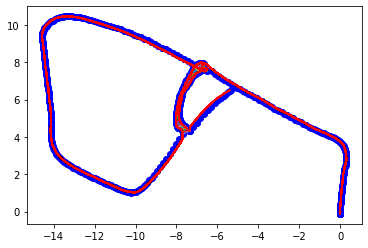

|dX| for step 18 : 0.31126928329467773

linearize and build system


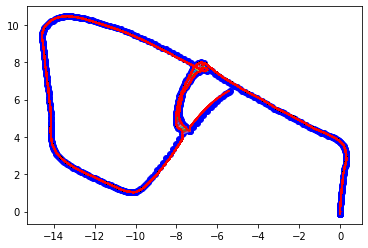

|dX| for step 19 : 0.3019242286682129

linearize and build system


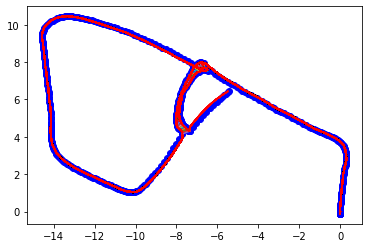

|dX| for step 20 : 0.29414722323417664

linearize and build system


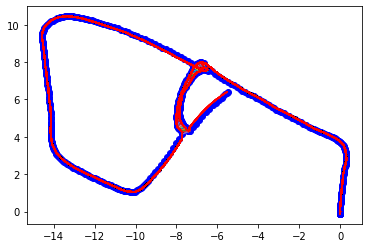

|dX| for step 21 : 0.2853690981864929

linearize and build system


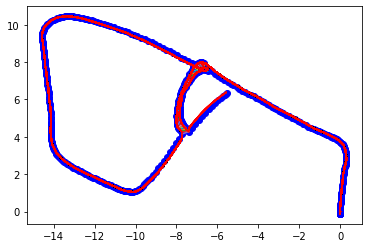

|dX| for step 22 : 0.2795926630496979

linearize and build system


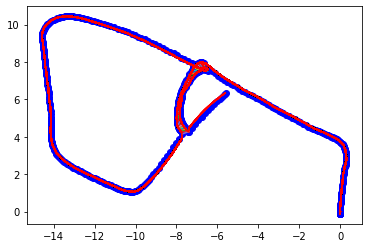

|dX| for step 23 : 0.27212807536125183

linearize and build system


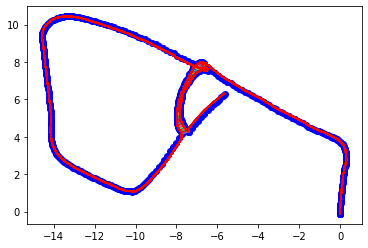

|dX| for step 24 : 0.2654914855957031

linearize and build system


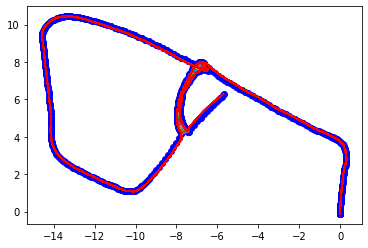

|dX| for step 25 : 0.2613561749458313

linearize and build system


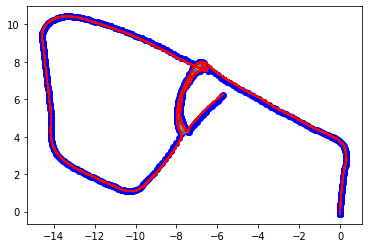

|dX| for step 26 : 0.2533263862133026

linearize and build system


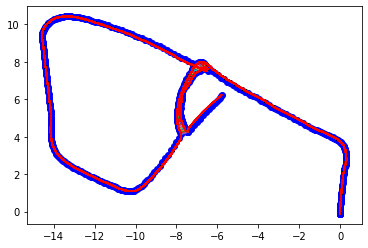

|dX| for step 27 : 0.2495746612548828

linearize and build system


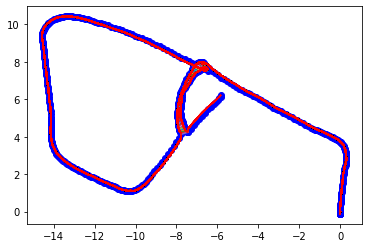

|dX| for step 28 : 0.24357376992702484

linearize and build system


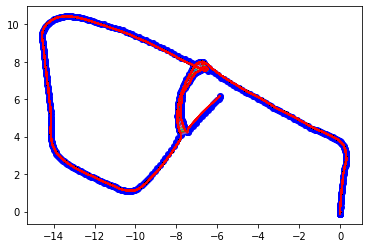

|dX| for step 29 : 0.2378607541322708

linearize and build system


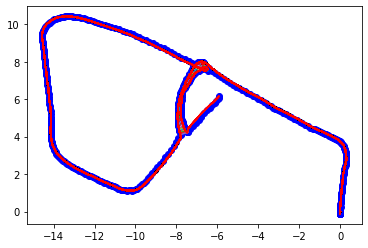

|dX| for step 30 : 0.234096497297287

linearize and build system


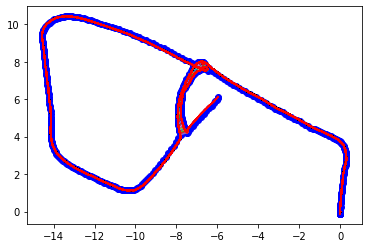

|dX| for step 31 : 0.2310723513364792

linearize and build system


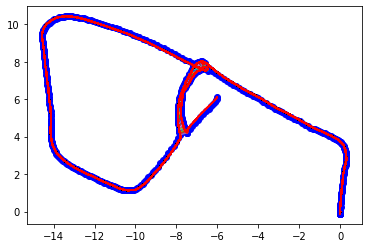

|dX| for step 32 : 0.22581881284713745

linearize and build system


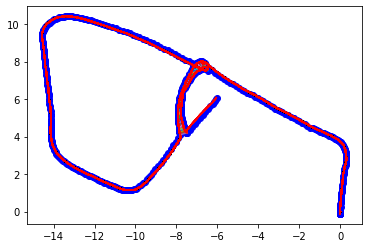

|dX| for step 33 : 0.22260956466197968

linearize and build system


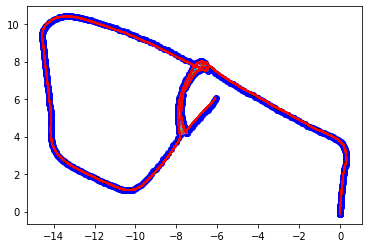

|dX| for step 34 : 0.21864333748817444

linearize and build system


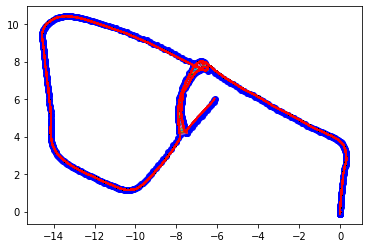

|dX| for step 35 : 0.2156933695077896

linearize and build system


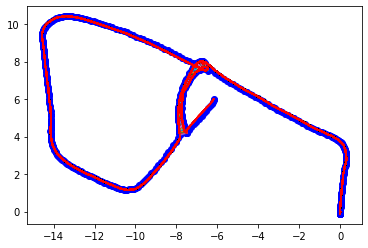

|dX| for step 36 : 0.20961792767047882

linearize and build system


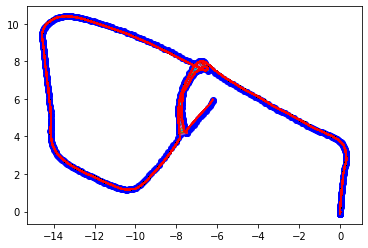

|dX| for step 37 : 0.20805075764656067

linearize and build system


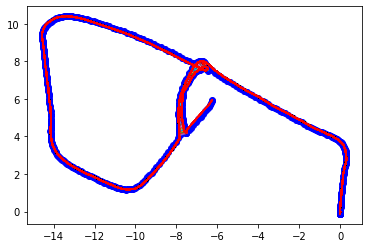

|dX| for step 38 : 0.20508991181850433

linearize and build system


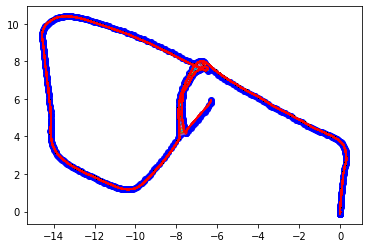

|dX| for step 39 : 0.20144788920879364

linearize and build system


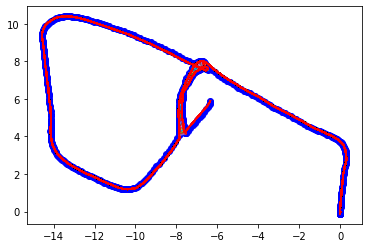

|dX| for step 40 : 0.19855621457099915

linearize and build system


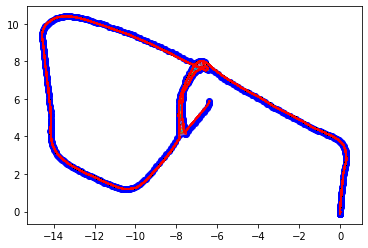

|dX| for step 41 : 0.19722747802734375

linearize and build system


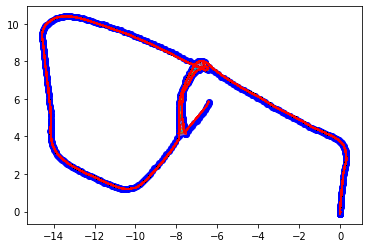

|dX| for step 42 : 0.19507694244384766

linearize and build system


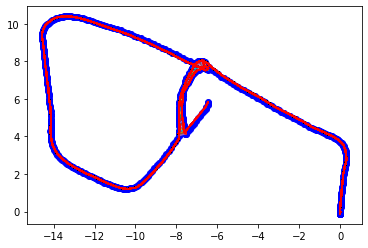

|dX| for step 43 : 0.19121791422367096

linearize and build system


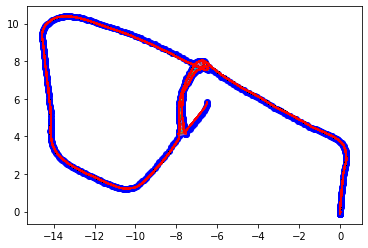

|dX| for step 44 : 0.1883777379989624

linearize and build system


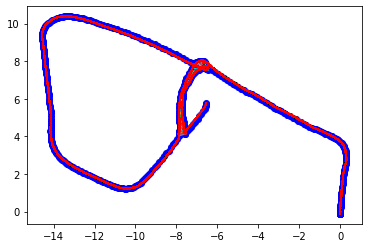

|dX| for step 45 : 0.18545229732990265

linearize and build system


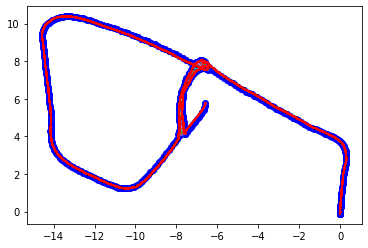

|dX| for step 46 : 0.18397264182567596

linearize and build system


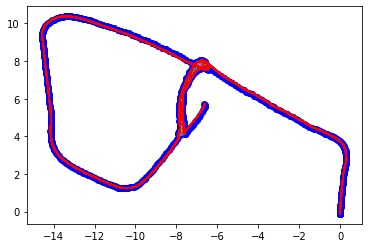

|dX| for step 47 : 0.18175378441810608

linearize and build system


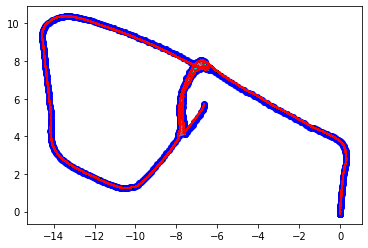

|dX| for step 48 : 0.18337857723236084

linearize and build system


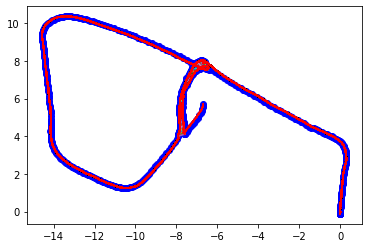

|dX| for step 49 : 0.17899732291698456

linearize and build system


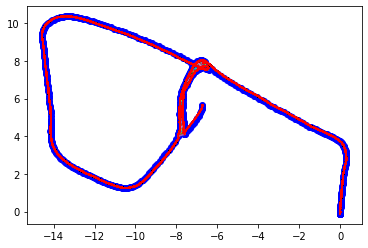

|dX| for step 50 : 0.17534685134887695

linearize and build system


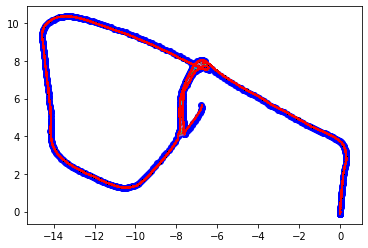

|dX| for step 51 : 0.1737656593322754

linearize and build system


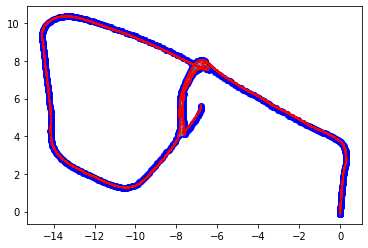

|dX| for step 52 : 0.17255090177059174

linearize and build system


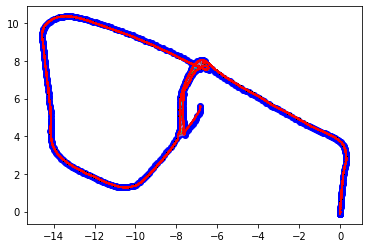

|dX| for step 53 : 0.17048746347427368

linearize and build system


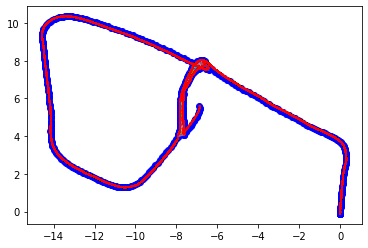

|dX| for step 54 : 0.16760243475437164

linearize and build system


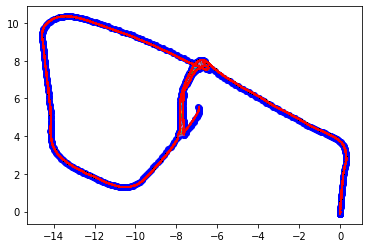

|dX| for step 55 : 0.165089949965477

linearize and build system


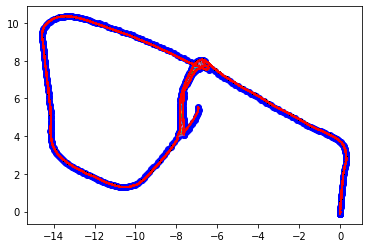

|dX| for step 56 : 0.16469445824623108

linearize and build system


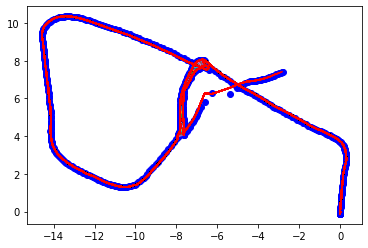

|dX| for step 0 : 1.8055157661437988

linearize and build system


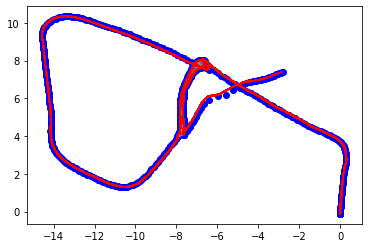

|dX| for step 1 : 0.7639187574386597

linearize and build system


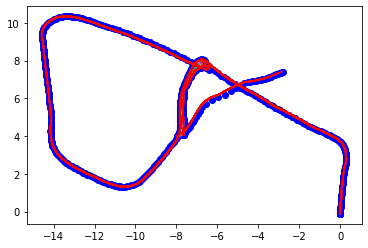

|dX| for step 2 : 0.4683803915977478

linearize and build system


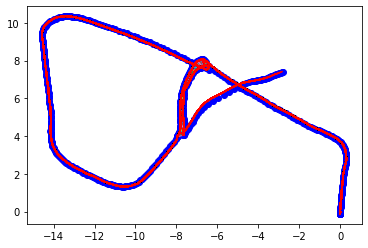

|dX| for step 3 : 0.32945603132247925

linearize and build system


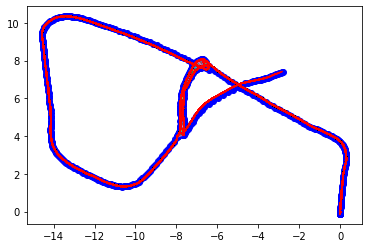

|dX| for step 4 : 0.2717044949531555

linearize and build system


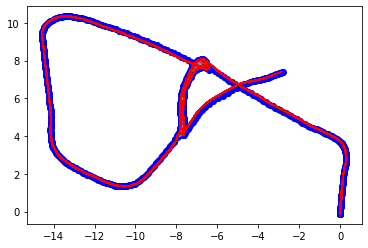

|dX| for step 5 : 0.23271192610263824

linearize and build system


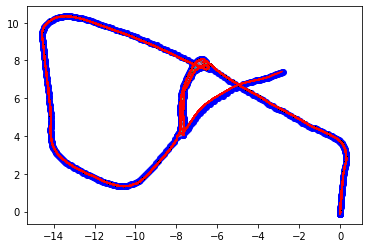

|dX| for step 6 : 0.20939232409000397

linearize and build system


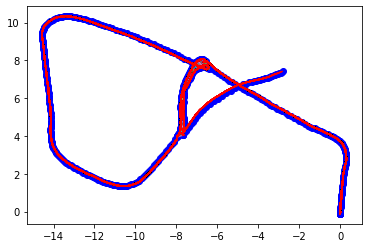

|dX| for step 7 : 0.1856415718793869

linearize and build system


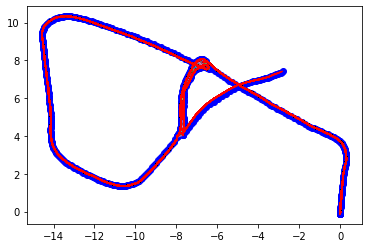

|dX| for step 8 : 0.1741294264793396

linearize and build system


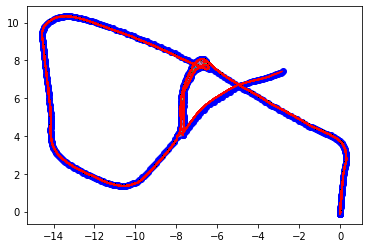

|dX| for step 9 : 0.16415680944919586

linearize and build system


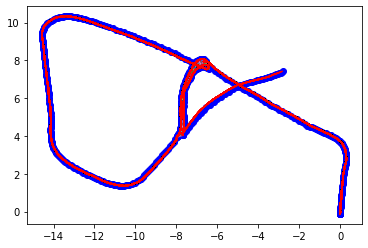

|dX| for step 10 : 0.1558685302734375

linearize and build system


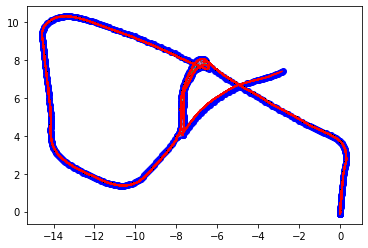

|dX| for step 11 : 0.14593546092510223

linearize and build system


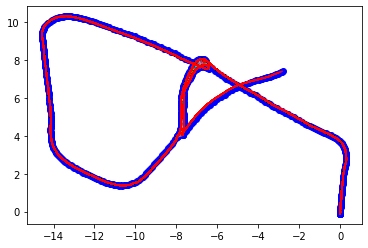

|dX| for step 12 : 0.13916762173175812

linearize and build system


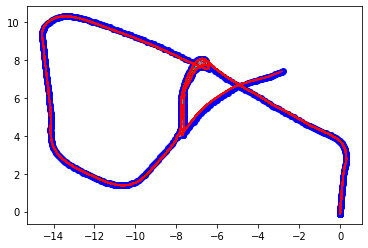

|dX| for step 13 : 0.1346554458141327

linearize and build system


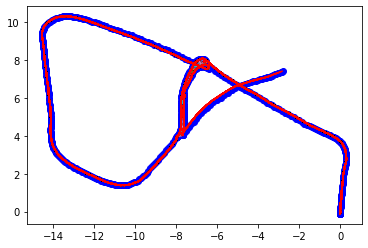

|dX| for step 14 : 0.13251864910125732

linearize and build system


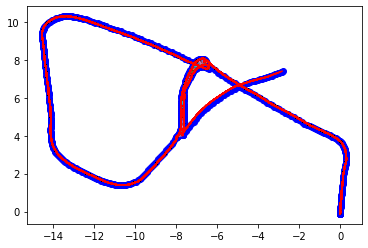

|dX| for step 15 : 0.12765415012836456

linearize and build system


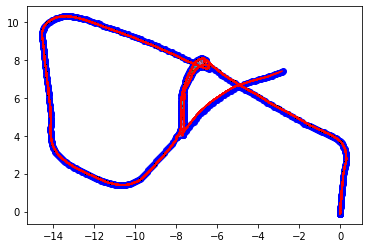

|dX| for step 16 : 0.1242484375834465

linearize and build system


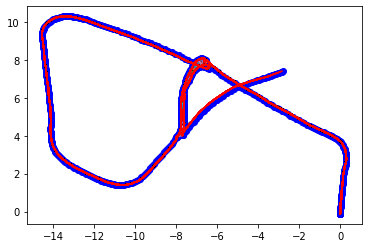

|dX| for step 17 : 0.1167687475681305

linearize and build system


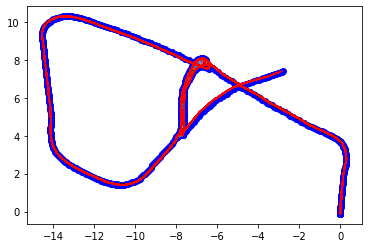

|dX| for step 18 : 0.1178722158074379

linearize and build system


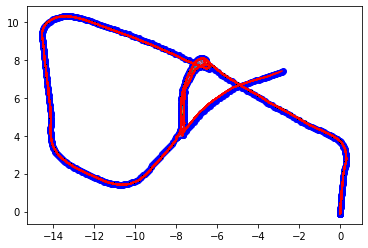

|dX| for step 19 : 0.11580325663089752

linearize and build system


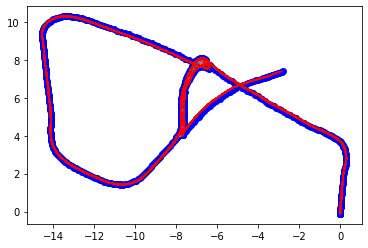

|dX| for step 20 : 0.11427614837884903

linearize and build system


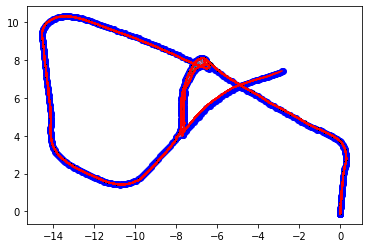

|dX| for step 21 : 0.1137465164065361

linearize and build system


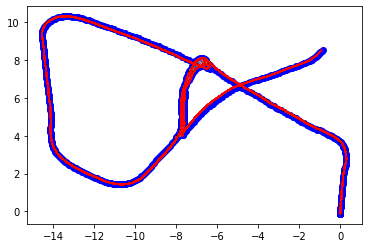

|dX| for step 0 : 0.10998266935348511

linearize and build system


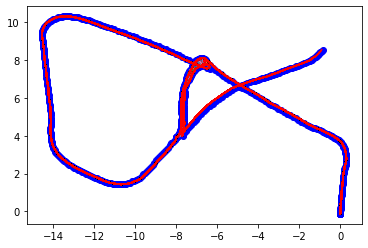

|dX| for step 1 : 0.1085793673992157

linearize and build system


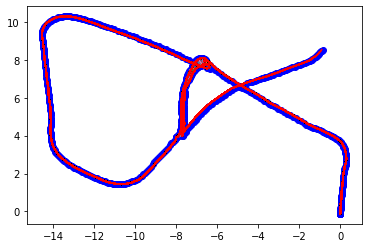

|dX| for step 2 : 0.10674264281988144

linearize and build system


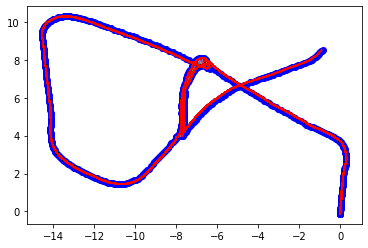

|dX| for step 3 : 0.10558106750249863

linearize and build system


KeyboardInterrupt: ignored

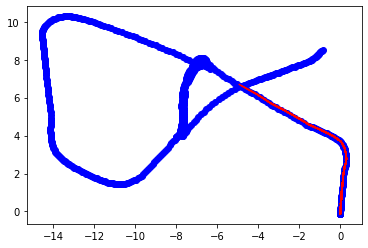

In [ ]:
pc_grad=gradslam.Pointclouds(lasers,normals)
slam=grad_lidar(iterations=2)
slam.forward(pc_grad,lasers)

In [ ]:
def forward(self,pc_grad,odoms,loop_closure=True):
        #odom_data : Consists of odometry data of the robot i.e poses of the robot
        #pc_grad   : Consists of lidar scans for each and every pose in gradslam pointcloud datatype


        poses=[torch.eye(4, dtype=torch.float, device = self.device).view(1,1,4,4)]  # list containing poses of nodes
        vertex_idx=1
        poseeuler=rotationMatrixToEulerAngles(torch.squeeze(poses[-1])[:3,:3])       #Converting init orientation to euler angles
        pose=torch.concat((poses[-1].squeeze()[:2,3],poseeuler[2].unsqueeze(0)))
        self.g.add_vertex(vertex_idx,pose)                                           # adding first vertex

        for od_idx,odom in enumerate(odoms):

            if od_idx==0:
                prev_odom=odom
                prev_idx=0
                self.all_lasers.append(pc_grad[prev_idx])
                continue
            if od_idx%2==0:
                pcd1=pc_grad[prev_idx]
                0
                pcd2=pc_grad[od_idx]
                vertex_idx+=1

                transform=self.odomprov.provide(pcd1,pcd2)                            # finding transform using ICP form gradslam

                pcd_pose = compose_transformations(poses[-1].squeeze(1),transform.squeeze(1)).unsqueeze(1)
                poses.append(pcd_pose)
                pose=Convert_to_pose(poses[-1].squeeze())
                T=Convert_to_pose(transform.squeeze())
                self.g.add_vertex(vertex_idx,pose)                                        #Adding the vertex
                self.g.add_edge("P",vertex_idx-1,vertex_idx,T,torch.eye(3,device="cuda")) # Adding the edge


                prev_odm=odom
                prev_idx=od_idx
                self.all_lasers.append(pcd2)


                if vertex_idx>50 and vertex_idx%30==0:                                 # If the number of nodes> 50 then find loop clousure and optimize pose graph
                  if loop_closure:
                      find_loop_clousure(pose,vertex_idx,self.all_lasers,self.g)
                  for i,j in enumerate(list(self.g.loc.keys())[self.prev:vertex_idx]):    # Here g.x is flattened vector of all poses of the nodes
                    self.g.lut.update({j:self.offset})
                    self.offset=self.offset+len(self.g.loc[j])                            # g.lut is a dictionary which contains starting and ending index of pose for each node
                    if self.g.x==None:
                      self.g.x=self.g.loc[j]
                    else:
                      self.g.x=torch.cat((self.g.x,self.g.loc[j]))
                  #plot_graph(self.g)
                  err_dlr=run_graph_slam(self.g,100)                                      # running pose graph optimization for 100 iterations
                  self.prev=vertex_idx

        gt_file = open("gt_2.txt",'w')
        inf_file = open("inf_2.txt",'w')

        up_poses=[i for i in [self.g.x[j:j+3] for j in range(0,len(self.g.x),3)]]
        updated_poses=[]
        for i,p in enumerate(up_poses):
          r = R.from_euler('zyx', odoms[i][2] , degrees = True).as_quat()
          gt_file.write(np_to_txt(odoms[i][0],np.array(odoms[i][1]),np.array(r))+"\n")
          # print(p[2].cpu().numpy())
          r_inf = R.from_euler('zyx', p[2].detach().cpu().numpy() , degrees = True).as_quat()
          inf_file.write(np_to_txt(odoms[i][0],np.array([p[0],p[1],0])),np.array(r_inf)+"\n")
          #print(i)
          # R=eul2rot(i[2])
          # b=torch.eye(4, dtype=torch.float,device="cuda")
          # b[:3,:3]=R
          # b[0][3]=i[0]
          # b[1][3]=i[1]
          # updated_poses.append(b.view(1,1,4,4))
        # poses=updated_poses

        gt_file.close()
        inf_file.close()